<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 31 January 2017</td>
<td style="text-align: right;"><a href="https://www.github.com/rhyswhitley/fire_limitation">github.com/rhyswhitley/fire_limitation</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 2: Bayesian inference</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>2 </sup>Ioannis Bistinas, 
<sup>3, 4 </sup>Chantelle Burton, 
<sup>1 </sup>Tobias Marthews, 
<sup>5 </sup>Rhys Whitley
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Vrije Universiteit Amsterdam, Faculty of Earth and Life Sciences, Amsterdam, Netherlands
<br>
<sup>3 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>4 </sup>Geography, University of Exeter, Exeter, United Kingdom
<br>
<sup>5 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global fire model (defined below). The model is driven by a number of covariates (X<sub>i=1, 2, ... M</sub>) that describe: cropland, pasture and urban area footprints; frequency of lightening ignitions, population density, net primary productivity (NPP) and <i>Alpha</i>, a proxy measure of available soil moisture in the root zone. The model attempts to predict the impact of fire through burnt area and is thus the model target (Y).
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Model description
The model considers percentage of burnt area to be the joint product of a set of conditions that modulate fire through fuel load, ignitions, moisture and supression. Each control assumes some equilibrium point that desribes the optimal conditions for fire, that may be proportionally modified through some empirical relationship. These are briefly outlined below for the sake of comprehension in this notebook, but can be referred to in more detail in the model protocol located in the docs/ folder (<a href='file:///localhost/../docs/Model_description.pdf'>model protocol</a>).

\begin{eqnarray}
    F_{burn} &=& \prod_{i}S(x_{i}) \\[1em]
\end{eqnarray}

Where $S(x_{i})$ representes some measure of fire conditions by $i =$ fuel, moisture, ignitions and anthropagenic supression, and is describe by a sigmoid:

\begin{equation}
    S(x_{i=fuel, moist, ignite, suppr}) = \frac{1}{1 + \exp\{-b\cdot(x_i-a)\}}
\end{equation}

The $fuel$ sigmoid considers only fractional vegetation cover and therefore have no hyper-parameters. Sigmoids $moist$, $ignite$ and $suppr$ describe an aggregation of other climate and land-use covariates. Because these sigmoids are influenced by an aggregation of different drivers, they are influenced in turn by different sets of hyper-parameters; these are now described below.  

#### Fuel load covariate (no hyper-parameters)
\begin{equation}
    x_{fuel} = FPC 
\end{equation}

#### Moisture covariate
\begin{equation}
    x_{moist} = \alpha + k_M \cdot EMC    
\end{equation}

where $EMC$ is the equilibrium moisture content <span style="color:red">(define)</span>.
#### Ignition covariate 
\begin{equation}
    x_{ignite} = Lightn + k_p\cdot A_{pasture} + k_{d1}\cdot\rho_{population}
\end{equation}

Where $Lightn$ is the number of cloud-to-ground lightning strikes, modified  as per Kelley et al. 2014.

<a style="color: red">Explain difference from Kelley et al. 2014 for F_L = 0.0:

F<sub>L</sub>=0.0 is not possible, as 0.0 can't have a negative signed exponent; have I got this equation right?
</a>


#### Supression covariate 
\begin{equation}
    x_{supress} = A_{urban} + k_C\cdot A_{Crop} + k_{d2}\cdot\rho_{population} 
\end{equation}

This leaves 13 free parameters that need to be optimised against observations of burnt area.  

### Load libraries

In [97]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import pymc3  as pm3 
from   pymc3.backends import SQLite
from   scipy  import optimize
from   theano import tensor as tt

import matplotlib.pyplot as plt

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

# paths and parameters
sample_pc     = 10
nIterations   = 10000
outPath       = "../data/globfire.csv"
param_outpath = '../outputs/params.csv'
trace_db      = '../data/firemodel_trace_maxF_longLims_CoverBigPower_TreeMoisture_alphaMax_NofirePower11.db'

In [98]:
def npLog0 (x):
    return [np.log(i) if i > 0 else 0.0000001 for i in x]

## 2.1 Fire limitation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [99]:
from pdb import set_trace as browser
def fuel_load(fuel, alphaMax, fp, fpg):
    """
    Definition to describe fuel load: while return the input; capability to be modified later.
    """
    #falpha = (1/fp) + (alphaMax/fpg)
    #return fuel**fp
    return (fuel**fp) * (fpg * alphaMax + 1) / (1 + fpg)
    #return (fuel**fp + fpg * alphaMax) / (1 + fpg)

def moisture(alpha, emc, tree, cM, cMT):
    """
    Definition to describe moisture
    """
    return (alpha + 0.01*cM*emc + 0.01*cMT * tree) / (1 + cM + cMT)


def ignition(lightning, pasture_area, pop_density, cP, cD1):
    """
    Definition for the measure of ignition
    """
    ignite = lightning + cP*pasture_area + cD1*pop_density
    #try:
    #    ignite = npLog0(ignite)
    #except:
    #    ignite = np.log(ignite)
    return ignite

def supression(crop_area, pop_density, cD2):
    """
    Definition for the measure of fire supression
    """
    return crop_area + cD2*pop_density

def tt_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + tt.exp(-k*(x - x0)))

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. Rows are defined as a fraction of total data points (above). For full optimiatizaion, we set at 10%, but for testing purposes I've limited the number of rows I'm importing to 2%.

In [100]:
def load_with_buffer(filename, line_select, **kwargs):
    s_buf = StringIO()
    line_select = np.sort(line_select)
    with open(filename) as file:
        count = -1
        lineN = -1
        for line in file:
            lineN += 1
            if lineN == 0 or lineN == line_select[count]:
                s_buf.write(line)
                count += 1
                if count == len(line_select): break
            
    s_buf.seek(0)
    df = pd.read_csv(s_buf,**kwargs)
    return df

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f): pass
    return i + 1

DATAPATH = os.path.expanduser(outPath)

nlines      = file_len(DATAPATH)
npoints     = round(sample_pc * nlines / 100)
line_select = np.random.choice(range(0, nlines), npoints, False)
fd          = load_with_buffer(DATAPATH, line_select)

In [101]:
fd['fuel'] = npLog0(fd['NPP'].values)
fd['vegCover'] = (100.0 - fd['bareground'])/100.0
fd['alphaMax'] = fd['alpha_'] - 1.0

Do a sanity check to make sure our data has imported correctly.

In [102]:
fd.info()
fd.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023332 entries, 0 to 1023331
Data columns (total 19 columns):
alpha                  1023332 non-null float64
alpha_                 1023332 non-null float64
bareground             1023332 non-null float64
cropland               1023332 non-null float64
emc                    1023332 non-null float64
fire                   1023332 non-null float64
Hr                     1023332 non-null float64
lightning_ignitions    1023332 non-null float64
NPP                    1023332 non-null float64
pasture                1023332 non-null float64
population_density     1023332 non-null float64
Prc                    1023332 non-null float64
Tas                    1023332 non-null float64
treecover              1023332 non-null float64
urban_area             1023332 non-null float64
Wet                    1023332 non-null float64
fuel                   1023332 non-null float64
vegCover               1023332 non-null float64
alphaMax               

alpha    alpha_  bareground  cropland        emc  fire         Hr  \
0   0.340697  2.532386       100.0       0.0  45.413116   0.0  66.679855   
1   0.369000  1.693985       100.0       0.0  45.576069   0.0  63.240738   
2   0.379044  1.686286       100.0       0.0  44.740524   0.0  62.695889   
3   0.717726  1.234826       100.0       0.0  54.896107   0.0  72.590248   
4   0.244062  1.768736       100.0       0.0  38.806141   0.0  63.805775   
5   0.579612  1.482044        74.0       0.0  61.447723   0.0  77.885643   
6   0.325241  1.522493        96.0       0.0  51.553635   0.0  71.964622   
7   0.686866  1.536562       100.0       0.0  53.614437   0.0  70.338684   
8   0.497697  1.605985       100.0       0.0  50.072575   0.0  64.258652   
9   0.340285  2.019114       100.0       0.0  44.196640   0.0  64.654655   
10  0.242924  1.757255       100.0       0.0  37.911175   0.0  64.645439   
11  0.247083  1.717309       100.0       0.0  38.487724   0.0  71.312096   
12  1.244713  1.003692        96.0       0.0  58.788742   0.0  61.128311   
13  0.699108  1.174991        98.0       0.0  53.384644   0.0  71.220848   
14  0.545747  1.466598        96.0       0.0  60.581249   0.0  54.903187   
15  0.557876  1.414595        91.0       0.0  60.283752   0.0  53.055405   
16  0.538499  1.330869        91.0       0.0  59.088032   0.0  52.448063   
17  0.266998  1.588841        73.0       0.0  50.423798   0.0  83.595001   
18  0.312237  1.639654       100.0       0.0  48.731785   0.0  83.258690   
19  0.316391  1.724807       100.0       0.0  48.189186   0.0  83.258690   

    lightning_ignitions         NPP  pasture  population_density        Prc  \
0                   0.0  107.076385      0.0                 0.0  14.700000   
1                   0.0   87.450981      0.0                 0.0  16.100000   
2                   0.0   89.214287      0.0                 0.0  15.000000   
3                   0.0   64.000000      0.0                 0.0  41.900002   
4                   0.0    3.560345      0.0                 0.0  14.600000   
5                   0.0  210.806900      0.0                 0.0  38.700001   
6                   0.0  164.687500      0.0                 0.0  16.200001   
7                   0.0   43.945454      0.0                 0.0  24.900000   
8                   0.0  103.132530      0.0                 0.0  19.900000   
9                   0.0  107.500000      0.0                 0.0  16.100000   
10                  0.0   29.577778      0.0                 0.0  14.100000   
11                  0.0    5.217391      0.0                 0.0  16.299999   
12                  0.0   29.016949      0.0                 0.0  50.900002   
13                  0.0   10.185185      0.0                 0.0  21.500000   
14                  0.0  186.000000      0.0                 0.0  32.099998   
15                  0.0  105.361115      0.0                 0.0  34.400002   
16                  0.0  156.000000      0.0                 0.0  32.500000   
17                  0.0  177.903229      0.0                 0.0  13.300000   
18                  0.0   97.611115      0.0                 0.0  15.800000   
19                  0.0  117.693695      0.0                 0.0  16.100000   

    Tas  treecover  urban_area       Wet      fuel  vegCover  alphaMax  
0   4.2        0.0         0.0  0.234194  4.673542      0.00  1.532386  
1   1.8        0.0         0.0  0.225161  4.471078      0.00  0.693985  
2   1.6        0.0         0.0  0.218387  4.491041      0.00  0.686286  
3   0.8        0.0         0.0  0.313226  4.158883      0.00  0.234826  
4   4.3        0.0         0.0  0.185806  1.269857      0.00  0.768736  
5   4.8        2.0         0.0  0.417419  5.350943      0.26  0.482044  
6   5.5        2.0         0.0  0.290968  5.104050      0.04  0.522493  
7   2.1        0.0         0.0  0.294516  3.782949      0.00  0.536562  
8   2.5        0.0         0.0  0.260645  4.636015      0.00  0.605985  
9   3.0        0.0  

## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as uniform, where bounds are either physical limits of the variable in question, or set generously beyound what is realistic plausable. Some of them can possibly be describe as exponential or half-normal, due to the physical nature of $\beta$, but we can play around with that later.

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{4}P(a_i)\prod_{i=1}^{4}P(b_i)\cdot P(\sigma)\cdot P(k_c)P(k_p)P(k_{d,1})P(k_{d,2}) \\[1.5em]
    P(a) = P(b) = P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
    P(k_c) = P(k_p) = P(k_{d,1}) = P(k_{d,2}) &=& \mathcal{U}(\beta_{\min}, \beta_{\max}) \\[1.5em]
\end{eqnarray}

I'm not totally sure about the maths above being right, but it's just to show that _full_ prior is normal. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). 

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.



In [103]:
with pm3.Model() as fire_error:
    
# first for the sigmoids  
    fuel_x0        = pm3.Uniform('fuel_x0'       ,    -1.0,  2.0)
    fuel_k         = pm3.Uniform('fuel_k'        ,     0.0, 1000.0)
    fuel_pw        = pm3.Uniform('fuel_pw'       ,     1.0, 20.0)
    fuel_pg        = pm3.Uniform('fuel_pg'       ,     0.0, 1.0)
    
    moisture_x0    = pm3.Uniform('moisture_x0'   ,    -1.0,  2.0)
    moisture_k     = pm3.Uniform('moisture_k'    ,     0.0, 1000.0)
    
    ignition_x0    = pm3.Uniform('igntions_x0'   ,    -4.0, 4.0)
    ignition_k     = pm3.Uniform('igntions_k'    ,     0.0, 1000.0)
    
    suppression_x0 = pm3.Uniform('suppression_x0',  -100.0,  200.0)
    suppression_k  = pm3.Uniform('suppression_k' ,     0.2, 10.0)
    
    max_f          = pm3.Uniform('max_f'         ,     0.0,    1.0)
    #pow_f          = pm3.Uniform('pow_f'         ,     0.0,    1.0)
# now for the hyper-parameters that describe the independent fire condition covariates
    cM  = pm3.Uniform('cM' , 0.0, 1e4)
    cMT = pm3.Uniform('cMT', 0.0, 1e4)
    #cL  = pm3.Uniform('cL' , 0, 1e4)
    cP  = pm3.Uniform('cP' , 0.0, 1e4)
    cD1 = pm3.Uniform('cD1', 0.0, 1e4)
    cD2 = pm3.Uniform('cD2', 0.0, 1e4)
    #cDmax = pm3.Uniform('cDmax', 0, 1e4)
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1)

### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

In [104]:
with fire_error:
    
    # transform hyper-covariates 
    f_fuel        = fuel_load(fd["vegCover"].values, fd["vegCover"].values, fuel_pw, fuel_pg)
    
    f_moisture    = moisture(fd["alpha"].values, fd["emc"].values, fd["treecover"].values, cM, cMT)
    
    f_ignition    = ignition(fd["lightning_ignitions"].values, \
                             fd["pasture"].values, \
                             fd["population_density"].values, \
                             cP, cD1)
    
    f_suppression = supression(fd["cropland"].values, \
                               fd["population_density"].values, \
                               cD2)
    
    # burnt area is assumed to be the product of the 4 sigmoids
    
    prediction = max_f * np.product([tt_sigmoid(f_fuel, fuel_k, fuel_x0),
                             tt_sigmoid(f_moisture, - moisture_k, moisture_x0),
                             tt_sigmoid(f_ignition, ignition_k, ignition_x0),
                             tt_sigmoid(f_suppression, - suppression_k, suppression_x0)])
                  
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu=prediction, sd=sigma, observed=fd['fire'].values)

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [105]:
with fire_error:
    
    # help the sampling out by quickly finding an optimal start position
    start = pm3.find_MAP(model=fire_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    db_save = SQLite(trace_db)
    
    # do the sampling
    mcmc_traces = pm3.sample(nIterations, step=step, start=start, njobs=-1, trace=db_save)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\dougl\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-3.6.5-64\lock_dir\lock
C:\Users\dougl\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '





  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]




logp = -7.1013e+05:   0%|                                                                     | 0/5000 [00:00<?, ?it/s]




logp = -7.1013e+05:   0%|                                                             | 1/5000 [00:00<51:16,  1.63it/s]




logp = -7.1013e+05:   0%|                                                             | 2/5000 [00:00<40:26,  

logp = 2.1569e+06:   1%|▋                                                            | 55/5000 [00:10<15:11,  5.42it/s]




logp = 2.1569e+06:   1%|▋                                                            | 56/5000 [00:10<15:02,  5.48it/s]




logp = 2.1569e+06:   1%|▋                                                            | 57/5000 [00:10<14:59,  5.49it/s]




logp = 2.1569e+06:   1%|▋                                                            | 58/5000 [00:11<14:49,  5.55it/s]




logp = 2.1569e+06:   1%|▋                                                            | 59/5000 [00:11<14:42,  5.60it/s]




logp = 2.1569e+06:   1%|▋                                                            | 60/5000 [00:11<14:39,  5.62it/s]




logp = 2.1569e+06:   1%|▋                                                            | 60/5000 [00:11<14:39,  5.62it/s]




logp = 2.1569e+06:   1%|▋                                                            | 61/5000 [00:11<14:40,  5.61it/s]




logp = 2

logp = 2.4331e+06:   2%|█▍                                                          | 115/5000 [00:22<15:50,  5.14it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 116/5000 [00:22<15:50,  5.14it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 117/5000 [00:22<15:47,  5.16it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 118/5000 [00:22<16:05,  5.06it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 119/5000 [00:23<15:58,  5.09it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 120/5000 [00:23<15:55,  5.11it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 120/5000 [00:23<15:55,  5.11it/s]




logp = 2.4331e+06:   2%|█▍                                                          | 121/5000 [00:23<15:56,  5.10it/s]




logp = 2

logp = 2.4331e+06:   4%|██                                                          | 175/5000 [00:34<16:18,  4.93it/s]




logp = 2.4331e+06:   4%|██                                                          | 176/5000 [00:34<16:15,  4.95it/s]




logp = 2.4331e+06:   4%|██                                                          | 177/5000 [00:34<16:14,  4.95it/s]




logp = 2.4331e+06:   4%|██▏                                                         | 178/5000 [00:34<16:13,  4.96it/s]




logp = 2.4331e+06:   4%|██▏                                                         | 179/5000 [00:34<16:23,  4.90it/s]




logp = 2.4331e+06:   4%|██▏                                                         | 180/5000 [00:35<16:18,  4.93it/s]




logp = 2.4331e+06:   4%|██▏                                                         | 180/5000 [00:35<16:18,  4.93it/s]




logp = 2.4331e+06:   4%|██▏                                                         | 181/5000 [00:35<16:17,  4.93it/s]




logp = 2

logp = 2.4331e+06:   5%|██▊                                                         | 236/5000 [00:45<12:46,  6.22it/s]




logp = 2.4331e+06:   5%|██▊                                                         | 237/5000 [00:45<13:02,  6.08it/s]




logp = 2.4331e+06:   5%|██▊                                                         | 239/5000 [00:45<11:13,  7.07it/s]




logp = 2.4331e+06:   5%|██▉                                                         | 240/5000 [00:46<11:13,  7.07it/s]




logp = 2.4331e+06:   5%|██▉                                                         | 241/5000 [00:46<09:53,  8.02it/s]




logp = 2.4331e+06:   5%|██▉                                                         | 243/5000 [00:46<08:56,  8.86it/s]




logp = 2.4331e+06:   5%|██▉                                                         | 245/5000 [00:46<08:15,  9.60it/s]




logp = 2.4331e+06:   5%|██▉                                                         | 247/5000 [00:46<07:46, 10.18it/s]




logp = 2

logp = 2.6046e+06:   7%|████▏                                                       | 345/5000 [00:54<05:42, 13.58it/s]




logp = 2.6046e+06:   7%|████▏                                                       | 347/5000 [00:54<05:41, 13.62it/s]




logp = 2.6046e+06:   7%|████▏                                                       | 349/5000 [00:54<05:41, 13.63it/s]




logp = 2.6046e+06:   7%|████▏                                                       | 350/5000 [00:54<05:41, 13.63it/s]




logp = 2.6046e+06:   7%|████▏                                                       | 351/5000 [00:54<05:46, 13.41it/s]




logp = 2.6046e+06:   7%|████▏                                                       | 353/5000 [00:54<05:47, 13.37it/s]




logp = 2.6046e+06:   7%|████▎                                                       | 355/5000 [00:54<05:39, 13.70it/s]




logp = 2.6046e+06:   7%|████▎                                                       | 357/5000 [00:55<05:33, 13.91it/s]




logp = 2

logp = 2.6046e+06:   9%|█████▍                                                      | 455/5000 [01:01<07:28, 10.14it/s]




logp = 2.6046e+06:   9%|█████▍                                                      | 457/5000 [01:02<07:35,  9.97it/s]




logp = 2.6046e+06:   9%|█████▌                                                      | 459/5000 [01:02<07:41,  9.84it/s]




logp = 2.6046e+06:   9%|█████▌                                                      | 460/5000 [01:02<07:48,  9.69it/s]




logp = 2.605e+06:   9%|█████▌                                                       | 460/5000 [01:02<07:48,  9.69it/s]




logp = 2.605e+06:   9%|█████▌                                                       | 461/5000 [01:02<07:57,  9.51it/s]




logp = 2.605e+06:   9%|█████▋                                                       | 462/5000 [01:02<07:59,  9.47it/s]




logp = 2.605e+06:   9%|█████▋                                                       | 463/5000 [01:02<07:57,  9.49it/s]




logp = 2

logp = 2.605e+06:  10%|██████▎                                                      | 517/5000 [01:08<08:07,  9.19it/s]




logp = 2.605e+06:  10%|██████▎                                                      | 518/5000 [01:08<08:08,  9.17it/s]




logp = 2.605e+06:  10%|██████▎                                                      | 519/5000 [01:08<08:16,  9.03it/s]




logp = 2.605e+06:  10%|██████▎                                                      | 520/5000 [01:09<08:09,  9.15it/s]




logp = 2.605e+06:  10%|██████▎                                                      | 520/5000 [01:09<08:09,  9.15it/s]




logp = 2.605e+06:  10%|██████▎                                                      | 521/5000 [01:09<08:05,  9.22it/s]




logp = 2.605e+06:  10%|██████▎                                                      | 522/5000 [01:09<08:02,  9.29it/s]




logp = 2.605e+06:  10%|██████▍                                                      | 523/5000 [01:09<07:58,  9.37it/s]




logp = 2

logp = 2.605e+06:  12%|███████                                                      | 577/5000 [01:15<07:56,  9.29it/s]




logp = 2.605e+06:  12%|███████                                                      | 578/5000 [01:15<07:52,  9.37it/s]




logp = 2.605e+06:  12%|███████                                                      | 579/5000 [01:15<07:49,  9.42it/s]




logp = 2.605e+06:  12%|███████                                                      | 580/5000 [01:15<07:47,  9.46it/s]




logp = 2.605e+06:  12%|███████                                                      | 580/5000 [01:15<07:47,  9.46it/s]




logp = 2.605e+06:  12%|███████                                                      | 581/5000 [01:15<07:49,  9.41it/s]




logp = 2.605e+06:  12%|███████                                                      | 582/5000 [01:15<07:48,  9.42it/s]




logp = 2.605e+06:  12%|███████                                                      | 583/5000 [01:15<07:46,  9.46it/s]




logp = 2

logp = 2.6051e+06:  13%|███████▋                                                    | 637/5000 [01:21<08:20,  8.71it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 638/5000 [01:21<08:27,  8.60it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 639/5000 [01:22<08:22,  8.68it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 640/5000 [01:22<08:18,  8.74it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 640/5000 [01:22<08:18,  8.74it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 641/5000 [01:22<08:19,  8.73it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 642/5000 [01:22<08:16,  8.77it/s]




logp = 2.6051e+06:  13%|███████▋                                                    | 643/5000 [01:22<08:16,  8.78it/s]




logp = 2

logp = 2.6052e+06:  14%|████████▎                                                   | 697/5000 [01:29<13:42,  5.23it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 698/5000 [01:29<13:59,  5.13it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 699/5000 [01:29<14:02,  5.11it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 700/5000 [01:30<13:56,  5.14it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 700/5000 [01:30<13:56,  5.14it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 701/5000 [01:30<13:53,  5.16it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 702/5000 [01:30<13:47,  5.19it/s]




logp = 2.6052e+06:  14%|████████▍                                                   | 703/5000 [01:30<13:44,  5.21it/s]




logp = 2

logp = 2.6053e+06:  15%|█████████                                                   | 757/5000 [01:41<14:11,  4.98it/s]




logp = 2.6053e+06:  15%|█████████                                                   | 758/5000 [01:41<14:09,  4.99it/s]




logp = 2.6053e+06:  15%|█████████                                                   | 759/5000 [01:41<14:23,  4.91it/s]




logp = 2.6053e+06:  15%|█████████                                                   | 760/5000 [01:42<14:19,  4.93it/s]




logp = 2.6053e+06:  15%|█████████                                                   | 760/5000 [01:42<14:19,  4.93it/s]




logp = 2.6053e+06:  15%|█████████▏                                                  | 761/5000 [01:42<14:17,  4.94it/s]




logp = 2.6053e+06:  15%|█████████▏                                                  | 762/5000 [01:42<14:30,  4.87it/s]




logp = 2.6053e+06:  15%|█████████▏                                                  | 763/5000 [01:42<14:21,  4.92it/s]




logp = 2

logp = 2.6055e+06:  16%|█████████▊                                                  | 817/5000 [01:53<13:59,  4.98it/s]




logp = 2.6055e+06:  16%|█████████▊                                                  | 818/5000 [01:53<14:01,  4.97it/s]




logp = 2.6055e+06:  16%|█████████▊                                                  | 819/5000 [01:53<14:06,  4.94it/s]




logp = 2.6055e+06:  16%|█████████▊                                                  | 820/5000 [01:54<14:07,  4.93it/s]




logp = 2.6055e+06:  16%|█████████▊                                                  | 820/5000 [01:54<14:07,  4.93it/s]




logp = 2.6055e+06:  16%|█████████▊                                                  | 821/5000 [01:54<14:05,  4.94it/s]




logp = 2.6055e+06:  16%|█████████▊                                                  | 822/5000 [01:54<14:03,  4.95it/s]




logp = 2.6055e+06:  16%|█████████▉                                                  | 823/5000 [01:54<14:01,  4.96it/s]




logp = 2

logp = 2.6056e+06:  18%|██████████▌                                                 | 877/5000 [02:05<13:42,  5.02it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 878/5000 [02:05<13:51,  4.96it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 879/5000 [02:06<13:47,  4.98it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 880/5000 [02:06<13:43,  5.00it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 880/5000 [02:06<13:43,  5.00it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 881/5000 [02:06<13:42,  5.01it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 882/5000 [02:06<13:42,  5.01it/s]




logp = 2.6056e+06:  18%|██████████▌                                                 | 883/5000 [02:06<13:47,  4.97it/s]




logp = 2

logp = 2.6058e+06:  19%|███████████▏                                                | 937/5000 [02:17<13:21,  5.07it/s]




logp = 2.6058e+06:  19%|███████████▎                                                | 938/5000 [02:17<13:30,  5.01it/s]




logp = 2.6058e+06:  19%|███████████▎                                                | 939/5000 [02:18<13:27,  5.03it/s]




logp = 2.6058e+06:  19%|███████████▎                                                | 940/5000 [02:18<13:23,  5.05it/s]




logp = 2.6005e+06:  19%|███████████▎                                                | 940/5000 [02:18<13:23,  5.05it/s]




logp = 2.6005e+06:  19%|███████████▎                                                | 941/5000 [02:18<13:22,  5.06it/s]




logp = 2.6005e+06:  19%|███████████▎                                                | 942/5000 [02:18<13:22,  5.06it/s]




logp = 2.6005e+06:  19%|███████████▎                                                | 943/5000 [02:18<13:26,  5.03it/s]




logp = 2

logp = 2.6058e+06:  20%|███████████▉                                                | 997/5000 [02:29<13:11,  5.05it/s]




logp = 2.6058e+06:  20%|███████████▉                                                | 998/5000 [02:29<13:13,  5.04it/s]




logp = 2.6058e+06:  20%|███████████▉                                                | 999/5000 [02:29<13:13,  5.04it/s]




logp = 2.6058e+06:  20%|███████████▊                                               | 1000/5000 [02:30<13:12,  5.05it/s]




logp = 2.6058e+06:  20%|███████████▊                                               | 1000/5000 [02:30<13:12,  5.05it/s]




logp = 2.6058e+06:  20%|███████████▊                                               | 1001/5000 [02:30<13:12,  5.05it/s]




logp = 2.6058e+06:  20%|███████████▊                                               | 1002/5000 [02:30<13:10,  5.06it/s]




logp = 2.6058e+06:  20%|███████████▊                                               | 1003/5000 [02:30<13:14,  5.03it/s]




logp = 2

logp = 2.6058e+06:  21%|████████████▍                                              | 1057/5000 [02:41<13:22,  4.91it/s]




logp = 2.6058e+06:  21%|████████████▍                                              | 1058/5000 [02:41<13:32,  4.85it/s]




logp = 2.6058e+06:  21%|████████████▍                                              | 1059/5000 [02:42<13:30,  4.86it/s]




logp = 2.6058e+06:  21%|████████████▌                                              | 1060/5000 [02:42<13:27,  4.88it/s]




logp = 2.6058e+06:  21%|████████████▌                                              | 1060/5000 [02:42<13:27,  4.88it/s]




logp = 2.6058e+06:  21%|████████████▌                                              | 1061/5000 [02:42<13:23,  4.90it/s]




logp = 2.6058e+06:  21%|████████████▌                                              | 1062/5000 [02:42<13:17,  4.94it/s]




logp = 2.6058e+06:  21%|████████████▌                                              | 1063/5000 [02:42<13:25,  4.89it/s]




logp = 2

logp = 2.6058e+06:  22%|█████████████▏                                             | 1117/5000 [02:53<13:06,  4.94it/s]




logp = 2.6058e+06:  22%|█████████████▏                                             | 1118/5000 [02:54<13:04,  4.95it/s]




logp = 2.6058e+06:  22%|█████████████▏                                             | 1119/5000 [02:54<13:02,  4.96it/s]




logp = 2.6058e+06:  22%|█████████████▏                                             | 1120/5000 [02:54<13:00,  4.97it/s]




logp = 2.6058e+06:  22%|█████████████▏                                             | 1120/5000 [02:54<13:00,  4.97it/s]




logp = 2.6058e+06:  22%|█████████████▏                                             | 1121/5000 [02:54<13:00,  4.97it/s]




logp = 2.6058e+06:  22%|█████████████▏                                             | 1122/5000 [02:54<13:07,  4.92it/s]




logp = 2.6058e+06:  22%|█████████████▎                                             | 1123/5000 [02:55<13:04,  4.94it/s]




logp = 2

Optimization terminated successfully.
         Current function value: -2605874.747577
         Iterations: 5
         Function evaluations: 1149


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [cD2_interval__]
>Metropolis: [cD1_interval__]
>Metropolis: [cP_interval__]
>Metropolis: [cMT_interval__]
>Metropolis: [cM_interval__]
>Metropolis: [max_f_interval__]
>Metropolis: [suppression_k_interval__]
>Metropolis: [suppression_x0_interval__]
>Metropolis: [igntions_k_interval__]
>Metropolis: [igntions_x0_interval__]
>Metropolis: [moisture_k_interval__]
>Metropolis: [moisture_x0_interval__]
>Metropolis: [fuel_pg_interval__]
>Metropolis: [fuel_pw_interval__]
>Metropolis: [fuel_k_interval__]
>Metropolis: [fuel_x0_interval__]






  0%|                                                                                        | 0/10500 [00:00<?, ?it/s]C:\Users\dougl\Anaconda3\lib\site-packages\pymc3\backends\sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`

  1%|▍                                                                           | 58/10500 [04:53<14:40:08,  5.06s/it]





  1%|▍                                                                           | 59/10500 [04:58<14:39:30,  5.05s/it]





  1%|▍                                                                           | 60/10500 [05:03<14:39:08,  5.05s/it]





  1%|▍                                                                           | 61/10500 [05:08<14:38:33,  5.05s/it]





  1%|▍                                                                           | 62/10500 [05:12<14:37:49,  5.05s/it]





  1%|▍                                                                           | 63/10500 [05:17<14:37:10,  5.04s/it]





  1%|▍                                                                           | 64/10500 [05:22<14:36:33,  5.04s/it]





  1%|▍                                                                           | 65/10500 [05:27<14:35:59,  5.04s/it]







  1%|▉                                                                          | 123/10500 [10:39<14:59:47,  5.20s/it]





  1%|▉                                                                          | 124/10500 [10:45<15:00:09,  5.21s/it]





  1%|▉                                                                          | 125/10500 [10:51<15:00:37,  5.21s/it]





  1%|▉                                                                          | 126/10500 [10:57<15:02:24,  5.22s/it]





  1%|▉                                                                          | 127/10500 [11:04<15:04:19,  5.23s/it]





  1%|▉                                                                          | 128/10500 [11:11<15:06:25,  5.24s/it]





  1%|▉                                                                          | 129/10500 [11:17<15:08:12,  5.25s/it]





  1%|▉                                                                          | 130/10500 [11:24<15:09:45,  5.26s/it]







  2%|█▎                                                                         | 188/10500 [17:56<16:24:15,  5.73s/it]





  2%|█▎                                                                         | 189/10500 [18:03<16:24:59,  5.73s/it]





  2%|█▎                                                                         | 190/10500 [18:09<16:25:40,  5.74s/it]





  2%|█▎                                                                         | 191/10500 [18:16<16:26:18,  5.74s/it]





  2%|█▎                                                                         | 192/10500 [18:22<16:26:56,  5.74s/it]





  2%|█▍                                                                         | 193/10500 [18:29<16:27:40,  5.75s/it]





  2%|█▍                                                                         | 194/10500 [18:36<16:28:24,  5.75s/it]





  2%|█▍                                                                         | 195/10500 [18:43<16:29:11,  5.76s/it]







  2%|█▊                                                                         | 253/10500 [25:11<17:00:22,  5.97s/it]





  2%|█▊                                                                         | 254/10500 [25:18<17:00:44,  5.98s/it]





  2%|█▊                                                                         | 255/10500 [25:24<17:01:00,  5.98s/it]





  2%|█▊                                                                         | 256/10500 [25:31<17:01:23,  5.98s/it]





  2%|█▊                                                                         | 257/10500 [25:38<17:01:40,  5.98s/it]





  2%|█▊                                                                         | 258/10500 [25:44<17:01:57,  5.99s/it]





  2%|█▊                                                                         | 259/10500 [25:51<17:02:13,  5.99s/it]





  2%|█▊                                                                         | 260/10500 [25:57<17:02:29,  5.99s/it]







  3%|██▎                                                                        | 318/10500 [32:19<17:14:58,  6.10s/it]





  3%|██▎                                                                        | 319/10500 [32:25<17:15:01,  6.10s/it]





  3%|██▎                                                                        | 320/10500 [32:32<17:15:05,  6.10s/it]





  3%|██▎                                                                        | 321/10500 [32:38<17:15:11,  6.10s/it]





  3%|██▎                                                                        | 322/10500 [32:45<17:15:17,  6.10s/it]





  3%|██▎                                                                        | 323/10500 [32:51<17:15:22,  6.10s/it]





  3%|██▎                                                                        | 324/10500 [32:58<17:15:32,  6.11s/it]





  3%|██▎                                                                        | 325/10500 [33:05<17:15:46,  6.11s/it]







  4%|██▋                                                                        | 383/10500 [40:08<17:40:31,  6.29s/it]





  4%|██▋                                                                        | 384/10500 [40:16<17:40:51,  6.29s/it]





  4%|██▊                                                                        | 385/10500 [40:23<17:41:11,  6.29s/it]





  4%|██▊                                                                        | 386/10500 [40:30<17:41:31,  6.30s/it]





  4%|██▊                                                                        | 387/10500 [40:38<17:41:51,  6.30s/it]





  4%|██▊                                                                        | 388/10500 [40:45<17:42:12,  6.30s/it]





  4%|██▊                                                                        | 389/10500 [40:52<17:42:34,  6.31s/it]





  4%|██▊                                                                        | 390/10500 [41:00<17:42:55,  6.31s/it]







  4%|███▏                                                                       | 448/10500 [48:44<18:13:32,  6.53s/it]





  4%|███▏                                                                       | 449/10500 [48:52<18:14:04,  6.53s/it]





  4%|███▏                                                                       | 450/10500 [49:00<18:14:35,  6.53s/it]





  4%|███▏                                                                       | 451/10500 [49:08<18:15:07,  6.54s/it]





  4%|███▏                                                                       | 452/10500 [49:17<18:15:39,  6.54s/it]





  4%|███▏                                                                       | 453/10500 [49:25<18:16:09,  6.55s/it]





  4%|███▏                                                                       | 454/10500 [49:33<18:16:40,  6.55s/it]





  4%|███▎                                                                       | 455/10500 [49:41<18:17:09,  6.55s/it]







  5%|███▋                                                                       | 513/10500 [57:38<18:42:11,  6.74s/it]





  5%|███▋                                                                       | 514/10500 [57:46<18:42:34,  6.74s/it]





  5%|███▋                                                                       | 515/10500 [57:55<18:42:57,  6.75s/it]





  5%|███▋                                                                       | 516/10500 [58:03<18:43:19,  6.75s/it]





  5%|███▋                                                                       | 517/10500 [58:11<18:43:41,  6.75s/it]





  5%|███▋                                                                       | 518/10500 [58:19<18:44:04,  6.76s/it]





  5%|███▋                                                                       | 519/10500 [58:28<18:44:26,  6.76s/it]





  5%|███▋                                                                       | 520/10500 [58:36<18:44:48,  6.76s/it]







  6%|████                                                                     | 578/10500 [1:06:33<19:02:35,  6.91s/it]





  6%|████                                                                     | 579/10500 [1:06:41<19:02:49,  6.91s/it]





  6%|████                                                                     | 580/10500 [1:06:49<19:03:04,  6.91s/it]





  6%|████                                                                     | 581/10500 [1:06:58<19:03:18,  6.92s/it]





  6%|████                                                                     | 582/10500 [1:07:06<19:03:32,  6.92s/it]





  6%|████                                                                     | 583/10500 [1:07:14<19:03:45,  6.92s/it]





  6%|████                                                                     | 584/10500 [1:07:22<19:03:58,  6.92s/it]





  6%|████                                                                     | 585/10500 [1:07:30<19:04:11,  6.92s/it]







  6%|████▍                                                                    | 643/10500 [1:15:23<19:15:36,  7.03s/it]





  6%|████▍                                                                    | 644/10500 [1:15:31<19:15:46,  7.04s/it]





  6%|████▍                                                                    | 645/10500 [1:15:39<19:15:56,  7.04s/it]





  6%|████▍                                                                    | 646/10500 [1:15:47<19:16:05,  7.04s/it]





  6%|████▍                                                                    | 647/10500 [1:15:55<19:16:14,  7.04s/it]





  6%|████▌                                                                    | 648/10500 [1:16:03<19:16:23,  7.04s/it]





  6%|████▌                                                                    | 649/10500 [1:16:11<19:16:32,  7.04s/it]





  6%|████▌                                                                    | 650/10500 [1:16:19<19:16:42,  7.05s/it]







  7%|████▉                                                                    | 708/10500 [1:24:13<19:24:51,  7.14s/it]





  7%|████▉                                                                    | 709/10500 [1:24:21<19:24:59,  7.14s/it]





  7%|████▉                                                                    | 710/10500 [1:24:29<19:25:06,  7.14s/it]





  7%|████▉                                                                    | 711/10500 [1:24:38<19:25:14,  7.14s/it]





  7%|████▉                                                                    | 712/10500 [1:24:46<19:25:21,  7.14s/it]





  7%|████▉                                                                    | 713/10500 [1:24:54<19:25:27,  7.14s/it]





  7%|████▉                                                                    | 714/10500 [1:25:02<19:25:36,  7.15s/it]





  7%|████▉                                                                    | 715/10500 [1:25:10<19:25:43,  7.15s/it]







  7%|█████▎                                                                   | 773/10500 [1:33:04<19:31:08,  7.22s/it]





  7%|█████▍                                                                   | 774/10500 [1:33:12<19:31:12,  7.23s/it]





  7%|█████▍                                                                   | 775/10500 [1:33:20<19:31:15,  7.23s/it]





  7%|█████▍                                                                   | 776/10500 [1:33:28<19:31:19,  7.23s/it]





  7%|█████▍                                                                   | 777/10500 [1:33:36<19:31:23,  7.23s/it]





  7%|█████▍                                                                   | 778/10500 [1:33:44<19:31:27,  7.23s/it]





  7%|█████▍                                                                   | 779/10500 [1:33:52<19:31:30,  7.23s/it]





  7%|█████▍                                                                   | 780/10500 [1:34:00<19:31:33,  7.23s/it]







  8%|█████▊                                                                   | 838/10500 [1:41:52<19:34:31,  7.29s/it]





  8%|█████▊                                                                   | 839/10500 [1:42:00<19:34:33,  7.29s/it]





  8%|█████▊                                                                   | 840/10500 [1:42:08<19:34:35,  7.30s/it]





  8%|█████▊                                                                   | 841/10500 [1:42:16<19:34:37,  7.30s/it]





  8%|█████▊                                                                   | 842/10500 [1:42:24<19:34:39,  7.30s/it]





  8%|█████▊                                                                   | 843/10500 [1:42:32<19:34:42,  7.30s/it]





  8%|█████▊                                                                   | 844/10500 [1:42:40<19:34:44,  7.30s/it]





  8%|█████▊                                                                   | 845/10500 [1:42:48<19:34:46,  7.30s/it]







  9%|██████▎                                                                  | 903/10500 [1:50:46<19:37:17,  7.36s/it]





  9%|██████▎                                                                  | 904/10500 [1:50:54<19:37:21,  7.36s/it]





  9%|██████▎                                                                  | 905/10500 [1:51:03<19:37:23,  7.36s/it]





  9%|██████▎                                                                  | 906/10500 [1:51:11<19:37:25,  7.36s/it]





  9%|██████▎                                                                  | 907/10500 [1:51:19<19:37:27,  7.36s/it]





  9%|██████▎                                                                  | 908/10500 [1:51:27<19:37:30,  7.37s/it]





  9%|██████▎                                                                  | 909/10500 [1:51:36<19:37:32,  7.37s/it]





  9%|██████▎                                                                  | 910/10500 [1:51:44<19:37:34,  7.37s/it]







  9%|██████▋                                                                  | 968/10500 [1:59:46<19:39:24,  7.42s/it]





  9%|██████▋                                                                  | 969/10500 [1:59:54<19:39:24,  7.42s/it]





  9%|██████▋                                                                  | 970/10500 [2:00:02<19:39:25,  7.43s/it]





  9%|██████▊                                                                  | 971/10500 [2:00:11<19:39:26,  7.43s/it]





  9%|██████▊                                                                  | 972/10500 [2:00:19<19:39:26,  7.43s/it]





  9%|██████▊                                                                  | 973/10500 [2:00:27<19:39:27,  7.43s/it]





  9%|██████▊                                                                  | 974/10500 [2:00:35<19:39:28,  7.43s/it]





  9%|██████▊                                                                  | 975/10500 [2:00:44<19:39:29,  7.43s/it]







 10%|███████                                                                 | 1033/10500 [2:08:44<19:39:49,  7.48s/it]





 10%|███████                                                                 | 1034/10500 [2:08:52<19:39:49,  7.48s/it]





 10%|███████                                                                 | 1035/10500 [2:09:00<19:39:49,  7.48s/it]





 10%|███████                                                                 | 1036/10500 [2:09:09<19:39:48,  7.48s/it]





 10%|███████                                                                 | 1037/10500 [2:09:17<19:39:49,  7.48s/it]





 10%|███████                                                                 | 1038/10500 [2:09:25<19:39:49,  7.48s/it]





 10%|███████                                                                 | 1039/10500 [2:09:33<19:39:48,  7.48s/it]





 10%|███████▏                                                                | 1040/10500 [2:09:42<19:39:48,  7.48s/it]







 10%|███████▌                                                                | 1098/10500 [2:17:41<19:39:05,  7.52s/it]





 10%|███████▌                                                                | 1099/10500 [2:17:50<19:39:04,  7.53s/it]





 10%|███████▌                                                                | 1100/10500 [2:17:58<19:39:03,  7.53s/it]





 10%|███████▌                                                                | 1101/10500 [2:18:06<19:39:02,  7.53s/it]





 10%|███████▌                                                                | 1102/10500 [2:18:15<19:39:00,  7.53s/it]





 11%|███████▌                                                                | 1103/10500 [2:18:23<19:38:59,  7.53s/it]





 11%|███████▌                                                                | 1104/10500 [2:18:31<19:38:58,  7.53s/it]





 11%|███████▌                                                                | 1105/10500 [2:18:39<19:38:56,  7.53s/it]







 11%|███████▉                                                                | 1163/10500 [2:26:39<19:37:24,  7.57s/it]





 11%|███████▉                                                                | 1164/10500 [2:26:47<19:37:22,  7.57s/it]





 11%|███████▉                                                                | 1165/10500 [2:26:55<19:37:20,  7.57s/it]





 11%|███████▉                                                                | 1166/10500 [2:27:04<19:37:19,  7.57s/it]





 11%|████████                                                                | 1167/10500 [2:27:12<19:37:17,  7.57s/it]





 11%|████████                                                                | 1168/10500 [2:27:20<19:37:15,  7.57s/it]





 11%|████████                                                                | 1169/10500 [2:27:29<19:37:14,  7.57s/it]





 11%|████████                                                                | 1170/10500 [2:27:37<19:37:11,  7.57s/it]







 12%|████████▍                                                               | 1228/10500 [2:35:37<19:35:05,  7.60s/it]





 12%|████████▍                                                               | 1229/10500 [2:35:46<19:35:02,  7.60s/it]





 12%|████████▍                                                               | 1230/10500 [2:35:54<19:34:59,  7.61s/it]





 12%|████████▍                                                               | 1231/10500 [2:36:02<19:34:57,  7.61s/it]





 12%|████████▍                                                               | 1232/10500 [2:36:10<19:34:54,  7.61s/it]





 12%|████████▍                                                               | 1233/10500 [2:36:19<19:34:51,  7.61s/it]





 12%|████████▍                                                               | 1234/10500 [2:36:27<19:34:49,  7.61s/it]





 12%|████████▍                                                               | 1235/10500 [2:36:35<19:34:46,  7.61s/it]







 12%|████████▊                                                               | 1293/10500 [2:45:06<19:35:43,  7.66s/it]





 12%|████████▊                                                               | 1294/10500 [2:45:15<19:35:43,  7.66s/it]





 12%|████████▉                                                               | 1295/10500 [2:45:23<19:35:40,  7.66s/it]





 12%|████████▉                                                               | 1296/10500 [2:45:32<19:35:38,  7.66s/it]





 12%|████████▉                                                               | 1297/10500 [2:45:41<19:35:38,  7.66s/it]





 12%|████████▉                                                               | 1298/10500 [2:45:49<19:35:38,  7.67s/it]





 12%|████████▉                                                               | 1299/10500 [2:45:58<19:35:38,  7.67s/it]





 12%|████████▉                                                               | 1300/10500 [2:46:07<19:35:36,  7.67s/it]







 13%|█████████▎                                                              | 1358/10500 [2:54:23<19:34:00,  7.71s/it]





 13%|█████████▎                                                              | 1359/10500 [2:54:32<19:33:57,  7.71s/it]





 13%|█████████▎                                                              | 1360/10500 [2:54:40<19:33:55,  7.71s/it]





 13%|█████████▎                                                              | 1361/10500 [2:54:48<19:33:52,  7.71s/it]





 13%|█████████▎                                                              | 1362/10500 [2:54:57<19:33:50,  7.71s/it]





 13%|█████████▎                                                              | 1363/10500 [2:55:06<19:33:48,  7.71s/it]





 13%|█████████▎                                                              | 1364/10500 [2:55:14<19:33:45,  7.71s/it]





 13%|█████████▎                                                              | 1365/10500 [2:55:22<19:33:42,  7.71s/it]







 14%|█████████▊                                                              | 1423/10500 [3:03:35<19:31:06,  7.74s/it]





 14%|█████████▊                                                              | 1424/10500 [3:03:44<19:31:02,  7.74s/it]





 14%|█████████▊                                                              | 1425/10500 [3:03:52<19:30:59,  7.74s/it]





 14%|█████████▊                                                              | 1426/10500 [3:04:01<19:30:57,  7.74s/it]





 14%|█████████▊                                                              | 1427/10500 [3:04:09<19:30:55,  7.74s/it]





 14%|█████████▊                                                              | 1428/10500 [3:04:18<19:30:51,  7.74s/it]





 14%|█████████▊                                                              | 1429/10500 [3:04:26<19:30:47,  7.74s/it]





 14%|█████████▊                                                              | 1430/10500 [3:04:34<19:30:43,  7.74s/it]







 14%|██████████▏                                                             | 1488/10500 [3:12:57<19:28:36,  7.78s/it]





 14%|██████████▏                                                             | 1489/10500 [3:13:05<19:28:34,  7.78s/it]





 14%|██████████▏                                                             | 1490/10500 [3:13:14<19:28:30,  7.78s/it]





 14%|██████████▏                                                             | 1491/10500 [3:13:22<19:28:28,  7.78s/it]





 14%|██████████▏                                                             | 1492/10500 [3:13:31<19:28:27,  7.78s/it]





 14%|██████████▏                                                             | 1493/10500 [3:13:40<19:28:25,  7.78s/it]





 14%|██████████▏                                                             | 1494/10500 [3:13:49<19:28:24,  7.78s/it]





 14%|██████████▎                                                             | 1495/10500 [3:13:58<19:28:20,  7.78s/it]







 15%|██████████▋                                                             | 1553/10500 [3:22:06<19:24:20,  7.81s/it]





 15%|██████████▋                                                             | 1554/10500 [3:22:14<19:24:16,  7.81s/it]





 15%|██████████▋                                                             | 1555/10500 [3:22:23<19:24:13,  7.81s/it]





 15%|██████████▋                                                             | 1556/10500 [3:22:31<19:24:08,  7.81s/it]





 15%|██████████▋                                                             | 1557/10500 [3:22:40<19:24:04,  7.81s/it]





 15%|██████████▋                                                             | 1558/10500 [3:22:48<19:24:01,  7.81s/it]





 15%|██████████▋                                                             | 1559/10500 [3:22:57<19:24:01,  7.81s/it]





 15%|██████████▋                                                             | 1560/10500 [3:23:06<19:23:58,  7.81s/it]







 15%|███████████                                                             | 1618/10500 [3:31:36<19:21:35,  7.85s/it]





 15%|███████████                                                             | 1619/10500 [3:31:45<19:21:33,  7.85s/it]





 15%|███████████                                                             | 1620/10500 [3:31:54<19:21:36,  7.85s/it]





 15%|███████████                                                             | 1621/10500 [3:32:03<19:21:35,  7.85s/it]





 15%|███████████                                                             | 1622/10500 [3:32:13<19:21:34,  7.85s/it]





 15%|███████████▏                                                            | 1623/10500 [3:32:22<19:21:32,  7.85s/it]





 15%|███████████▏                                                            | 1624/10500 [3:32:30<19:21:29,  7.85s/it]





 15%|███████████▏                                                            | 1625/10500 [3:32:39<19:21:25,  7.85s/it]







 16%|███████████▌                                                            | 1683/10500 [3:41:19<19:19:27,  7.89s/it]





 16%|███████████▌                                                            | 1684/10500 [3:41:28<19:19:26,  7.89s/it]





 16%|███████████▌                                                            | 1685/10500 [3:41:37<19:19:23,  7.89s/it]





 16%|███████████▌                                                            | 1686/10500 [3:41:45<19:19:20,  7.89s/it]





 16%|███████████▌                                                            | 1687/10500 [3:41:54<19:19:17,  7.89s/it]





 16%|███████████▌                                                            | 1688/10500 [3:42:04<19:19:17,  7.89s/it]





 16%|███████████▌                                                            | 1689/10500 [3:42:13<19:19:18,  7.89s/it]





 16%|███████████▌                                                            | 1690/10500 [3:42:22<19:19:16,  7.90s/it]







 17%|███████████▉                                                            | 1748/10500 [3:51:08<19:17:17,  7.93s/it]





 17%|███████████▉                                                            | 1749/10500 [3:51:16<19:17:11,  7.93s/it]





 17%|████████████                                                            | 1750/10500 [3:51:25<19:17:05,  7.93s/it]





 17%|████████████                                                            | 1751/10500 [3:51:33<19:17:00,  7.93s/it]





 17%|████████████                                                            | 1752/10500 [3:51:42<19:16:54,  7.93s/it]





 17%|████████████                                                            | 1753/10500 [3:51:50<19:16:50,  7.94s/it]





 17%|████████████                                                            | 1754/10500 [3:51:59<19:16:46,  7.94s/it]





 17%|████████████                                                            | 1755/10500 [3:52:08<19:16:45,  7.94s/it]







 17%|████████████▍                                                           | 1813/10500 [4:00:24<19:11:53,  7.96s/it]





 17%|████████████▍                                                           | 1814/10500 [4:00:33<19:11:49,  7.96s/it]





 17%|████████████▍                                                           | 1815/10500 [4:00:41<19:11:46,  7.96s/it]





 17%|████████████▍                                                           | 1816/10500 [4:00:50<19:11:41,  7.96s/it]





 17%|████████████▍                                                           | 1817/10500 [4:00:59<19:11:37,  7.96s/it]





 17%|████████████▍                                                           | 1818/10500 [4:01:07<19:11:32,  7.96s/it]





 17%|████████████▍                                                           | 1819/10500 [4:01:16<19:11:27,  7.96s/it]





 17%|████████████▍                                                           | 1820/10500 [4:01:25<19:11:24,  7.96s/it]







 18%|████████████▉                                                           | 1878/10500 [4:09:37<19:06:03,  7.98s/it]





 18%|████████████▉                                                           | 1879/10500 [4:09:46<19:05:57,  7.98s/it]





 18%|████████████▉                                                           | 1880/10500 [4:09:54<19:05:50,  7.98s/it]





 18%|████████████▉                                                           | 1881/10500 [4:10:02<19:05:44,  7.98s/it]





 18%|████████████▉                                                           | 1882/10500 [4:10:11<19:05:38,  7.98s/it]





 18%|████████████▉                                                           | 1883/10500 [4:10:19<19:05:31,  7.98s/it]





 18%|████████████▉                                                           | 1884/10500 [4:10:27<19:05:25,  7.98s/it]





 18%|████████████▉                                                           | 1885/10500 [4:10:36<19:05:19,  7.98s/it]







 19%|█████████████▎                                                          | 1943/10500 [4:18:39<18:59:06,  7.99s/it]





 19%|█████████████▎                                                          | 1944/10500 [4:18:47<18:58:59,  7.99s/it]





 19%|█████████████▎                                                          | 1945/10500 [4:18:55<18:58:53,  7.99s/it]





 19%|█████████████▎                                                          | 1946/10500 [4:19:04<18:58:46,  7.99s/it]





 19%|█████████████▎                                                          | 1947/10500 [4:19:12<18:58:40,  7.99s/it]





 19%|█████████████▎                                                          | 1948/10500 [4:19:20<18:58:33,  7.99s/it]





 19%|█████████████▎                                                          | 1949/10500 [4:19:29<18:58:27,  7.99s/it]





 19%|█████████████▎                                                          | 1950/10500 [4:19:37<18:58:21,  7.99s/it]







 19%|█████████████▊                                                          | 2008/10500 [4:27:40<18:52:00,  8.00s/it]





 19%|█████████████▊                                                          | 2009/10500 [4:27:48<18:51:53,  8.00s/it]





 19%|█████████████▊                                                          | 2010/10500 [4:27:56<18:51:47,  8.00s/it]





 19%|█████████████▊                                                          | 2011/10500 [4:28:05<18:51:40,  8.00s/it]





 19%|█████████████▊                                                          | 2012/10500 [4:28:13<18:51:33,  8.00s/it]





 19%|█████████████▊                                                          | 2013/10500 [4:28:21<18:51:27,  8.00s/it]





 19%|█████████████▊                                                          | 2014/10500 [4:28:30<18:51:20,  8.00s/it]





 19%|█████████████▊                                                          | 2015/10500 [4:28:38<18:51:13,  8.00s/it]







 20%|██████████████▏                                                         | 2073/10500 [4:36:40<18:44:44,  8.01s/it]





 20%|██████████████▏                                                         | 2074/10500 [4:36:49<18:44:37,  8.01s/it]





 20%|██████████████▏                                                         | 2075/10500 [4:36:57<18:44:30,  8.01s/it]





 20%|██████████████▏                                                         | 2076/10500 [4:37:05<18:44:24,  8.01s/it]





 20%|██████████████▏                                                         | 2077/10500 [4:37:14<18:44:17,  8.01s/it]





 20%|██████████████▏                                                         | 2078/10500 [4:37:22<18:44:10,  8.01s/it]





 20%|██████████████▎                                                         | 2079/10500 [4:37:30<18:44:03,  8.01s/it]





 20%|██████████████▎                                                         | 2080/10500 [4:37:39<18:43:56,  8.01s/it]







 20%|██████████████▋                                                         | 2138/10500 [4:45:41<18:37:22,  8.02s/it]





 20%|██████████████▋                                                         | 2139/10500 [4:45:49<18:37:15,  8.02s/it]





 20%|██████████████▋                                                         | 2140/10500 [4:45:57<18:37:08,  8.02s/it]





 20%|██████████████▋                                                         | 2141/10500 [4:46:06<18:37:01,  8.02s/it]





 20%|██████████████▋                                                         | 2142/10500 [4:46:14<18:36:54,  8.02s/it]





 20%|██████████████▋                                                         | 2143/10500 [4:46:22<18:36:47,  8.02s/it]





 20%|██████████████▋                                                         | 2144/10500 [4:46:31<18:36:40,  8.02s/it]





 20%|██████████████▋                                                         | 2145/10500 [4:46:39<18:36:34,  8.02s/it]







 21%|███████████████                                                         | 2203/10500 [4:54:41<18:29:53,  8.03s/it]





 21%|███████████████                                                         | 2204/10500 [4:54:49<18:29:46,  8.03s/it]





 21%|███████████████                                                         | 2205/10500 [4:54:58<18:29:39,  8.03s/it]





 21%|███████████████▏                                                        | 2206/10500 [4:55:06<18:29:32,  8.03s/it]





 21%|███████████████▏                                                        | 2207/10500 [4:55:14<18:29:25,  8.03s/it]





 21%|███████████████▏                                                        | 2208/10500 [4:55:23<18:29:18,  8.03s/it]





 21%|███████████████▏                                                        | 2209/10500 [4:55:31<18:29:11,  8.03s/it]





 21%|███████████████▏                                                        | 2210/10500 [4:55:39<18:29:04,  8.03s/it]







 22%|███████████████▌                                                        | 2268/10500 [5:03:42<18:22:19,  8.03s/it]





 22%|███████████████▌                                                        | 2269/10500 [5:03:50<18:22:12,  8.03s/it]





 22%|███████████████▌                                                        | 2270/10500 [5:03:58<18:22:04,  8.03s/it]





 22%|███████████████▌                                                        | 2271/10500 [5:04:06<18:21:57,  8.03s/it]





 22%|███████████████▌                                                        | 2272/10500 [5:04:15<18:21:50,  8.03s/it]





 22%|███████████████▌                                                        | 2273/10500 [5:04:23<18:21:43,  8.03s/it]





 22%|███████████████▌                                                        | 2274/10500 [5:04:31<18:21:36,  8.04s/it]





 22%|███████████████▌                                                        | 2275/10500 [5:04:40<18:21:29,  8.04s/it]







 22%|███████████████▉                                                        | 2333/10500 [5:12:40<18:14:32,  8.04s/it]





 22%|████████████████                                                        | 2334/10500 [5:12:48<18:14:25,  8.04s/it]





 22%|████████████████                                                        | 2335/10500 [5:12:56<18:14:18,  8.04s/it]





 22%|████████████████                                                        | 2336/10500 [5:13:04<18:14:10,  8.04s/it]





 22%|████████████████                                                        | 2337/10500 [5:13:13<18:14:03,  8.04s/it]





 22%|████████████████                                                        | 2338/10500 [5:13:21<18:13:56,  8.04s/it]





 22%|████████████████                                                        | 2339/10500 [5:13:29<18:13:49,  8.04s/it]





 22%|████████████████                                                        | 2340/10500 [5:13:38<18:13:41,  8.04s/it]







 23%|████████████████▍                                                       | 2398/10500 [5:21:37<18:06:40,  8.05s/it]





 23%|████████████████▍                                                       | 2399/10500 [5:21:45<18:06:32,  8.05s/it]





 23%|████████████████▍                                                       | 2400/10500 [5:21:54<18:06:25,  8.05s/it]





 23%|████████████████▍                                                       | 2401/10500 [5:22:02<18:06:18,  8.05s/it]





 23%|████████████████▍                                                       | 2402/10500 [5:22:10<18:06:10,  8.05s/it]





 23%|████████████████▍                                                       | 2403/10500 [5:22:19<18:06:03,  8.05s/it]





 23%|████████████████▍                                                       | 2404/10500 [5:22:27<18:05:56,  8.05s/it]





 23%|████████████████▍                                                       | 2405/10500 [5:22:35<18:05:48,  8.05s/it]







 23%|████████████████▉                                                       | 2463/10500 [5:30:35<17:58:45,  8.05s/it]





 23%|████████████████▉                                                       | 2464/10500 [5:30:43<17:58:37,  8.05s/it]





 23%|████████████████▉                                                       | 2465/10500 [5:30:52<17:58:30,  8.05s/it]





 23%|████████████████▉                                                       | 2466/10500 [5:31:00<17:58:23,  8.05s/it]





 23%|████████████████▉                                                       | 2467/10500 [5:31:08<17:58:16,  8.05s/it]





 24%|████████████████▉                                                       | 2468/10500 [5:31:17<17:58:09,  8.05s/it]





 24%|████████████████▉                                                       | 2469/10500 [5:31:25<17:58:02,  8.05s/it]





 24%|████████████████▉                                                       | 2470/10500 [5:31:33<17:57:55,  8.05s/it]







 24%|█████████████████▎                                                      | 2528/10500 [5:39:33<17:50:46,  8.06s/it]





 24%|█████████████████▎                                                      | 2529/10500 [5:39:41<17:50:39,  8.06s/it]





 24%|█████████████████▎                                                      | 2530/10500 [5:39:49<17:50:32,  8.06s/it]





 24%|█████████████████▎                                                      | 2531/10500 [5:39:58<17:50:24,  8.06s/it]





 24%|█████████████████▎                                                      | 2532/10500 [5:40:06<17:50:17,  8.06s/it]





 24%|█████████████████▎                                                      | 2533/10500 [5:40:14<17:50:09,  8.06s/it]





 24%|█████████████████▍                                                      | 2534/10500 [5:40:22<17:50:02,  8.06s/it]





 24%|█████████████████▍                                                      | 2535/10500 [5:40:31<17:49:54,  8.06s/it]







 25%|█████████████████▊                                                      | 2593/10500 [5:48:31<17:42:45,  8.06s/it]





 25%|█████████████████▊                                                      | 2594/10500 [5:48:39<17:42:37,  8.06s/it]





 25%|█████████████████▊                                                      | 2595/10500 [5:48:47<17:42:30,  8.06s/it]





 25%|█████████████████▊                                                      | 2596/10500 [5:48:55<17:42:22,  8.06s/it]





 25%|█████████████████▊                                                      | 2597/10500 [5:49:04<17:42:15,  8.06s/it]





 25%|█████████████████▊                                                      | 2598/10500 [5:49:12<17:42:08,  8.06s/it]





 25%|█████████████████▊                                                      | 2599/10500 [5:49:20<17:42:00,  8.06s/it]





 25%|█████████████████▊                                                      | 2600/10500 [5:49:28<17:41:53,  8.06s/it]







 25%|██████████████████▏                                                     | 2658/10500 [5:57:28<17:34:40,  8.07s/it]





 25%|██████████████████▏                                                     | 2659/10500 [5:57:36<17:34:32,  8.07s/it]





 25%|██████████████████▏                                                     | 2660/10500 [5:57:44<17:34:25,  8.07s/it]





 25%|██████████████████▏                                                     | 2661/10500 [5:57:53<17:34:17,  8.07s/it]





 25%|██████████████████▎                                                     | 2662/10500 [5:58:01<17:34:10,  8.07s/it]





 25%|██████████████████▎                                                     | 2663/10500 [5:58:09<17:34:02,  8.07s/it]





 25%|██████████████████▎                                                     | 2664/10500 [5:58:17<17:33:55,  8.07s/it]





 25%|██████████████████▎                                                     | 2665/10500 [5:58:26<17:33:47,  8.07s/it]







 26%|██████████████████▋                                                     | 2723/10500 [6:06:26<17:26:33,  8.07s/it]





 26%|██████████████████▋                                                     | 2724/10500 [6:06:34<17:26:26,  8.07s/it]





 26%|██████████████████▋                                                     | 2725/10500 [6:06:42<17:26:18,  8.07s/it]





 26%|██████████████████▋                                                     | 2726/10500 [6:06:50<17:26:10,  8.07s/it]





 26%|██████████████████▋                                                     | 2727/10500 [6:06:59<17:26:03,  8.07s/it]





 26%|██████████████████▋                                                     | 2728/10500 [6:07:07<17:25:55,  8.07s/it]





 26%|██████████████████▋                                                     | 2729/10500 [6:07:15<17:25:48,  8.07s/it]





 26%|██████████████████▋                                                     | 2730/10500 [6:07:24<17:25:40,  8.07s/it]







 27%|███████████████████                                                     | 2788/10500 [6:15:23<17:18:22,  8.08s/it]





 27%|███████████████████                                                     | 2789/10500 [6:15:31<17:18:15,  8.08s/it]





 27%|███████████████████▏                                                    | 2790/10500 [6:15:39<17:18:07,  8.08s/it]





 27%|███████████████████▏                                                    | 2791/10500 [6:15:48<17:18:00,  8.08s/it]





 27%|███████████████████▏                                                    | 2792/10500 [6:15:56<17:17:52,  8.08s/it]





 27%|███████████████████▏                                                    | 2793/10500 [6:16:04<17:17:45,  8.08s/it]





 27%|███████████████████▏                                                    | 2794/10500 [6:16:12<17:17:37,  8.08s/it]





 27%|███████████████████▏                                                    | 2795/10500 [6:16:21<17:17:30,  8.08s/it]







 27%|███████████████████▌                                                    | 2853/10500 [6:24:21<17:10:12,  8.08s/it]





 27%|███████████████████▌                                                    | 2854/10500 [6:24:29<17:10:04,  8.08s/it]





 27%|███████████████████▌                                                    | 2855/10500 [6:24:37<17:09:56,  8.08s/it]





 27%|███████████████████▌                                                    | 2856/10500 [6:24:46<17:09:49,  8.08s/it]





 27%|███████████████████▌                                                    | 2857/10500 [6:24:54<17:09:41,  8.08s/it]





 27%|███████████████████▌                                                    | 2858/10500 [6:25:02<17:09:34,  8.08s/it]





 27%|███████████████████▌                                                    | 2859/10500 [6:25:10<17:09:26,  8.08s/it]





 27%|███████████████████▌                                                    | 2860/10500 [6:25:19<17:09:19,  8.08s/it]







 28%|████████████████████                                                    | 2918/10500 [6:33:19<17:01:58,  8.09s/it]





 28%|████████████████████                                                    | 2919/10500 [6:33:27<17:01:51,  8.09s/it]





 28%|████████████████████                                                    | 2920/10500 [6:33:35<17:01:43,  8.09s/it]





 28%|████████████████████                                                    | 2921/10500 [6:33:43<17:01:35,  8.09s/it]





 28%|████████████████████                                                    | 2922/10500 [6:33:52<17:01:28,  8.09s/it]





 28%|████████████████████                                                    | 2923/10500 [6:34:00<17:01:20,  8.09s/it]





 28%|████████████████████                                                    | 2924/10500 [6:34:08<17:01:12,  8.09s/it]





 28%|████████████████████                                                    | 2925/10500 [6:34:16<17:01:05,  8.09s/it]







 28%|████████████████████▍                                                   | 2983/10500 [6:42:16<16:53:42,  8.09s/it]





 28%|████████████████████▍                                                   | 2984/10500 [6:42:24<16:53:34,  8.09s/it]





 28%|████████████████████▍                                                   | 2985/10500 [6:42:32<16:53:26,  8.09s/it]





 28%|████████████████████▍                                                   | 2986/10500 [6:42:41<16:53:19,  8.09s/it]





 28%|████████████████████▍                                                   | 2987/10500 [6:42:49<16:53:11,  8.09s/it]





 28%|████████████████████▍                                                   | 2988/10500 [6:42:57<16:53:03,  8.09s/it]





 28%|████████████████████▍                                                   | 2989/10500 [6:43:05<16:52:55,  8.09s/it]





 28%|████████████████████▌                                                   | 2990/10500 [6:43:13<16:52:48,  8.09s/it]







 29%|████████████████████▉                                                   | 3048/10500 [6:51:13<16:45:24,  8.10s/it]





 29%|████████████████████▉                                                   | 3049/10500 [6:51:22<16:45:17,  8.10s/it]





 29%|████████████████████▉                                                   | 3050/10500 [6:51:30<16:45:09,  8.10s/it]





 29%|████████████████████▉                                                   | 3051/10500 [6:51:38<16:45:01,  8.10s/it]





 29%|████████████████████▉                                                   | 3052/10500 [6:51:47<16:44:54,  8.10s/it]





 29%|████████████████████▉                                                   | 3053/10500 [6:51:55<16:44:46,  8.10s/it]





 29%|████████████████████▉                                                   | 3054/10500 [6:52:03<16:44:39,  8.10s/it]





 29%|████████████████████▉                                                   | 3055/10500 [6:52:11<16:44:31,  8.10s/it]







 30%|█████████████████████▎                                                  | 3113/10500 [7:00:11<16:37:05,  8.10s/it]





 30%|█████████████████████▎                                                  | 3114/10500 [7:00:19<16:36:57,  8.10s/it]





 30%|█████████████████████▎                                                  | 3115/10500 [7:00:27<16:36:49,  8.10s/it]





 30%|█████████████████████▎                                                  | 3116/10500 [7:00:36<16:36:41,  8.10s/it]





 30%|█████████████████████▎                                                  | 3117/10500 [7:00:44<16:36:34,  8.10s/it]





 30%|█████████████████████▍                                                  | 3118/10500 [7:00:52<16:36:26,  8.10s/it]





 30%|█████████████████████▍                                                  | 3119/10500 [7:01:00<16:36:18,  8.10s/it]





 30%|█████████████████████▍                                                  | 3120/10500 [7:01:09<16:36:11,  8.10s/it]







 30%|█████████████████████▊                                                  | 3178/10500 [7:09:08<16:28:44,  8.10s/it]





 30%|█████████████████████▊                                                  | 3179/10500 [7:09:17<16:28:37,  8.10s/it]





 30%|█████████████████████▊                                                  | 3180/10500 [7:09:25<16:28:29,  8.10s/it]





 30%|█████████████████████▊                                                  | 3181/10500 [7:09:33<16:28:21,  8.10s/it]





 30%|█████████████████████▊                                                  | 3182/10500 [7:09:42<16:28:13,  8.10s/it]





 30%|█████████████████████▊                                                  | 3183/10500 [7:09:50<16:28:06,  8.10s/it]





 30%|█████████████████████▊                                                  | 3184/10500 [7:09:58<16:27:58,  8.10s/it]





 30%|█████████████████████▊                                                  | 3185/10500 [7:10:06<16:27:50,  8.10s/it]







 31%|██████████████████████▏                                                 | 3243/10500 [7:18:06<16:20:22,  8.11s/it]





 31%|██████████████████████▏                                                 | 3244/10500 [7:18:14<16:20:15,  8.11s/it]





 31%|██████████████████████▎                                                 | 3245/10500 [7:18:23<16:20:07,  8.11s/it]





 31%|██████████████████████▎                                                 | 3246/10500 [7:18:31<16:19:59,  8.11s/it]





 31%|██████████████████████▎                                                 | 3247/10500 [7:18:39<16:19:51,  8.11s/it]





 31%|██████████████████████▎                                                 | 3248/10500 [7:18:47<16:19:44,  8.11s/it]





 31%|██████████████████████▎                                                 | 3249/10500 [7:18:56<16:19:36,  8.11s/it]





 31%|██████████████████████▎                                                 | 3250/10500 [7:19:04<16:19:28,  8.11s/it]







 32%|██████████████████████▋                                                 | 3308/10500 [7:27:03<16:11:57,  8.11s/it]





 32%|██████████████████████▋                                                 | 3309/10500 [7:27:11<16:11:49,  8.11s/it]





 32%|██████████████████████▋                                                 | 3310/10500 [7:27:19<16:11:41,  8.11s/it]





 32%|██████████████████████▋                                                 | 3311/10500 [7:27:28<16:11:34,  8.11s/it]





 32%|██████████████████████▋                                                 | 3312/10500 [7:27:36<16:11:26,  8.11s/it]





 32%|██████████████████████▋                                                 | 3313/10500 [7:27:44<16:11:18,  8.11s/it]





 32%|██████████████████████▋                                                 | 3314/10500 [7:27:52<16:11:10,  8.11s/it]





 32%|██████████████████████▋                                                 | 3315/10500 [7:28:01<16:11:02,  8.11s/it]







 32%|███████████████████████▏                                                | 3373/10500 [7:36:00<16:03:32,  8.11s/it]





 32%|███████████████████████▏                                                | 3374/10500 [7:36:09<16:03:24,  8.11s/it]





 32%|███████████████████████▏                                                | 3375/10500 [7:36:17<16:03:16,  8.11s/it]





 32%|███████████████████████▏                                                | 3376/10500 [7:36:25<16:03:08,  8.11s/it]





 32%|███████████████████████▏                                                | 3377/10500 [7:36:33<16:03:01,  8.11s/it]





 32%|███████████████████████▏                                                | 3378/10500 [7:36:42<16:02:53,  8.11s/it]





 32%|███████████████████████▏                                                | 3379/10500 [7:36:50<16:02:45,  8.11s/it]





 32%|███████████████████████▏                                                | 3380/10500 [7:36:58<16:02:37,  8.11s/it]







 33%|███████████████████████▌                                                | 3438/10500 [7:44:58<15:55:05,  8.11s/it]





 33%|███████████████████████▌                                                | 3439/10500 [7:45:06<15:54:57,  8.11s/it]





 33%|███████████████████████▌                                                | 3440/10500 [7:45:14<15:54:50,  8.11s/it]





 33%|███████████████████████▌                                                | 3441/10500 [7:45:22<15:54:42,  8.11s/it]





 33%|███████████████████████▌                                                | 3442/10500 [7:45:31<15:54:34,  8.11s/it]





 33%|███████████████████████▌                                                | 3443/10500 [7:45:39<15:54:26,  8.11s/it]





 33%|███████████████████████▌                                                | 3444/10500 [7:45:48<15:54:20,  8.12s/it]





 33%|███████████████████████▌                                                | 3445/10500 [7:45:56<15:54:12,  8.12s/it]







 33%|████████████████████████                                                | 3503/10500 [7:53:55<15:46:38,  8.12s/it]





 33%|████████████████████████                                                | 3504/10500 [7:54:04<15:46:30,  8.12s/it]





 33%|████████████████████████                                                | 3505/10500 [7:54:12<15:46:22,  8.12s/it]





 33%|████████████████████████                                                | 3506/10500 [7:54:20<15:46:15,  8.12s/it]





 33%|████████████████████████                                                | 3507/10500 [7:54:28<15:46:07,  8.12s/it]





 33%|████████████████████████                                                | 3508/10500 [7:54:37<15:45:59,  8.12s/it]





 33%|████████████████████████                                                | 3509/10500 [7:54:45<15:45:51,  8.12s/it]





 33%|████████████████████████                                                | 3510/10500 [7:54:53<15:45:43,  8.12s/it]







 34%|████████████████████████▍                                               | 3568/10500 [8:02:54<15:38:11,  8.12s/it]





 34%|████████████████████████▍                                               | 3569/10500 [8:03:02<15:38:03,  8.12s/it]





 34%|████████████████████████▍                                               | 3570/10500 [8:03:10<15:37:55,  8.12s/it]





 34%|████████████████████████▍                                               | 3571/10500 [8:03:18<15:37:47,  8.12s/it]





 34%|████████████████████████▍                                               | 3572/10500 [8:03:27<15:37:40,  8.12s/it]





 34%|████████████████████████▌                                               | 3573/10500 [8:03:35<15:37:32,  8.12s/it]





 34%|████████████████████████▌                                               | 3574/10500 [8:03:43<15:37:24,  8.12s/it]





 34%|████████████████████████▌                                               | 3575/10500 [8:03:51<15:37:16,  8.12s/it]







 35%|████████████████████████▉                                               | 3633/10500 [8:11:51<15:29:41,  8.12s/it]





 35%|████████████████████████▉                                               | 3634/10500 [8:11:59<15:29:33,  8.12s/it]





 35%|████████████████████████▉                                               | 3635/10500 [8:12:07<15:29:25,  8.12s/it]





 35%|████████████████████████▉                                               | 3636/10500 [8:12:16<15:29:18,  8.12s/it]





 35%|████████████████████████▉                                               | 3637/10500 [8:12:24<15:29:10,  8.12s/it]





 35%|████████████████████████▉                                               | 3638/10500 [8:12:32<15:29:02,  8.12s/it]





 35%|████████████████████████▉                                               | 3639/10500 [8:12:41<15:28:54,  8.12s/it]





 35%|████████████████████████▉                                               | 3640/10500 [8:12:49<15:28:46,  8.12s/it]







 35%|█████████████████████████▎                                              | 3698/10500 [8:20:48<15:21:10,  8.13s/it]





 35%|█████████████████████████▎                                              | 3699/10500 [8:20:57<15:21:02,  8.13s/it]





 35%|█████████████████████████▎                                              | 3700/10500 [8:21:05<15:20:55,  8.13s/it]





 35%|█████████████████████████▍                                              | 3701/10500 [8:21:13<15:20:47,  8.13s/it]





 35%|█████████████████████████▍                                              | 3702/10500 [8:21:21<15:20:39,  8.13s/it]





 35%|█████████████████████████▍                                              | 3703/10500 [8:21:30<15:20:31,  8.13s/it]





 35%|█████████████████████████▍                                              | 3704/10500 [8:21:38<15:20:23,  8.13s/it]





 35%|█████████████████████████▍                                              | 3705/10500 [8:21:46<15:20:15,  8.13s/it]







 36%|█████████████████████████▊                                              | 3763/10500 [8:29:45<15:12:38,  8.13s/it]





 36%|█████████████████████████▊                                              | 3764/10500 [8:29:54<15:12:30,  8.13s/it]





 36%|█████████████████████████▊                                              | 3765/10500 [8:30:02<15:12:22,  8.13s/it]





 36%|█████████████████████████▊                                              | 3766/10500 [8:30:10<15:12:15,  8.13s/it]





 36%|█████████████████████████▊                                              | 3767/10500 [8:30:18<15:12:07,  8.13s/it]





 36%|█████████████████████████▊                                              | 3768/10500 [8:30:27<15:11:59,  8.13s/it]





 36%|█████████████████████████▊                                              | 3769/10500 [8:30:35<15:11:51,  8.13s/it]





 36%|█████████████████████████▊                                              | 3770/10500 [8:30:43<15:11:43,  8.13s/it]







 36%|██████████████████████████▏                                             | 3828/10500 [8:38:43<15:04:07,  8.13s/it]





 36%|██████████████████████████▎                                             | 3829/10500 [8:38:52<15:03:59,  8.13s/it]





 36%|██████████████████████████▎                                             | 3830/10500 [8:39:00<15:03:51,  8.13s/it]





 36%|██████████████████████████▎                                             | 3831/10500 [8:39:08<15:03:43,  8.13s/it]





 36%|██████████████████████████▎                                             | 3832/10500 [8:39:16<15:03:35,  8.13s/it]





 37%|██████████████████████████▎                                             | 3833/10500 [8:39:25<15:03:27,  8.13s/it]





 37%|██████████████████████████▎                                             | 3834/10500 [8:39:33<15:03:19,  8.13s/it]





 37%|██████████████████████████▎                                             | 3835/10500 [8:39:41<15:03:12,  8.13s/it]







 37%|██████████████████████████▋                                             | 3893/10500 [8:47:41<14:55:34,  8.13s/it]





 37%|██████████████████████████▋                                             | 3894/10500 [8:47:49<14:55:26,  8.13s/it]





 37%|██████████████████████████▋                                             | 3895/10500 [8:47:57<14:55:18,  8.13s/it]





 37%|██████████████████████████▋                                             | 3896/10500 [8:48:06<14:55:10,  8.13s/it]





 37%|██████████████████████████▋                                             | 3897/10500 [8:48:14<14:55:02,  8.13s/it]





 37%|██████████████████████████▋                                             | 3898/10500 [8:48:22<14:54:54,  8.13s/it]





 37%|██████████████████████████▋                                             | 3899/10500 [8:48:30<14:54:46,  8.13s/it]





 37%|██████████████████████████▋                                             | 3900/10500 [8:48:39<14:54:38,  8.13s/it]







 38%|███████████████████████████▏                                            | 3958/10500 [8:56:38<14:46:59,  8.14s/it]





 38%|███████████████████████████▏                                            | 3959/10500 [8:56:46<14:46:51,  8.14s/it]





 38%|███████████████████████████▏                                            | 3960/10500 [8:56:54<14:46:43,  8.14s/it]





 38%|███████████████████████████▏                                            | 3961/10500 [8:57:03<14:46:35,  8.14s/it]





 38%|███████████████████████████▏                                            | 3962/10500 [8:57:11<14:46:27,  8.14s/it]





 38%|███████████████████████████▏                                            | 3963/10500 [8:57:19<14:46:19,  8.14s/it]





 38%|███████████████████████████▏                                            | 3964/10500 [8:57:27<14:46:11,  8.14s/it]





 38%|███████████████████████████▏                                            | 3965/10500 [8:57:36<14:46:03,  8.14s/it]







 38%|███████████████████████████▌                                            | 4023/10500 [9:05:35<14:38:24,  8.14s/it]





 38%|███████████████████████████▌                                            | 4024/10500 [9:05:43<14:38:16,  8.14s/it]





 38%|███████████████████████████▌                                            | 4025/10500 [9:05:52<14:38:08,  8.14s/it]





 38%|███████████████████████████▌                                            | 4026/10500 [9:06:00<14:38:00,  8.14s/it]





 38%|███████████████████████████▌                                            | 4027/10500 [9:06:08<14:37:52,  8.14s/it]





 38%|███████████████████████████▌                                            | 4028/10500 [9:06:17<14:37:44,  8.14s/it]





 38%|███████████████████████████▋                                            | 4029/10500 [9:06:25<14:37:36,  8.14s/it]





 38%|███████████████████████████▋                                            | 4030/10500 [9:06:33<14:37:28,  8.14s/it]







 39%|████████████████████████████                                            | 4088/10500 [9:14:33<14:29:49,  8.14s/it]





 39%|████████████████████████████                                            | 4089/10500 [9:14:41<14:29:41,  8.14s/it]





 39%|████████████████████████████                                            | 4090/10500 [9:14:49<14:29:33,  8.14s/it]





 39%|████████████████████████████                                            | 4091/10500 [9:14:58<14:29:25,  8.14s/it]





 39%|████████████████████████████                                            | 4092/10500 [9:15:06<14:29:17,  8.14s/it]





 39%|████████████████████████████                                            | 4093/10500 [9:15:14<14:29:09,  8.14s/it]





 39%|████████████████████████████                                            | 4094/10500 [9:15:23<14:29:01,  8.14s/it]





 39%|████████████████████████████                                            | 4095/10500 [9:15:31<14:28:53,  8.14s/it]







 40%|████████████████████████████▍                                           | 4153/10500 [9:23:30<14:21:12,  8.14s/it]





 40%|████████████████████████████▍                                           | 4154/10500 [9:23:39<14:21:04,  8.14s/it]





 40%|████████████████████████████▍                                           | 4155/10500 [9:23:47<14:20:56,  8.14s/it]





 40%|████████████████████████████▍                                           | 4156/10500 [9:23:55<14:20:48,  8.14s/it]





 40%|████████████████████████████▌                                           | 4157/10500 [9:24:03<14:20:40,  8.14s/it]





 40%|████████████████████████████▌                                           | 4158/10500 [9:24:12<14:20:33,  8.14s/it]





 40%|████████████████████████████▌                                           | 4159/10500 [9:24:20<14:20:25,  8.14s/it]





 40%|████████████████████████████▌                                           | 4160/10500 [9:24:28<14:20:17,  8.14s/it]







 40%|████████████████████████████▉                                           | 4218/10500 [9:32:28<14:12:35,  8.14s/it]





 40%|████████████████████████████▉                                           | 4219/10500 [9:32:36<14:12:27,  8.14s/it]





 40%|████████████████████████████▉                                           | 4220/10500 [9:32:44<14:12:19,  8.14s/it]





 40%|████████████████████████████▉                                           | 4221/10500 [9:32:53<14:12:12,  8.14s/it]





 40%|████████████████████████████▉                                           | 4222/10500 [9:33:01<14:12:04,  8.14s/it]





 40%|████████████████████████████▉                                           | 4223/10500 [9:33:09<14:11:56,  8.14s/it]





 40%|████████████████████████████▉                                           | 4224/10500 [9:33:17<14:11:48,  8.14s/it]





 40%|████████████████████████████▉                                           | 4225/10500 [9:33:26<14:11:40,  8.14s/it]







 41%|█████████████████████████████▎                                          | 4283/10500 [9:41:25<14:03:58,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4284/10500 [9:41:34<14:03:50,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4285/10500 [9:41:42<14:03:42,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4286/10500 [9:41:50<14:03:34,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4287/10500 [9:41:58<14:03:26,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4288/10500 [9:42:07<14:03:18,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4289/10500 [9:42:15<14:03:10,  8.15s/it]





 41%|█████████████████████████████▍                                          | 4290/10500 [9:42:23<14:03:02,  8.15s/it]







 41%|█████████████████████████████▊                                          | 4348/10500 [9:50:22<13:55:19,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4349/10500 [9:50:31<13:55:11,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4350/10500 [9:50:39<13:55:03,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4351/10500 [9:50:47<13:54:55,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4352/10500 [9:50:55<13:54:47,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4353/10500 [9:51:04<13:54:39,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4354/10500 [9:51:12<13:54:31,  8.15s/it]





 41%|█████████████████████████████▊                                          | 4355/10500 [9:51:20<13:54:23,  8.15s/it]







 42%|██████████████████████████████▎                                         | 4413/10500 [9:59:20<13:46:41,  8.15s/it]





 42%|██████████████████████████████▎                                         | 4414/10500 [9:59:28<13:46:33,  8.15s/it]





 42%|██████████████████████████████▎                                         | 4415/10500 [9:59:36<13:46:25,  8.15s/it]





 42%|██████████████████████████████▎                                         | 4416/10500 [9:59:45<13:46:17,  8.15s/it]





 42%|██████████████████████████████▎                                         | 4417/10500 [9:59:53<13:46:09,  8.15s/it]





 42%|█████████████████████████████▊                                         | 4418/10500 [10:00:01<13:46:01,  8.15s/it]





 42%|█████████████████████████████▉                                         | 4419/10500 [10:00:09<13:45:53,  8.15s/it]





 42%|█████████████████████████████▉                                         | 4420/10500 [10:00:18<13:45:45,  8.15s/it]







 43%|██████████████████████████████▎                                        | 4478/10500 [10:08:17<13:38:01,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4479/10500 [10:08:25<13:37:53,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4480/10500 [10:08:33<13:37:45,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4481/10500 [10:08:42<13:37:37,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4482/10500 [10:08:50<13:37:29,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4483/10500 [10:08:58<13:37:21,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4484/10500 [10:09:06<13:37:13,  8.15s/it]





 43%|██████████████████████████████▎                                        | 4485/10500 [10:09:15<13:37:05,  8.15s/it]







 43%|██████████████████████████████▋                                        | 4543/10500 [10:17:14<13:29:21,  8.15s/it]





 43%|██████████████████████████████▋                                        | 4544/10500 [10:17:23<13:29:13,  8.15s/it]





 43%|██████████████████████████████▋                                        | 4545/10500 [10:17:31<13:29:05,  8.15s/it]





 43%|██████████████████████████████▋                                        | 4546/10500 [10:17:39<13:28:57,  8.15s/it]





 43%|██████████████████████████████▋                                        | 4547/10500 [10:17:47<13:28:49,  8.15s/it]





 43%|██████████████████████████████▊                                        | 4548/10500 [10:17:56<13:28:41,  8.15s/it]





 43%|██████████████████████████████▊                                        | 4549/10500 [10:18:04<13:28:33,  8.15s/it]





 43%|██████████████████████████████▊                                        | 4550/10500 [10:18:12<13:28:25,  8.15s/it]







 44%|███████████████████████████████▏                                       | 4608/10500 [10:26:11<13:20:41,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4609/10500 [10:26:20<13:20:33,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4610/10500 [10:26:28<13:20:24,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4611/10500 [10:26:36<13:20:16,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4612/10500 [10:26:44<13:20:08,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4613/10500 [10:26:53<13:20:00,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4614/10500 [10:27:01<13:19:52,  8.15s/it]





 44%|███████████████████████████████▏                                       | 4615/10500 [10:27:09<13:19:44,  8.15s/it]







 45%|███████████████████████████████▌                                       | 4673/10500 [10:35:09<13:12:00,  8.16s/it]





 45%|███████████████████████████████▌                                       | 4674/10500 [10:35:17<13:11:52,  8.16s/it]





 45%|███████████████████████████████▌                                       | 4675/10500 [10:35:25<13:11:44,  8.16s/it]





 45%|███████████████████████████████▌                                       | 4676/10500 [10:35:33<13:11:35,  8.16s/it]





 45%|███████████████████████████████▋                                       | 4677/10500 [10:35:42<13:11:27,  8.16s/it]





 45%|███████████████████████████████▋                                       | 4678/10500 [10:35:50<13:11:19,  8.16s/it]





 45%|███████████████████████████████▋                                       | 4679/10500 [10:35:58<13:11:11,  8.16s/it]





 45%|███████████████████████████████▋                                       | 4680/10500 [10:36:06<13:11:03,  8.16s/it]







 45%|████████████████████████████████                                       | 4738/10500 [10:44:06<13:03:18,  8.16s/it]





 45%|████████████████████████████████                                       | 4739/10500 [10:44:14<13:03:10,  8.16s/it]





 45%|████████████████████████████████                                       | 4740/10500 [10:44:22<13:03:02,  8.16s/it]





 45%|████████████████████████████████                                       | 4741/10500 [10:44:30<13:02:54,  8.16s/it]





 45%|████████████████████████████████                                       | 4742/10500 [10:44:39<13:02:46,  8.16s/it]





 45%|████████████████████████████████                                       | 4743/10500 [10:44:47<13:02:38,  8.16s/it]





 45%|████████████████████████████████                                       | 4744/10500 [10:44:55<13:02:30,  8.16s/it]





 45%|████████████████████████████████                                       | 4745/10500 [10:45:03<13:02:22,  8.16s/it]







 46%|████████████████████████████████▍                                      | 4803/10500 [10:53:02<12:54:35,  8.16s/it]





 46%|████████████████████████████████▍                                      | 4804/10500 [10:53:10<12:54:27,  8.16s/it]





 46%|████████████████████████████████▍                                      | 4805/10500 [10:53:18<12:54:19,  8.16s/it]





 46%|████████████████████████████████▍                                      | 4806/10500 [10:53:27<12:54:11,  8.16s/it]





 46%|████████████████████████████████▌                                      | 4807/10500 [10:53:35<12:54:03,  8.16s/it]





 46%|████████████████████████████████▌                                      | 4808/10500 [10:53:43<12:53:55,  8.16s/it]





 46%|████████████████████████████████▌                                      | 4809/10500 [10:53:52<12:53:47,  8.16s/it]





 46%|████████████████████████████████▌                                      | 4810/10500 [10:54:00<12:53:39,  8.16s/it]







 46%|████████████████████████████████▉                                      | 4868/10500 [11:01:59<12:45:53,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4869/10500 [11:02:08<12:45:45,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4870/10500 [11:02:16<12:45:37,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4871/10500 [11:02:24<12:45:29,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4872/10500 [11:02:32<12:45:21,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4873/10500 [11:02:41<12:45:13,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4874/10500 [11:02:49<12:45:05,  8.16s/it]





 46%|████████████████████████████████▉                                      | 4875/10500 [11:02:57<12:44:57,  8.16s/it]







 47%|█████████████████████████████████▎                                     | 4933/10500 [11:10:56<12:37:10,  8.16s/it]





 47%|█████████████████████████████████▎                                     | 4934/10500 [11:11:04<12:37:02,  8.16s/it]





 47%|█████████████████████████████████▎                                     | 4935/10500 [11:11:13<12:36:54,  8.16s/it]





 47%|█████████████████████████████████▍                                     | 4936/10500 [11:11:21<12:36:46,  8.16s/it]





 47%|█████████████████████████████████▍                                     | 4937/10500 [11:11:29<12:36:38,  8.16s/it]





 47%|█████████████████████████████████▍                                     | 4938/10500 [11:11:37<12:36:30,  8.16s/it]





 47%|█████████████████████████████████▍                                     | 4939/10500 [11:11:46<12:36:22,  8.16s/it]





 47%|█████████████████████████████████▍                                     | 4940/10500 [11:11:54<12:36:14,  8.16s/it]







 48%|█████████████████████████████████▊                                     | 4998/10500 [11:19:53<12:28:27,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 4999/10500 [11:20:02<12:28:19,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 5000/10500 [11:20:10<12:28:11,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 5001/10500 [11:20:20<12:28:04,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 5002/10500 [11:20:28<12:27:56,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 5003/10500 [11:20:36<12:27:48,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 5004/10500 [11:20:44<12:27:40,  8.16s/it]





 48%|█████████████████████████████████▊                                     | 5005/10500 [11:20:53<12:27:32,  8.16s/it]







 48%|██████████████████████████████████▏                                    | 5063/10500 [11:28:51<12:19:45,  8.16s/it]





 48%|██████████████████████████████████▏                                    | 5064/10500 [11:29:00<12:19:36,  8.16s/it]





 48%|██████████████████████████████████▏                                    | 5065/10500 [11:29:08<12:19:28,  8.16s/it]





 48%|██████████████████████████████████▎                                    | 5066/10500 [11:29:17<12:19:21,  8.16s/it]





 48%|██████████████████████████████████▎                                    | 5067/10500 [11:29:25<12:19:13,  8.16s/it]





 48%|██████████████████████████████████▎                                    | 5068/10500 [11:29:33<12:19:05,  8.16s/it]





 48%|██████████████████████████████████▎                                    | 5069/10500 [11:29:41<12:18:57,  8.16s/it]





 48%|██████████████████████████████████▎                                    | 5070/10500 [11:29:50<12:18:49,  8.16s/it]







 49%|██████████████████████████████████▋                                    | 5128/10500 [11:37:49<12:11:01,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5129/10500 [11:37:57<12:10:53,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5130/10500 [11:38:05<12:10:45,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5131/10500 [11:38:13<12:10:37,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5132/10500 [11:38:22<12:10:29,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5133/10500 [11:38:30<12:10:21,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5134/10500 [11:38:38<12:10:13,  8.16s/it]





 49%|██████████████████████████████████▋                                    | 5135/10500 [11:38:47<12:10:04,  8.16s/it]







 49%|███████████████████████████████████                                    | 5193/10500 [11:46:47<12:02:18,  8.17s/it]





 49%|███████████████████████████████████                                    | 5194/10500 [11:46:55<12:02:10,  8.17s/it]





 49%|███████████████████████████████████▏                                   | 5195/10500 [11:47:03<12:02:02,  8.17s/it]





 49%|███████████████████████████████████▏                                   | 5196/10500 [11:47:11<12:01:53,  8.17s/it]





 49%|███████████████████████████████████▏                                   | 5197/10500 [11:47:20<12:01:45,  8.17s/it]





 50%|███████████████████████████████████▏                                   | 5198/10500 [11:47:28<12:01:37,  8.17s/it]





 50%|███████████████████████████████████▏                                   | 5199/10500 [11:47:36<12:01:29,  8.17s/it]





 50%|███████████████████████████████████▏                                   | 5200/10500 [11:47:45<12:01:21,  8.17s/it]







 50%|███████████████████████████████████▌                                   | 5258/10500 [11:55:43<11:53:32,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5259/10500 [11:55:51<11:53:24,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5260/10500 [11:56:00<11:53:16,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5261/10500 [11:56:08<11:53:08,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5262/10500 [11:56:16<11:53:00,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5263/10500 [11:56:24<11:52:52,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5264/10500 [11:56:33<11:52:44,  8.17s/it]





 50%|███████████████████████████████████▌                                   | 5265/10500 [11:56:41<11:52:36,  8.17s/it]







 51%|███████████████████████████████████▉                                   | 5323/10500 [12:04:41<11:44:48,  8.17s/it]





 51%|████████████████████████████████████                                   | 5324/10500 [12:04:49<11:44:40,  8.17s/it]





 51%|████████████████████████████████████                                   | 5325/10500 [12:04:58<11:44:32,  8.17s/it]





 51%|████████████████████████████████████                                   | 5326/10500 [12:05:06<11:44:24,  8.17s/it]





 51%|████████████████████████████████████                                   | 5327/10500 [12:05:14<11:44:16,  8.17s/it]





 51%|████████████████████████████████████                                   | 5328/10500 [12:05:22<11:44:08,  8.17s/it]





 51%|████████████████████████████████████                                   | 5329/10500 [12:05:31<11:44:00,  8.17s/it]





 51%|████████████████████████████████████                                   | 5330/10500 [12:05:39<11:43:52,  8.17s/it]







 51%|████████████████████████████████████▍                                  | 5388/10500 [12:13:38<11:36:03,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5389/10500 [12:13:47<11:35:55,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5390/10500 [12:13:55<11:35:47,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5391/10500 [12:14:03<11:35:39,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5392/10500 [12:14:11<11:35:31,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5393/10500 [12:14:20<11:35:23,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5394/10500 [12:14:28<11:35:15,  8.17s/it]





 51%|████████████████████████████████████▍                                  | 5395/10500 [12:14:36<11:35:07,  8.17s/it]







 52%|████████████████████████████████████▊                                  | 5453/10500 [12:22:35<11:27:18,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5454/10500 [12:22:43<11:27:10,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5455/10500 [12:22:52<11:27:02,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5456/10500 [12:23:00<11:26:54,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5457/10500 [12:23:08<11:26:45,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5458/10500 [12:23:16<11:26:37,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5459/10500 [12:23:25<11:26:29,  8.17s/it]





 52%|████████████████████████████████████▉                                  | 5460/10500 [12:23:33<11:26:21,  8.17s/it]







 53%|█████████████████████████████████████▎                                 | 5518/10500 [12:31:33<11:18:33,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5519/10500 [12:31:41<11:18:24,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5520/10500 [12:31:49<11:18:16,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5521/10500 [12:31:58<11:18:08,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5522/10500 [12:32:06<11:18:00,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5523/10500 [12:32:14<11:17:52,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5524/10500 [12:32:22<11:17:44,  8.17s/it]





 53%|█████████████████████████████████████▎                                 | 5525/10500 [12:32:31<11:17:36,  8.17s/it]







 53%|█████████████████████████████████████▊                                 | 5583/10500 [12:40:30<11:09:47,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5584/10500 [12:40:38<11:09:39,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5585/10500 [12:40:47<11:09:31,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5586/10500 [12:40:55<11:09:23,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5587/10500 [12:41:03<11:09:14,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5588/10500 [12:41:11<11:09:06,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5589/10500 [12:41:20<11:08:58,  8.17s/it]





 53%|█████████████████████████████████████▊                                 | 5590/10500 [12:41:28<11:08:50,  8.17s/it]







 54%|██████████████████████████████████████▏                                | 5648/10500 [12:49:27<11:01:01,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5649/10500 [12:49:36<11:00:53,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5650/10500 [12:49:44<11:00:45,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5651/10500 [12:49:52<11:00:36,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5652/10500 [12:50:00<11:00:28,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5653/10500 [12:50:09<11:00:20,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5654/10500 [12:50:17<11:00:12,  8.17s/it]





 54%|██████████████████████████████████████▏                                | 5655/10500 [12:50:25<11:00:04,  8.17s/it]







 54%|██████████████████████████████████████▋                                | 5713/10500 [12:58:25<10:52:14,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5714/10500 [12:58:33<10:52:06,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5715/10500 [12:58:41<10:51:58,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5716/10500 [12:58:49<10:51:50,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5717/10500 [12:58:58<10:51:42,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5718/10500 [12:59:06<10:51:34,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5719/10500 [12:59:14<10:51:26,  8.18s/it]





 54%|██████████████████████████████████████▋                                | 5720/10500 [12:59:22<10:51:18,  8.18s/it]







 55%|███████████████████████████████████████                                | 5778/10500 [13:07:22<10:43:28,  8.18s/it]





 55%|███████████████████████████████████████                                | 5779/10500 [13:07:30<10:43:20,  8.18s/it]





 55%|███████████████████████████████████████                                | 5780/10500 [13:07:38<10:43:12,  8.18s/it]





 55%|███████████████████████████████████████                                | 5781/10500 [13:07:47<10:43:04,  8.18s/it]





 55%|███████████████████████████████████████                                | 5782/10500 [13:07:55<10:42:55,  8.18s/it]





 55%|███████████████████████████████████████                                | 5783/10500 [13:08:03<10:42:47,  8.18s/it]





 55%|███████████████████████████████████████                                | 5784/10500 [13:08:12<10:42:39,  8.18s/it]





 55%|███████████████████████████████████████                                | 5785/10500 [13:08:20<10:42:31,  8.18s/it]







 56%|███████████████████████████████████████▌                               | 5843/10500 [13:16:19<10:34:41,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5844/10500 [13:16:27<10:34:33,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5845/10500 [13:16:35<10:34:24,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5846/10500 [13:16:44<10:34:16,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5847/10500 [13:16:52<10:34:08,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5848/10500 [13:17:00<10:34:00,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5849/10500 [13:17:08<10:33:52,  8.18s/it]





 56%|███████████████████████████████████████▌                               | 5850/10500 [13:17:17<10:33:44,  8.18s/it]







 56%|███████████████████████████████████████▉                               | 5908/10500 [13:25:16<10:25:53,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5909/10500 [13:25:24<10:25:45,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5910/10500 [13:25:32<10:25:37,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5911/10500 [13:25:40<10:25:29,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5912/10500 [13:25:49<10:25:21,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5913/10500 [13:25:57<10:25:13,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5914/10500 [13:26:05<10:25:05,  8.18s/it]





 56%|███████████████████████████████████████▉                               | 5915/10500 [13:26:13<10:24:56,  8.18s/it]







 57%|████████████████████████████████████████▍                              | 5973/10500 [13:34:13<10:17:06,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5974/10500 [13:34:21<10:16:58,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5975/10500 [13:34:30<10:16:50,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5976/10500 [13:34:38<10:16:42,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5977/10500 [13:34:46<10:16:34,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5978/10500 [13:34:54<10:16:26,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5979/10500 [13:35:03<10:16:17,  8.18s/it]





 57%|████████████████████████████████████████▍                              | 5980/10500 [13:35:11<10:16:09,  8.18s/it]







 58%|████████████████████████████████████████▊                              | 6038/10500 [13:43:10<10:08:18,  8.18s/it]





 58%|████████████████████████████████████████▊                              | 6039/10500 [13:43:18<10:08:10,  8.18s/it]





 58%|████████████████████████████████████████▊                              | 6040/10500 [13:43:26<10:08:02,  8.18s/it]





 58%|████████████████████████████████████████▊                              | 6041/10500 [13:43:34<10:07:54,  8.18s/it]





 58%|████████████████████████████████████████▊                              | 6042/10500 [13:43:43<10:07:46,  8.18s/it]





 58%|████████████████████████████████████████▊                              | 6043/10500 [13:43:51<10:07:38,  8.18s/it]





 58%|████████████████████████████████████████▊                              | 6044/10500 [13:43:59<10:07:29,  8.18s/it]





 58%|████████████████████████████████████████▉                              | 6045/10500 [13:44:07<10:07:21,  8.18s/it]







 58%|█████████████████████████████████████████▊                              | 6103/10500 [13:52:07<9:59:30,  8.18s/it]





 58%|█████████████████████████████████████████▊                              | 6104/10500 [13:52:15<9:59:22,  8.18s/it]





 58%|█████████████████████████████████████████▊                              | 6105/10500 [13:52:23<9:59:14,  8.18s/it]





 58%|█████████████████████████████████████████▊                              | 6106/10500 [13:52:31<9:59:06,  8.18s/it]





 58%|█████████████████████████████████████████▉                              | 6107/10500 [13:52:40<9:58:58,  8.18s/it]





 58%|█████████████████████████████████████████▉                              | 6108/10500 [13:52:48<9:58:50,  8.18s/it]





 58%|█████████████████████████████████████████▉                              | 6109/10500 [13:52:56<9:58:42,  8.18s/it]





 58%|█████████████████████████████████████████▉                              | 6110/10500 [13:53:04<9:58:33,  8.18s/it]







 59%|██████████████████████████████████████████▎                             | 6168/10500 [14:01:03<9:50:42,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6169/10500 [14:01:11<9:50:34,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6170/10500 [14:01:20<9:50:26,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6171/10500 [14:01:28<9:50:18,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6172/10500 [14:01:36<9:50:10,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6173/10500 [14:01:45<9:50:01,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6174/10500 [14:01:53<9:49:53,  8.18s/it]





 59%|██████████████████████████████████████████▎                             | 6175/10500 [14:02:01<9:49:45,  8.18s/it]







 59%|██████████████████████████████████████████▋                             | 6233/10500 [14:10:00<9:41:53,  8.18s/it]





 59%|██████████████████████████████████████████▋                             | 6234/10500 [14:10:08<9:41:45,  8.18s/it]





 59%|██████████████████████████████████████████▊                             | 6235/10500 [14:10:16<9:41:37,  8.18s/it]





 59%|██████████████████████████████████████████▊                             | 6236/10500 [14:10:25<9:41:29,  8.18s/it]





 59%|██████████████████████████████████████████▊                             | 6237/10500 [14:10:33<9:41:21,  8.18s/it]





 59%|██████████████████████████████████████████▊                             | 6238/10500 [14:10:41<9:41:13,  8.18s/it]





 59%|██████████████████████████████████████████▊                             | 6239/10500 [14:10:49<9:41:05,  8.18s/it]





 59%|██████████████████████████████████████████▊                             | 6240/10500 [14:10:58<9:40:57,  8.18s/it]







 60%|███████████████████████████████████████████▏                            | 6298/10500 [14:18:57<9:33:05,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6299/10500 [14:19:05<9:32:57,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6300/10500 [14:19:13<9:32:49,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6301/10500 [14:19:22<9:32:41,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6302/10500 [14:19:30<9:32:32,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6303/10500 [14:19:38<9:32:24,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6304/10500 [14:19:46<9:32:16,  8.18s/it]





 60%|███████████████████████████████████████████▏                            | 6305/10500 [14:19:55<9:32:08,  8.18s/it]







 61%|███████████████████████████████████████████▋                            | 6363/10500 [14:27:53<9:24:16,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6364/10500 [14:28:02<9:24:08,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6365/10500 [14:28:10<9:24:00,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6366/10500 [14:28:18<9:23:52,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6367/10500 [14:28:26<9:23:44,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6368/10500 [14:28:35<9:23:35,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6369/10500 [14:28:43<9:23:27,  8.18s/it]





 61%|███████████████████████████████████████████▋                            | 6370/10500 [14:28:51<9:23:19,  8.18s/it]







 61%|████████████████████████████████████████████                            | 6428/10500 [14:36:50<9:15:27,  8.18s/it]





 61%|████████████████████████████████████████████                            | 6429/10500 [14:36:58<9:15:19,  8.18s/it]





 61%|████████████████████████████████████████████                            | 6430/10500 [14:37:07<9:15:11,  8.18s/it]





 61%|████████████████████████████████████████████                            | 6431/10500 [14:37:15<9:15:03,  8.18s/it]





 61%|████████████████████████████████████████████                            | 6432/10500 [14:37:23<9:14:55,  8.18s/it]





 61%|████████████████████████████████████████████                            | 6433/10500 [14:37:31<9:14:46,  8.18s/it]





 61%|████████████████████████████████████████████                            | 6434/10500 [14:37:40<9:14:38,  8.18s/it]





 61%|████████████████████████████████████████████▏                           | 6435/10500 [14:37:48<9:14:30,  8.18s/it]







 62%|████████████████████████████████████████████▌                           | 6493/10500 [14:45:47<9:06:38,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6494/10500 [14:45:55<9:06:30,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6495/10500 [14:46:03<9:06:22,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6496/10500 [14:46:12<9:06:14,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6497/10500 [14:46:20<9:06:06,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6498/10500 [14:46:28<9:05:57,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6499/10500 [14:46:36<9:05:49,  8.19s/it]





 62%|████████████████████████████████████████████▌                           | 6500/10500 [14:46:45<9:05:41,  8.19s/it]







 62%|████████████████████████████████████████████▉                           | 6558/10500 [14:54:44<8:57:49,  8.19s/it]





 62%|████████████████████████████████████████████▉                           | 6559/10500 [14:54:52<8:57:41,  8.19s/it]





 62%|████████████████████████████████████████████▉                           | 6560/10500 [14:55:00<8:57:33,  8.19s/it]





 62%|████████████████████████████████████████████▉                           | 6561/10500 [14:55:08<8:57:24,  8.19s/it]





 62%|████████████████████████████████████████████▉                           | 6562/10500 [14:55:16<8:57:16,  8.19s/it]





 63%|█████████████████████████████████████████████                           | 6563/10500 [14:55:25<8:57:08,  8.19s/it]





 63%|█████████████████████████████████████████████                           | 6564/10500 [14:55:33<8:57:00,  8.19s/it]





 63%|█████████████████████████████████████████████                           | 6565/10500 [14:55:41<8:56:52,  8.19s/it]







 63%|█████████████████████████████████████████████▍                          | 6623/10500 [15:03:40<8:49:00,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6624/10500 [15:03:49<8:48:51,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6625/10500 [15:03:57<8:48:43,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6626/10500 [15:04:05<8:48:35,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6627/10500 [15:04:13<8:48:27,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6628/10500 [15:04:22<8:48:19,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6629/10500 [15:04:30<8:48:11,  8.19s/it]





 63%|█████████████████████████████████████████████▍                          | 6630/10500 [15:04:38<8:48:02,  8.19s/it]







 64%|█████████████████████████████████████████████▊                          | 6688/10500 [15:12:36<8:40:10,  8.19s/it]





 64%|█████████████████████████████████████████████▊                          | 6689/10500 [15:12:45<8:40:01,  8.19s/it]





 64%|█████████████████████████████████████████████▊                          | 6690/10500 [15:12:53<8:39:53,  8.19s/it]





 64%|█████████████████████████████████████████████▉                          | 6691/10500 [15:13:01<8:39:45,  8.19s/it]





 64%|█████████████████████████████████████████████▉                          | 6692/10500 [15:13:09<8:39:37,  8.19s/it]





 64%|█████████████████████████████████████████████▉                          | 6693/10500 [15:13:18<8:39:29,  8.19s/it]





 64%|█████████████████████████████████████████████▉                          | 6694/10500 [15:13:26<8:39:21,  8.19s/it]





 64%|█████████████████████████████████████████████▉                          | 6695/10500 [15:13:34<8:39:13,  8.19s/it]







 64%|██████████████████████████████████████████████▎                         | 6753/10500 [15:21:33<8:31:20,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6754/10500 [15:21:41<8:31:12,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6755/10500 [15:21:50<8:31:04,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6756/10500 [15:21:58<8:30:55,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6757/10500 [15:22:06<8:30:47,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6758/10500 [15:22:14<8:30:39,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6759/10500 [15:22:23<8:30:31,  8.19s/it]





 64%|██████████████████████████████████████████████▎                         | 6760/10500 [15:22:31<8:30:23,  8.19s/it]







 65%|██████████████████████████████████████████████▊                         | 6818/10500 [15:30:42<8:22:37,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6819/10500 [15:30:50<8:22:29,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6820/10500 [15:30:59<8:22:21,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6821/10500 [15:31:07<8:22:12,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6822/10500 [15:31:15<8:22:04,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6823/10500 [15:31:24<8:21:56,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6824/10500 [15:31:32<8:21:48,  8.19s/it]





 65%|██████████████████████████████████████████████▊                         | 6825/10500 [15:31:40<8:21:40,  8.19s/it]







 66%|███████████████████████████████████████████████▏                        | 6883/10500 [15:39:39<8:13:47,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6884/10500 [15:39:47<8:13:39,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6885/10500 [15:39:56<8:13:31,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6886/10500 [15:40:04<8:13:22,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6887/10500 [15:40:12<8:13:14,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6888/10500 [15:40:20<8:13:06,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6889/10500 [15:40:29<8:12:58,  8.19s/it]





 66%|███████████████████████████████████████████████▏                        | 6890/10500 [15:40:37<8:12:50,  8.19s/it]







 66%|███████████████████████████████████████████████▋                        | 6948/10500 [15:48:37<8:04:57,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6949/10500 [15:48:45<8:04:49,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6950/10500 [15:48:53<8:04:41,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6951/10500 [15:49:01<8:04:33,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6952/10500 [15:49:10<8:04:24,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6953/10500 [15:49:18<8:04:16,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6954/10500 [15:49:26<8:04:08,  8.19s/it]





 66%|███████████████████████████████████████████████▋                        | 6955/10500 [15:49:34<8:04:00,  8.19s/it]







 67%|████████████████████████████████████████████████                        | 7013/10500 [15:57:33<7:56:07,  8.19s/it]





 67%|████████████████████████████████████████████████                        | 7014/10500 [15:57:41<7:55:58,  8.19s/it]





 67%|████████████████████████████████████████████████                        | 7015/10500 [15:57:50<7:55:50,  8.19s/it]





 67%|████████████████████████████████████████████████                        | 7016/10500 [15:57:58<7:55:42,  8.19s/it]





 67%|████████████████████████████████████████████████                        | 7017/10500 [15:58:06<7:55:34,  8.19s/it]





 67%|████████████████████████████████████████████████                        | 7018/10500 [15:58:15<7:55:26,  8.19s/it]





 67%|████████████████████████████████████████████████▏                       | 7019/10500 [15:58:23<7:55:18,  8.19s/it]





 67%|████████████████████████████████████████████████▏                       | 7020/10500 [15:58:31<7:55:10,  8.19s/it]







 67%|████████████████████████████████████████████████▌                       | 7078/10500 [16:06:30<7:47:16,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7079/10500 [16:06:38<7:47:08,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7080/10500 [16:06:47<7:47:00,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7081/10500 [16:06:55<7:46:52,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7082/10500 [16:07:03<7:46:44,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7083/10500 [16:07:11<7:46:35,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7084/10500 [16:07:20<7:46:27,  8.19s/it]





 67%|████████████████████████████████████████████████▌                       | 7085/10500 [16:07:28<7:46:19,  8.19s/it]







 68%|████████████████████████████████████████████████▉                       | 7143/10500 [16:15:30<7:38:27,  8.19s/it]





 68%|████████████████████████████████████████████████▉                       | 7144/10500 [16:15:39<7:38:19,  8.19s/it]





 68%|████████████████████████████████████████████████▉                       | 7145/10500 [16:15:47<7:38:11,  8.19s/it]





 68%|█████████████████████████████████████████████████                       | 7146/10500 [16:15:56<7:38:03,  8.19s/it]





 68%|█████████████████████████████████████████████████                       | 7147/10500 [16:16:04<7:37:55,  8.19s/it]





 68%|█████████████████████████████████████████████████                       | 7148/10500 [16:16:13<7:37:47,  8.19s/it]





 68%|█████████████████████████████████████████████████                       | 7149/10500 [16:16:21<7:37:39,  8.19s/it]





 68%|█████████████████████████████████████████████████                       | 7150/10500 [16:16:30<7:37:31,  8.19s/it]







 69%|█████████████████████████████████████████████████▍                      | 7208/10500 [16:24:48<7:29:46,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7209/10500 [16:24:56<7:29:38,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7210/10500 [16:25:05<7:29:30,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7211/10500 [16:25:13<7:29:22,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7212/10500 [16:25:22<7:29:14,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7213/10500 [16:25:30<7:29:06,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7214/10500 [16:25:39<7:28:58,  8.20s/it]





 69%|█████████████████████████████████████████████████▍                      | 7215/10500 [16:25:48<7:28:50,  8.20s/it]







 69%|█████████████████████████████████████████████████▊                      | 7273/10500 [16:33:51<7:20:58,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7274/10500 [16:33:59<7:20:50,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7275/10500 [16:34:08<7:20:42,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7276/10500 [16:34:16<7:20:33,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7277/10500 [16:34:24<7:20:25,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7278/10500 [16:34:33<7:20:17,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7279/10500 [16:34:41<7:20:09,  8.20s/it]





 69%|█████████████████████████████████████████████████▉                      | 7280/10500 [16:34:49<7:20:01,  8.20s/it]







 70%|██████████████████████████████████████████████████▎                     | 7338/10500 [16:43:03<7:12:13,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7339/10500 [16:43:11<7:12:05,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7340/10500 [16:43:20<7:11:57,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7341/10500 [16:43:29<7:11:49,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7342/10500 [16:43:37<7:11:41,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7343/10500 [16:43:45<7:11:33,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7344/10500 [16:43:54<7:11:24,  8.20s/it]





 70%|██████████████████████████████████████████████████▎                     | 7345/10500 [16:44:02<7:11:16,  8.20s/it]







 71%|██████████████████████████████████████████████████▊                     | 7403/10500 [16:52:02<7:03:23,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7404/10500 [16:52:10<7:03:14,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7405/10500 [16:52:19<7:03:06,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7406/10500 [16:52:27<7:02:58,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7407/10500 [16:52:35<7:02:50,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7408/10500 [16:52:43<7:02:41,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7409/10500 [16:52:51<7:02:33,  8.20s/it]





 71%|██████████████████████████████████████████████████▊                     | 7410/10500 [16:53:00<7:02:25,  8.20s/it]







 71%|███████████████████████████████████████████████████▏                    | 7468/10500 [17:01:09<6:54:35,  8.20s/it]





 71%|███████████████████████████████████████████████████▏                    | 7469/10500 [17:01:17<6:54:27,  8.20s/it]





 71%|███████████████████████████████████████████████████▏                    | 7470/10500 [17:01:25<6:54:18,  8.20s/it]





 71%|███████████████████████████████████████████████████▏                    | 7471/10500 [17:01:33<6:54:10,  8.20s/it]





 71%|███████████████████████████████████████████████████▏                    | 7472/10500 [17:01:42<6:54:02,  8.20s/it]





 71%|███████████████████████████████████████████████████▏                    | 7473/10500 [17:01:50<6:53:54,  8.20s/it]





 71%|███████████████████████████████████████████████████▎                    | 7474/10500 [17:01:58<6:53:46,  8.20s/it]





 71%|███████████████████████████████████████████████████▎                    | 7475/10500 [17:02:06<6:53:37,  8.20s/it]







 72%|███████████████████████████████████████████████████▋                    | 7533/10500 [17:10:03<6:45:42,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7534/10500 [17:10:11<6:45:34,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7535/10500 [17:10:19<6:45:25,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7536/10500 [17:10:27<6:45:17,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7537/10500 [17:10:36<6:45:09,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7538/10500 [17:10:44<6:45:01,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7539/10500 [17:10:52<6:44:53,  8.20s/it]





 72%|███████████████████████████████████████████████████▋                    | 7540/10500 [17:11:00<6:44:44,  8.20s/it]







 72%|████████████████████████████████████████████████████                    | 7598/10500 [17:18:55<6:36:48,  8.20s/it]





 72%|████████████████████████████████████████████████████                    | 7599/10500 [17:19:03<6:36:40,  8.20s/it]





 72%|████████████████████████████████████████████████████                    | 7600/10500 [17:19:12<6:36:32,  8.20s/it]





 72%|████████████████████████████████████████████████████                    | 7601/10500 [17:19:20<6:36:24,  8.20s/it]





 72%|████████████████████████████████████████████████████▏                   | 7602/10500 [17:19:28<6:36:15,  8.20s/it]





 72%|████████████████████████████████████████████████████▏                   | 7603/10500 [17:19:36<6:36:07,  8.20s/it]





 72%|████████████████████████████████████████████████████▏                   | 7604/10500 [17:19:44<6:35:59,  8.20s/it]





 72%|████████████████████████████████████████████████████▏                   | 7605/10500 [17:19:52<6:35:51,  8.20s/it]







 73%|████████████████████████████████████████████████████▌                   | 7663/10500 [25:46:07<9:32:24, 12.11s/it]





 73%|████████████████████████████████████████████████████▌                   | 7664/10500 [25:46:16<9:32:11, 12.11s/it]





 73%|████████████████████████████████████████████████████▌                   | 7665/10500 [25:46:24<9:31:57, 12.10s/it]





 73%|████████████████████████████████████████████████████▌                   | 7666/10500 [25:46:33<9:31:44, 12.10s/it]





 73%|████████████████████████████████████████████████████▌                   | 7667/10500 [25:46:41<9:31:30, 12.10s/it]





 73%|████████████████████████████████████████████████████▌                   | 7668/10500 [25:46:50<9:31:17, 12.10s/it]





 73%|████████████████████████████████████████████████████▌                   | 7669/10500 [25:46:59<9:31:04, 12.10s/it]





 73%|████████████████████████████████████████████████████▌                   | 7670/10500 [25:47:07<9:30:50, 12.10s/it]







 74%|████████████████████████████████████████████████████▉                   | 7728/10500 [25:55:05<9:17:48, 12.07s/it]





 74%|████████████████████████████████████████████████████▉                   | 7729/10500 [25:55:13<9:17:34, 12.07s/it]





 74%|█████████████████████████████████████████████████████                   | 7730/10500 [25:55:22<9:17:21, 12.07s/it]





 74%|█████████████████████████████████████████████████████                   | 7731/10500 [25:55:30<9:17:08, 12.07s/it]





 74%|█████████████████████████████████████████████████████                   | 7732/10500 [25:55:38<9:16:54, 12.07s/it]





 74%|█████████████████████████████████████████████████████                   | 7733/10500 [25:55:47<9:16:41, 12.07s/it]





 74%|█████████████████████████████████████████████████████                   | 7734/10500 [25:55:55<9:16:27, 12.07s/it]





 74%|█████████████████████████████████████████████████████                   | 7735/10500 [25:56:03<9:16:14, 12.07s/it]







 74%|█████████████████████████████████████████████████████▍                  | 7793/10500 [26:04:36<9:03:29, 12.05s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7794/10500 [26:04:45<9:03:15, 12.05s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7795/10500 [26:04:53<9:03:02, 12.05s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7796/10500 [26:05:01<9:02:49, 12.04s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7797/10500 [26:05:10<9:02:36, 12.04s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7798/10500 [26:05:18<9:02:22, 12.04s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7799/10500 [26:05:26<9:02:09, 12.04s/it]





 74%|█████████████████████████████████████████████████████▍                  | 7800/10500 [26:05:35<9:01:56, 12.04s/it]







 75%|█████████████████████████████████████████████████████▉                  | 7858/10500 [26:13:36<8:49:04, 12.02s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7859/10500 [26:13:44<8:48:51, 12.01s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7860/10500 [26:13:52<8:48:37, 12.01s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7861/10500 [26:14:01<8:48:24, 12.01s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7862/10500 [26:14:09<8:48:11, 12.01s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7863/10500 [26:14:17<8:47:58, 12.01s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7864/10500 [26:14:25<8:47:44, 12.01s/it]





 75%|█████████████████████████████████████████████████████▉                  | 7865/10500 [26:14:34<8:47:31, 12.01s/it]







 75%|██████████████████████████████████████████████████████▎                 | 7923/10500 [26:22:35<8:34:44, 11.98s/it]





 75%|██████████████████████████████████████████████████████▎                 | 7924/10500 [26:22:43<8:34:31, 11.98s/it]





 75%|██████████████████████████████████████████████████████▎                 | 7925/10500 [26:22:51<8:34:18, 11.98s/it]





 75%|██████████████████████████████████████████████████████▎                 | 7926/10500 [26:23:00<8:34:05, 11.98s/it]





 75%|██████████████████████████████████████████████████████▎                 | 7927/10500 [26:23:08<8:33:52, 11.98s/it]





 76%|██████████████████████████████████████████████████████▎                 | 7928/10500 [26:23:16<8:33:38, 11.98s/it]





 76%|██████████████████████████████████████████████████████▎                 | 7929/10500 [26:23:24<8:33:25, 11.98s/it]





 76%|██████████████████████████████████████████████████████▍                 | 7930/10500 [26:23:33<8:33:12, 11.98s/it]







 76%|██████████████████████████████████████████████████████▊                 | 7988/10500 [26:31:35<8:20:30, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7989/10500 [26:31:43<8:20:17, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7990/10500 [26:31:52<8:20:04, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7991/10500 [26:32:00<8:19:51, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7992/10500 [26:32:09<8:19:38, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7993/10500 [26:32:18<8:19:25, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7994/10500 [26:32:27<8:19:12, 11.95s/it]





 76%|██████████████████████████████████████████████████████▊                 | 7995/10500 [26:32:36<8:18:59, 11.95s/it]







 77%|███████████████████████████████████████████████████████▏                | 8053/10500 [26:40:40<8:06:23, 11.93s/it]





 77%|███████████████████████████████████████████████████████▏                | 8054/10500 [26:40:48<8:06:10, 11.93s/it]





 77%|███████████████████████████████████████████████████████▏                | 8055/10500 [26:40:57<8:05:56, 11.93s/it]





 77%|███████████████████████████████████████████████████████▏                | 8056/10500 [26:41:05<8:05:43, 11.92s/it]





 77%|███████████████████████████████████████████████████████▏                | 8057/10500 [26:41:13<8:05:30, 11.92s/it]





 77%|███████████████████████████████████████████████████████▎                | 8058/10500 [26:41:21<8:05:17, 11.92s/it]





 77%|███████████████████████████████████████████████████████▎                | 8059/10500 [26:41:29<8:05:04, 11.92s/it]





 77%|███████████████████████████████████████████████████████▎                | 8060/10500 [26:41:38<8:04:51, 11.92s/it]







 77%|███████████████████████████████████████████████████████▋                | 8118/10500 [26:49:36<7:52:17, 11.90s/it]





 77%|███████████████████████████████████████████████████████▋                | 8119/10500 [26:49:44<7:52:04, 11.90s/it]





 77%|███████████████████████████████████████████████████████▋                | 8120/10500 [26:49:52<7:51:51, 11.90s/it]





 77%|███████████████████████████████████████████████████████▋                | 8121/10500 [26:50:00<7:51:38, 11.90s/it]





 77%|███████████████████████████████████████████████████████▋                | 8122/10500 [26:50:09<7:51:25, 11.89s/it]





 77%|███████████████████████████████████████████████████████▋                | 8123/10500 [26:50:17<7:51:12, 11.89s/it]





 77%|███████████████████████████████████████████████████████▋                | 8124/10500 [26:50:25<7:50:59, 11.89s/it]





 77%|███████████████████████████████████████████████████████▋                | 8125/10500 [26:50:33<7:50:46, 11.89s/it]







 78%|████████████████████████████████████████████████████████                | 8183/10500 [26:58:33<7:38:17, 11.87s/it]





 78%|████████████████████████████████████████████████████████                | 8184/10500 [26:58:41<7:38:04, 11.87s/it]





 78%|████████████████████████████████████████████████████████▏               | 8185/10500 [26:58:49<7:37:51, 11.87s/it]





 78%|████████████████████████████████████████████████████████▏               | 8186/10500 [26:58:58<7:37:38, 11.87s/it]





 78%|████████████████████████████████████████████████████████▏               | 8187/10500 [26:59:06<7:37:25, 11.87s/it]





 78%|████████████████████████████████████████████████████████▏               | 8188/10500 [26:59:14<7:37:13, 11.87s/it]





 78%|████████████████████████████████████████████████████████▏               | 8189/10500 [26:59:23<7:37:00, 11.87s/it]





 78%|████████████████████████████████████████████████████████▏               | 8190/10500 [26:59:31<7:36:47, 11.86s/it]







 79%|████████████████████████████████████████████████████████▌               | 8248/10500 [27:07:33<7:24:22, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8249/10500 [27:07:42<7:24:10, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8250/10500 [27:07:50<7:23:57, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8251/10500 [27:07:58<7:23:44, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8252/10500 [27:08:07<7:23:31, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8253/10500 [27:08:15<7:23:19, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8254/10500 [27:08:23<7:23:06, 11.84s/it]





 79%|████████████████████████████████████████████████████████▌               | 8255/10500 [27:08:32<7:22:53, 11.84s/it]







 79%|█████████████████████████████████████████████████████████               | 8313/10500 [27:16:33<7:10:33, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8314/10500 [27:16:42<7:10:20, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8315/10500 [27:16:50<7:10:07, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8316/10500 [27:16:58<7:09:54, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8317/10500 [27:17:07<7:09:42, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8318/10500 [27:17:15<7:09:29, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8319/10500 [27:17:23<7:09:16, 11.81s/it]





 79%|█████████████████████████████████████████████████████████               | 8320/10500 [27:17:32<7:09:03, 11.81s/it]







 80%|█████████████████████████████████████████████████████████▍              | 8378/10500 [27:25:36<6:56:48, 11.79s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8379/10500 [27:25:45<6:56:35, 11.78s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8380/10500 [27:25:53<6:56:22, 11.78s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8381/10500 [27:26:01<6:56:10, 11.78s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8382/10500 [27:26:09<6:55:57, 11.78s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8383/10500 [27:26:18<6:55:44, 11.78s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8384/10500 [27:26:26<6:55:32, 11.78s/it]





 80%|█████████████████████████████████████████████████████████▍              | 8385/10500 [27:26:35<6:55:19, 11.78s/it]







 80%|█████████████████████████████████████████████████████████▉              | 8443/10500 [27:34:37<6:43:07, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8444/10500 [27:34:46<6:42:54, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8445/10500 [27:34:54<6:42:42, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8446/10500 [27:35:03<6:42:29, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8447/10500 [27:35:11<6:42:17, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8448/10500 [27:35:19<6:42:04, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8449/10500 [27:35:28<6:41:51, 11.76s/it]





 80%|█████████████████████████████████████████████████████████▉              | 8450/10500 [27:35:36<6:41:39, 11.76s/it]







 81%|██████████████████████████████████████████████████████████▎             | 8508/10500 [27:43:42<6:29:31, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▎             | 8509/10500 [27:43:51<6:29:19, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▎             | 8510/10500 [27:43:59<6:29:06, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▎             | 8511/10500 [27:44:08<6:28:54, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▎             | 8512/10500 [27:44:16<6:28:41, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▎             | 8513/10500 [27:44:25<6:28:29, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▍             | 8514/10500 [27:44:33<6:28:16, 11.73s/it]





 81%|██████████████████████████████████████████████████████████▍             | 8515/10500 [27:44:42<6:28:04, 11.73s/it]







 82%|██████████████████████████████████████████████████████████▊             | 8573/10500 [27:52:47<6:16:00, 11.71s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8574/10500 [27:52:56<6:15:47, 11.71s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8575/10500 [27:53:04<6:15:35, 11.71s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8576/10500 [27:53:12<6:15:22, 11.71s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8577/10500 [27:53:20<6:15:10, 11.71s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8578/10500 [27:53:28<6:14:57, 11.71s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8579/10500 [27:53:36<6:14:45, 11.70s/it]





 82%|██████████████████████████████████████████████████████████▊             | 8580/10500 [27:53:45<6:14:32, 11.70s/it]







 82%|███████████████████████████████████████████████████████████▏            | 8638/10500 [28:01:40<6:02:30, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▏            | 8639/10500 [28:01:48<6:02:17, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▏            | 8640/10500 [28:01:56<6:02:05, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▎            | 8641/10500 [28:02:05<6:01:52, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▎            | 8642/10500 [28:02:13<6:01:40, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▎            | 8643/10500 [28:02:21<6:01:27, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▎            | 8644/10500 [28:02:29<6:01:15, 11.68s/it]





 82%|███████████████████████████████████████████████████████████▎            | 8645/10500 [28:02:37<6:01:02, 11.68s/it]







 83%|███████████████████████████████████████████████████████████▋            | 8703/10500 [28:10:32<5:49:03, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8704/10500 [28:10:40<5:48:51, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8705/10500 [28:10:48<5:48:39, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8706/10500 [28:10:56<5:48:26, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8707/10500 [28:11:05<5:48:14, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8708/10500 [28:11:13<5:48:01, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8709/10500 [28:11:21<5:47:49, 11.65s/it]





 83%|███████████████████████████████████████████████████████████▋            | 8710/10500 [28:11:29<5:47:37, 11.65s/it]







 84%|████████████████████████████████████████████████████████████            | 8768/10500 [28:19:24<5:35:41, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8769/10500 [28:19:32<5:35:29, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8770/10500 [28:19:40<5:35:17, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8771/10500 [28:19:49<5:35:04, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8772/10500 [28:19:57<5:34:52, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8773/10500 [28:20:05<5:34:40, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8774/10500 [28:20:13<5:34:27, 11.63s/it]





 84%|████████████████████████████████████████████████████████████▏           | 8775/10500 [28:20:21<5:34:15, 11.63s/it]







 84%|████████████████████████████████████████████████████████████▌           | 8833/10500 [28:28:25<5:22:25, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8834/10500 [28:28:34<5:22:13, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8835/10500 [28:28:42<5:22:00, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8836/10500 [28:28:50<5:21:48, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8837/10500 [28:28:59<5:21:36, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8838/10500 [28:29:07<5:21:24, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8839/10500 [28:29:16<5:21:12, 11.60s/it]





 84%|████████████████████████████████████████████████████████████▌           | 8840/10500 [28:29:24<5:20:59, 11.60s/it]







 85%|█████████████████████████████████████████████████████████████           | 8898/10500 [28:37:29<5:09:12, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8899/10500 [28:37:37<5:09:00, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8900/10500 [28:37:45<5:08:48, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8901/10500 [28:37:54<5:08:36, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8902/10500 [28:38:02<5:08:24, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8903/10500 [28:38:11<5:08:12, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8904/10500 [28:38:19<5:08:00, 11.58s/it]





 85%|█████████████████████████████████████████████████████████████           | 8905/10500 [28:38:27<5:07:47, 11.58s/it]







 85%|█████████████████████████████████████████████████████████████▍          | 8963/10500 [28:46:34<4:56:04, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▍          | 8964/10500 [28:46:42<4:55:52, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▍          | 8965/10500 [28:46:50<4:55:40, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▍          | 8966/10500 [28:46:58<4:55:28, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▍          | 8967/10500 [28:47:07<4:55:16, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▍          | 8968/10500 [28:47:15<4:55:04, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▌          | 8969/10500 [28:47:24<4:54:51, 11.56s/it]





 85%|█████████████████████████████████████████████████████████████▌          | 8970/10500 [28:47:32<4:54:39, 11.56s/it]







 86%|█████████████████████████████████████████████████████████████▉          | 9028/10500 [28:55:37<4:42:59, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9029/10500 [28:55:45<4:42:47, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9030/10500 [28:55:54<4:42:35, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9031/10500 [28:56:02<4:42:23, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9032/10500 [28:56:10<4:42:11, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9033/10500 [28:56:19<4:41:59, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9034/10500 [28:56:27<4:41:47, 11.53s/it]





 86%|█████████████████████████████████████████████████████████████▉          | 9035/10500 [28:56:36<4:41:35, 11.53s/it]







 87%|██████████████████████████████████████████████████████████████▎         | 9093/10500 [29:04:37<4:29:57, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▎         | 9094/10500 [29:04:45<4:29:45, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▎         | 9095/10500 [29:04:54<4:29:33, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▎         | 9096/10500 [29:05:02<4:29:21, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▍         | 9097/10500 [29:05:10<4:29:09, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▍         | 9098/10500 [29:05:18<4:28:57, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▍         | 9099/10500 [29:05:27<4:28:45, 11.51s/it]





 87%|██████████████████████████████████████████████████████████████▍         | 9100/10500 [29:05:35<4:28:33, 11.51s/it]







 87%|██████████████████████████████████████████████████████████████▊         | 9158/10500 [29:13:41<4:16:59, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9159/10500 [29:13:49<4:16:47, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9160/10500 [29:13:58<4:16:35, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9161/10500 [29:14:06<4:16:23, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9162/10500 [29:14:14<4:16:11, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9163/10500 [29:14:23<4:15:59, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9164/10500 [29:14:31<4:15:47, 11.49s/it]





 87%|██████████████████████████████████████████████████████████████▊         | 9165/10500 [29:14:39<4:15:35, 11.49s/it]







 88%|███████████████████████████████████████████████████████████████▏        | 9223/10500 [29:22:42<4:04:03, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9224/10500 [29:22:51<4:03:51, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9225/10500 [29:22:59<4:03:39, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9226/10500 [29:23:07<4:03:28, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9227/10500 [29:23:16<4:03:16, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9228/10500 [29:23:24<4:03:04, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9229/10500 [29:23:32<4:02:52, 11.47s/it]





 88%|███████████████████████████████████████████████████████████████▎        | 9230/10500 [29:23:41<4:02:40, 11.46s/it]







 88%|███████████████████████████████████████████████████████████████▋        | 9288/10500 [29:31:44<3:51:11, 11.45s/it]





 88%|███████████████████████████████████████████████████████████████▋        | 9289/10500 [29:31:52<3:50:59, 11.45s/it]





 88%|███████████████████████████████████████████████████████████████▋        | 9290/10500 [29:32:01<3:50:48, 11.44s/it]





 88%|███████████████████████████████████████████████████████████████▋        | 9291/10500 [29:32:09<3:50:36, 11.44s/it]





 88%|███████████████████████████████████████████████████████████████▋        | 9292/10500 [29:32:17<3:50:24, 11.44s/it]





 89%|███████████████████████████████████████████████████████████████▋        | 9293/10500 [29:32:25<3:50:12, 11.44s/it]





 89%|███████████████████████████████████████████████████████████████▋        | 9294/10500 [29:32:34<3:50:00, 11.44s/it]





 89%|███████████████████████████████████████████████████████████████▋        | 9295/10500 [29:32:42<3:49:48, 11.44s/it]







 89%|████████████████████████████████████████████████████████████████▏       | 9353/10500 [29:40:54<3:38:24, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9354/10500 [29:41:02<3:38:12, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9355/10500 [29:41:10<3:38:00, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9356/10500 [29:41:19<3:37:48, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9357/10500 [29:41:27<3:37:36, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9358/10500 [29:41:36<3:37:25, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9359/10500 [29:41:45<3:37:13, 11.42s/it]





 89%|████████████████████████████████████████████████████████████████▏       | 9360/10500 [29:41:53<3:37:01, 11.42s/it]







 90%|████████████████████████████████████████████████████████████████▌       | 9418/10500 [29:50:05<3:25:39, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▌       | 9419/10500 [29:50:13<3:25:27, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▌       | 9420/10500 [29:50:21<3:25:15, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▌       | 9421/10500 [29:50:30<3:25:04, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▌       | 9422/10500 [29:50:38<3:24:52, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▌       | 9423/10500 [29:50:47<3:24:40, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▌       | 9424/10500 [29:50:55<3:24:28, 11.40s/it]





 90%|████████████████████████████████████████████████████████████████▋       | 9425/10500 [29:51:04<3:24:17, 11.40s/it]







 90%|█████████████████████████████████████████████████████████████████       | 9483/10500 [29:59:05<3:12:56, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9484/10500 [29:59:14<3:12:44, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9485/10500 [29:59:22<3:12:33, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9486/10500 [29:59:30<3:12:21, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9487/10500 [29:59:38<3:12:09, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9488/10500 [29:59:47<3:11:58, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9489/10500 [29:59:55<3:11:46, 11.38s/it]





 90%|█████████████████████████████████████████████████████████████████       | 9490/10500 [30:00:03<3:11:34, 11.38s/it]







 91%|█████████████████████████████████████████████████████████████████▍      | 9548/10500 [30:07:59<3:00:16, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▍      | 9549/10500 [30:08:08<3:00:04, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▍      | 9550/10500 [30:08:16<2:59:52, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▍      | 9551/10500 [30:08:24<2:59:41, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▍      | 9552/10500 [30:08:32<2:59:29, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▌      | 9553/10500 [30:08:40<2:59:17, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▌      | 9554/10500 [30:08:48<2:59:06, 11.36s/it]





 91%|█████████████████████████████████████████████████████████████████▌      | 9555/10500 [30:08:57<2:58:54, 11.36s/it]







 92%|█████████████████████████████████████████████████████████████████▉      | 9613/10500 [30:16:52<2:47:38, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9614/10500 [30:17:00<2:47:27, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9615/10500 [30:17:09<2:47:15, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9616/10500 [30:17:17<2:47:03, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9617/10500 [30:17:25<2:46:52, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9618/10500 [30:17:33<2:46:40, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9619/10500 [30:17:41<2:46:28, 11.34s/it]





 92%|█████████████████████████████████████████████████████████████████▉      | 9620/10500 [30:17:50<2:46:17, 11.34s/it]







 92%|██████████████████████████████████████████████████████████████████▎     | 9678/10500 [30:25:45<2:35:04, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▎     | 9679/10500 [30:25:53<2:34:52, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▍     | 9680/10500 [30:26:01<2:34:41, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▍     | 9681/10500 [30:26:10<2:34:29, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▍     | 9682/10500 [30:26:18<2:34:17, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▍     | 9683/10500 [30:26:26<2:34:06, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▍     | 9684/10500 [30:26:34<2:33:54, 11.32s/it]





 92%|██████████████████████████████████████████████████████████████████▍     | 9685/10500 [30:26:43<2:33:43, 11.32s/it]







 93%|██████████████████████████████████████████████████████████████████▊     | 9743/10500 [30:34:38<2:22:32, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9744/10500 [30:34:46<2:22:21, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9745/10500 [30:34:54<2:22:09, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9746/10500 [30:35:03<2:21:58, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9747/10500 [30:35:11<2:21:46, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9748/10500 [30:35:19<2:21:35, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9749/10500 [30:35:27<2:21:23, 11.30s/it]





 93%|██████████████████████████████████████████████████████████████████▊     | 9750/10500 [30:35:35<2:21:11, 11.30s/it]







 93%|███████████████████████████████████████████████████████████████████▎    | 9808/10500 [30:43:30<2:10:04, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9809/10500 [30:43:39<2:09:52, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9810/10500 [30:43:47<2:09:41, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9811/10500 [30:43:55<2:09:29, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9812/10500 [30:44:03<2:09:18, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9813/10500 [30:44:11<2:09:06, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9814/10500 [30:44:20<2:08:55, 11.28s/it]





 93%|███████████████████████████████████████████████████████████████████▎    | 9815/10500 [30:44:28<2:08:43, 11.28s/it]







 94%|███████████████████████████████████████████████████████████████████▋    | 9873/10500 [30:52:23<1:57:38, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9874/10500 [30:52:32<1:57:26, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9875/10500 [30:52:40<1:57:15, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9876/10500 [30:52:48<1:57:04, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9877/10500 [30:52:56<1:56:52, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9878/10500 [30:53:04<1:56:41, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9879/10500 [30:53:12<1:56:29, 11.26s/it]





 94%|███████████████████████████████████████████████████████████████████▋    | 9880/10500 [30:53:21<1:56:18, 11.26s/it]







 95%|████████████████████████████████████████████████████████████████████▏   | 9938/10500 [31:01:16<1:45:15, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9939/10500 [31:01:24<1:45:03, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9940/10500 [31:01:33<1:44:52, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9941/10500 [31:01:41<1:44:41, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9942/10500 [31:01:49<1:44:29, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9943/10500 [31:01:57<1:44:18, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9944/10500 [31:02:05<1:44:06, 11.24s/it]





 95%|████████████████████████████████████████████████████████████████████▏   | 9945/10500 [31:02:13<1:43:55, 11.24s/it]







 95%|███████████████████████████████████████████████████████████████████▋   | 10003/10500 [31:10:14<1:32:55, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10004/10500 [31:10:22<1:32:44, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10005/10500 [31:10:30<1:32:32, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10006/10500 [31:10:38<1:32:21, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10007/10500 [31:10:46<1:32:09, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10008/10500 [31:10:55<1:31:58, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10009/10500 [31:11:03<1:31:47, 11.22s/it]





 95%|███████████████████████████████████████████████████████████████████▋   | 10010/10500 [31:11:11<1:31:35, 11.22s/it]







 96%|████████████████████████████████████████████████████████████████████   | 10068/10500 [31:19:05<1:20:37, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████   | 10069/10500 [31:19:14<1:20:26, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████   | 10070/10500 [31:19:22<1:20:15, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████   | 10071/10500 [31:19:30<1:20:03, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████   | 10072/10500 [31:19:38<1:19:52, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████   | 10073/10500 [31:19:46<1:19:41, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████   | 10074/10500 [31:19:54<1:19:29, 11.20s/it]





 96%|████████████████████████████████████████████████████████████████████▏  | 10075/10500 [31:20:03<1:19:18, 11.20s/it]







 97%|████████████████████████████████████████████████████████████████████▌  | 10133/10500 [31:27:55<1:08:22, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10134/10500 [31:28:03<1:08:11, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10135/10500 [31:28:11<1:08:00, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10136/10500 [31:28:19<1:07:48, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10137/10500 [31:28:27<1:07:37, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10138/10500 [31:28:35<1:07:26, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10139/10500 [31:28:44<1:07:14, 11.18s/it]





 97%|████████████████████████████████████████████████████████████████████▌  | 10140/10500 [31:28:52<1:07:03, 11.18s/it]







 97%|██████████████████████████████████████████████████████████████████████▉  | 10198/10500 [31:36:43<56:10, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10199/10500 [31:36:51<55:58, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10200/10500 [31:36:59<55:47, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10201/10500 [31:37:07<55:36, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10202/10500 [31:37:15<55:25, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10203/10500 [31:37:23<55:13, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10204/10500 [31:37:32<55:02, 11.16s/it]





 97%|██████████████████████████████████████████████████████████████████████▉  | 10205/10500 [31:37:40<54:51, 11.16s/it]







 98%|███████████████████████████████████████████████████████████████████████▎ | 10263/10500 [31:45:32<44:00, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▎ | 10264/10500 [31:45:40<43:49, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▎ | 10265/10500 [31:45:48<43:37, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▎ | 10266/10500 [31:45:56<43:26, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▍ | 10267/10500 [31:46:04<43:15, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▍ | 10268/10500 [31:46:12<43:04, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▍ | 10269/10500 [31:46:20<42:52, 11.14s/it]





 98%|███████████████████████████████████████████████████████████████████████▍ | 10270/10500 [31:46:29<42:41, 11.14s/it]







 98%|███████████████████████████████████████████████████████████████████████▊ | 10328/10500 [31:54:20<31:52, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10329/10500 [31:54:28<31:41, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10330/10500 [31:54:36<31:30, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10331/10500 [31:54:44<31:19, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10332/10500 [31:54:53<31:08, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10333/10500 [31:55:01<30:57, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10334/10500 [31:55:09<30:45, 11.12s/it]





 98%|███████████████████████████████████████████████████████████████████████▊ | 10335/10500 [31:55:17<30:34, 11.12s/it]







 99%|████████████████████████████████████████████████████████████████████████▎| 10393/10500 [32:03:08<19:47, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10394/10500 [32:03:16<19:36, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10395/10500 [32:03:24<19:25, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10396/10500 [32:03:33<19:14, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10397/10500 [32:03:41<19:03, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10398/10500 [32:03:49<18:52, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10399/10500 [32:03:57<18:41, 11.10s/it]





 99%|████████████████████████████████████████████████████████████████████████▎| 10400/10500 [32:04:05<18:30, 11.10s/it]







100%|████████████████████████████████████████████████████████████████████████▋| 10458/10500 [32:11:57<07:45, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▋| 10459/10500 [32:12:05<07:34, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▋| 10460/10500 [32:12:13<07:23, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▋| 10461/10500 [32:12:21<07:12, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▋| 10462/10500 [32:12:29<07:01, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▋| 10463/10500 [32:12:37<06:50, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▋| 10464/10500 [32:12:45<06:38, 11.08s/it]





100%|████████████████████████████████████████████████████████████████████████▊| 10465/10500 [32:12:54<06:27, 11.08s/it]







  0%|▏                                                                           | 22/10500 [02:09<17:11:04,  5.90s/it]





  0%|▏                                                                           | 23/10500 [02:15<17:06:03,  5.88s/it]





  0%|▏                                                                           | 24/10500 [02:20<17:03:14,  5.86s/it]





  0%|▏                                                                           | 25/10500 [02:26<17:00:49,  5.85s/it]





  0%|▏                                                                           | 26/10500 [02:31<16:58:53,  5.84s/it]





  0%|▏                                                                           | 27/10500 [02:37<16:57:05,  5.83s/it]





  0%|▏                                                                           | 28/10500 [02:42<16:55:16,  5.82s/it]





  0%|▏                                                                           | 29/10500 [02:48<16:53:38,  5.81s/it]







  1%|▋                                                                           | 87/10500 [08:04<16:06:26,  5.57s/it]





  1%|▋                                                                           | 88/10500 [08:09<16:05:56,  5.57s/it]





  1%|▋                                                                           | 89/10500 [08:15<16:05:32,  5.56s/it]





  1%|▋                                                                           | 90/10500 [08:20<16:05:17,  5.56s/it]





  1%|▋                                                                           | 91/10500 [08:26<16:05:05,  5.56s/it]





  1%|▋                                                                           | 92/10500 [08:31<16:04:49,  5.56s/it]





  1%|▋                                                                           | 93/10500 [08:37<16:04:27,  5.56s/it]





  1%|▋                                                                           | 94/10500 [08:42<16:04:02,  5.56s/it]







  1%|█                                                                          | 152/10500 [14:00<15:53:14,  5.53s/it]





  1%|█                                                                          | 153/10500 [14:05<15:52:50,  5.53s/it]





  1%|█                                                                          | 154/10500 [14:10<15:52:25,  5.52s/it]





  1%|█                                                                          | 155/10500 [14:15<15:52:03,  5.52s/it]





  1%|█                                                                          | 156/10500 [14:21<15:51:47,  5.52s/it]





  1%|█                                                                          | 157/10500 [14:26<15:51:32,  5.52s/it]





  2%|█▏                                                                         | 158/10500 [14:31<15:51:13,  5.52s/it]





  2%|█▏                                                                         | 159/10500 [14:37<15:50:55,  5.52s/it]







  2%|█▌                                                                         | 217/10500 [19:47<15:37:44,  5.47s/it]





  2%|█▌                                                                         | 218/10500 [19:52<15:37:46,  5.47s/it]





  2%|█▌                                                                         | 219/10500 [19:58<15:37:43,  5.47s/it]





  2%|█▌                                                                         | 220/10500 [20:04<15:37:40,  5.47s/it]





  2%|█▌                                                                         | 221/10500 [20:09<15:37:37,  5.47s/it]





  2%|█▌                                                                         | 222/10500 [20:15<15:37:33,  5.47s/it]





  2%|█▌                                                                         | 223/10500 [20:20<15:37:31,  5.47s/it]





  2%|█▌                                                                         | 224/10500 [20:26<15:37:24,  5.47s/it]







  3%|██                                                                         | 282/10500 [25:37<15:28:35,  5.45s/it]





  3%|██                                                                         | 283/10500 [25:42<15:28:24,  5.45s/it]





  3%|██                                                                         | 284/10500 [25:48<15:28:14,  5.45s/it]





  3%|██                                                                         | 285/10500 [25:53<15:28:06,  5.45s/it]





  3%|██                                                                         | 286/10500 [25:58<15:27:56,  5.45s/it]





  3%|██                                                                         | 287/10500 [26:04<15:27:48,  5.45s/it]





  3%|██                                                                         | 288/10500 [26:09<15:27:40,  5.45s/it]





  3%|██                                                                         | 289/10500 [26:15<15:27:41,  5.45s/it]







  3%|██▍                                                                        | 347/10500 [31:21<15:17:21,  5.42s/it]





  3%|██▍                                                                        | 348/10500 [31:26<15:17:05,  5.42s/it]





  3%|██▍                                                                        | 349/10500 [31:31<15:16:51,  5.42s/it]





  3%|██▌                                                                        | 350/10500 [31:36<15:16:37,  5.42s/it]





  3%|██▌                                                                        | 351/10500 [31:41<15:16:25,  5.42s/it]





  3%|██▌                                                                        | 352/10500 [31:46<15:16:13,  5.42s/it]





  3%|██▌                                                                        | 353/10500 [31:52<15:16:02,  5.42s/it]





  3%|██▌                                                                        | 354/10500 [31:57<15:15:52,  5.42s/it]







  4%|██▉                                                                        | 412/10500 [36:57<15:04:52,  5.38s/it]





  4%|██▉                                                                        | 413/10500 [37:02<15:04:42,  5.38s/it]





  4%|██▉                                                                        | 414/10500 [37:07<15:04:32,  5.38s/it]





  4%|██▉                                                                        | 415/10500 [37:12<15:04:23,  5.38s/it]





  4%|██▉                                                                        | 416/10500 [37:18<15:04:15,  5.38s/it]





  4%|██▉                                                                        | 417/10500 [37:23<15:04:07,  5.38s/it]





  4%|██▉                                                                        | 418/10500 [37:28<15:03:59,  5.38s/it]





  4%|██▉                                                                        | 419/10500 [37:34<15:03:51,  5.38s/it]







  5%|███▍                                                                       | 477/10500 [42:39<14:56:23,  5.37s/it]





  5%|███▍                                                                       | 478/10500 [42:44<14:56:15,  5.37s/it]





  5%|███▍                                                                       | 479/10500 [42:49<14:56:05,  5.37s/it]





  5%|███▍                                                                       | 480/10500 [42:55<14:55:56,  5.36s/it]





  5%|███▍                                                                       | 481/10500 [43:00<14:55:47,  5.36s/it]





  5%|███▍                                                                       | 482/10500 [43:05<14:55:40,  5.36s/it]





  5%|███▍                                                                       | 483/10500 [43:10<14:55:34,  5.36s/it]





  5%|███▍                                                                       | 484/10500 [43:16<14:55:27,  5.36s/it]







  5%|███▊                                                                       | 542/10500 [48:19<14:47:49,  5.35s/it]





  5%|███▉                                                                       | 543/10500 [48:24<14:47:41,  5.35s/it]





  5%|███▉                                                                       | 544/10500 [48:29<14:47:32,  5.35s/it]





  5%|███▉                                                                       | 545/10500 [48:34<14:47:23,  5.35s/it]





  5%|███▉                                                                       | 546/10500 [48:40<14:47:14,  5.35s/it]





  5%|███▉                                                                       | 547/10500 [48:45<14:47:05,  5.35s/it]





  5%|███▉                                                                       | 548/10500 [48:50<14:46:59,  5.35s/it]





  5%|███▉                                                                       | 549/10500 [48:55<14:46:49,  5.35s/it]







  6%|████▎                                                                      | 607/10500 [53:59<14:39:56,  5.34s/it]





  6%|████▎                                                                      | 608/10500 [54:04<14:39:52,  5.34s/it]





  6%|████▎                                                                      | 609/10500 [54:10<14:39:48,  5.34s/it]





  6%|████▎                                                                      | 610/10500 [54:15<14:39:46,  5.34s/it]





  6%|████▎                                                                      | 611/10500 [54:21<14:39:42,  5.34s/it]





  6%|████▎                                                                      | 612/10500 [54:26<14:39:38,  5.34s/it]





  6%|████▍                                                                      | 613/10500 [54:31<14:39:33,  5.34s/it]





  6%|████▍                                                                      | 614/10500 [54:37<14:39:29,  5.34s/it]







  6%|████▊                                                                      | 672/10500 [59:43<14:33:22,  5.33s/it]





  6%|████▊                                                                      | 673/10500 [59:48<14:33:16,  5.33s/it]





  6%|████▊                                                                      | 674/10500 [59:53<14:33:10,  5.33s/it]





  6%|████▊                                                                      | 675/10500 [59:59<14:33:06,  5.33s/it]





  6%|████▋                                                                    | 676/10500 [1:00:04<14:32:59,  5.33s/it]





  6%|████▋                                                                    | 677/10500 [1:00:09<14:32:52,  5.33s/it]





  6%|████▋                                                                    | 678/10500 [1:00:14<14:32:45,  5.33s/it]





  6%|████▋                                                                    | 679/10500 [1:00:19<14:32:39,  5.33s/it]







  7%|█████                                                                    | 737/10500 [1:05:25<14:26:36,  5.33s/it]





  7%|█████▏                                                                   | 738/10500 [1:05:30<14:26:33,  5.33s/it]





  7%|█████▏                                                                   | 739/10500 [1:05:36<14:26:30,  5.33s/it]





  7%|█████▏                                                                   | 740/10500 [1:05:41<14:26:26,  5.33s/it]





  7%|█████▏                                                                   | 741/10500 [1:05:47<14:26:22,  5.33s/it]





  7%|█████▏                                                                   | 742/10500 [1:05:52<14:26:18,  5.33s/it]





  7%|█████▏                                                                   | 743/10500 [1:05:57<14:26:13,  5.33s/it]





  7%|█████▏                                                                   | 744/10500 [1:06:03<14:26:08,  5.33s/it]







  8%|█████▌                                                                   | 802/10500 [1:11:57<14:30:12,  5.38s/it]





  8%|█████▌                                                                   | 803/10500 [1:12:04<14:30:20,  5.39s/it]





  8%|█████▌                                                                   | 804/10500 [1:12:10<14:30:29,  5.39s/it]





  8%|█████▌                                                                   | 805/10500 [1:12:17<14:30:38,  5.39s/it]





  8%|█████▌                                                                   | 806/10500 [1:12:23<14:30:46,  5.39s/it]





  8%|█████▌                                                                   | 807/10500 [1:12:30<14:30:54,  5.39s/it]





  8%|█████▌                                                                   | 808/10500 [1:12:37<14:31:02,  5.39s/it]





  8%|█████▌                                                                   | 809/10500 [1:12:43<14:31:10,  5.39s/it]







  8%|██████                                                                   | 867/10500 [1:18:58<14:37:23,  5.46s/it]





  8%|██████                                                                   | 868/10500 [1:19:04<14:37:29,  5.47s/it]





  8%|██████                                                                   | 869/10500 [1:19:11<14:37:35,  5.47s/it]





  8%|██████                                                                   | 870/10500 [1:19:17<14:37:40,  5.47s/it]





  8%|██████                                                                   | 871/10500 [1:19:23<14:37:45,  5.47s/it]





  8%|██████                                                                   | 872/10500 [1:19:30<14:37:51,  5.47s/it]





  8%|██████                                                                   | 873/10500 [1:19:36<14:37:56,  5.47s/it]





  8%|██████                                                                   | 874/10500 [1:19:43<14:38:01,  5.47s/it]







  9%|██████▍                                                                  | 932/10500 [1:25:54<14:41:58,  5.53s/it]





  9%|██████▍                                                                  | 933/10500 [1:26:01<14:42:03,  5.53s/it]





  9%|██████▍                                                                  | 934/10500 [1:26:07<14:42:07,  5.53s/it]





  9%|██████▌                                                                  | 935/10500 [1:26:14<14:42:11,  5.53s/it]





  9%|██████▌                                                                  | 936/10500 [1:26:20<14:42:16,  5.53s/it]





  9%|██████▌                                                                  | 937/10500 [1:26:27<14:42:20,  5.54s/it]





  9%|██████▌                                                                  | 938/10500 [1:26:33<14:42:25,  5.54s/it]





  9%|██████▌                                                                  | 939/10500 [1:26:40<14:42:29,  5.54s/it]







  9%|██████▉                                                                  | 997/10500 [1:32:57<14:46:02,  5.59s/it]





 10%|██████▉                                                                  | 998/10500 [1:33:03<14:46:05,  5.60s/it]





 10%|██████▉                                                                  | 999/10500 [1:33:10<14:46:07,  5.60s/it]





 10%|██████▊                                                                 | 1000/10500 [1:33:16<14:46:08,  5.60s/it]





 10%|██████▊                                                                 | 1001/10500 [1:33:23<14:46:10,  5.60s/it]





 10%|██████▊                                                                 | 1002/10500 [1:33:29<14:46:10,  5.60s/it]





 10%|██████▉                                                                 | 1003/10500 [1:33:35<14:46:12,  5.60s/it]





 10%|██████▉                                                                 | 1004/10500 [1:33:42<14:46:15,  5.60s/it]







 10%|███████▎                                                                | 1062/10500 [1:39:53<14:47:40,  5.64s/it]





 10%|███████▎                                                                | 1063/10500 [1:39:59<14:47:41,  5.64s/it]





 10%|███████▎                                                                | 1064/10500 [1:40:05<14:47:41,  5.64s/it]





 10%|███████▎                                                                | 1065/10500 [1:40:12<14:47:42,  5.65s/it]





 10%|███████▎                                                                | 1066/10500 [1:40:18<14:47:42,  5.65s/it]





 10%|███████▎                                                                | 1067/10500 [1:40:24<14:47:42,  5.65s/it]





 10%|███████▎                                                                | 1068/10500 [1:40:31<14:47:44,  5.65s/it]





 10%|███████▎                                                                | 1069/10500 [1:40:37<14:47:44,  5.65s/it]







 11%|███████▋                                                                | 1127/10500 [1:46:51<14:48:46,  5.69s/it]





 11%|███████▋                                                                | 1128/10500 [1:46:58<14:48:47,  5.69s/it]





 11%|███████▋                                                                | 1129/10500 [1:47:04<14:48:48,  5.69s/it]





 11%|███████▋                                                                | 1130/10500 [1:47:11<14:48:48,  5.69s/it]





 11%|███████▊                                                                | 1131/10500 [1:47:17<14:48:49,  5.69s/it]





 11%|███████▊                                                                | 1132/10500 [1:47:24<14:48:49,  5.69s/it]





 11%|███████▊                                                                | 1133/10500 [1:47:30<14:48:49,  5.69s/it]





 11%|███████▊                                                                | 1134/10500 [1:47:36<14:48:49,  5.69s/it]







 11%|████████▏                                                               | 1192/10500 [1:53:53<14:49:23,  5.73s/it]





 11%|████████▏                                                               | 1193/10500 [1:54:00<14:49:23,  5.73s/it]





 11%|████████▏                                                               | 1194/10500 [1:54:06<14:49:22,  5.73s/it]





 11%|████████▏                                                               | 1195/10500 [1:54:13<14:49:23,  5.73s/it]





 11%|████████▏                                                               | 1196/10500 [1:54:19<14:49:23,  5.74s/it]





 11%|████████▏                                                               | 1197/10500 [1:54:26<14:49:23,  5.74s/it]





 11%|████████▏                                                               | 1198/10500 [1:54:32<14:49:23,  5.74s/it]





 11%|████████▏                                                               | 1199/10500 [1:54:39<14:49:23,  5.74s/it]







 12%|████████▌                                                               | 1257/10500 [2:00:51<14:48:44,  5.77s/it]





 12%|████████▋                                                               | 1258/10500 [2:00:58<14:48:43,  5.77s/it]





 12%|████████▋                                                               | 1259/10500 [2:01:04<14:48:42,  5.77s/it]





 12%|████████▋                                                               | 1260/10500 [2:01:11<14:48:42,  5.77s/it]





 12%|████████▋                                                               | 1261/10500 [2:01:17<14:48:41,  5.77s/it]





 12%|████████▋                                                               | 1262/10500 [2:01:24<14:48:41,  5.77s/it]





 12%|████████▋                                                               | 1263/10500 [2:01:30<14:48:40,  5.77s/it]





 12%|████████▋                                                               | 1264/10500 [2:01:37<14:48:39,  5.77s/it]







 13%|█████████                                                               | 1322/10500 [2:07:48<14:47:15,  5.80s/it]





 13%|█████████                                                               | 1323/10500 [2:07:54<14:47:13,  5.80s/it]





 13%|█████████                                                               | 1324/10500 [2:08:00<14:47:11,  5.80s/it]





 13%|█████████                                                               | 1325/10500 [2:08:07<14:47:09,  5.80s/it]





 13%|█████████                                                               | 1326/10500 [2:08:13<14:47:07,  5.80s/it]





 13%|█████████                                                               | 1327/10500 [2:08:19<14:47:05,  5.80s/it]





 13%|█████████                                                               | 1328/10500 [2:08:26<14:47:04,  5.80s/it]





 13%|█████████                                                               | 1329/10500 [2:08:32<14:47:03,  5.80s/it]







 13%|█████████▌                                                              | 1387/10500 [2:14:48<14:45:41,  5.83s/it]





 13%|█████████▌                                                              | 1388/10500 [2:14:54<14:45:39,  5.83s/it]





 13%|█████████▌                                                              | 1389/10500 [2:15:00<14:45:37,  5.83s/it]





 13%|█████████▌                                                              | 1390/10500 [2:15:07<14:45:35,  5.83s/it]





 13%|█████████▌                                                              | 1391/10500 [2:15:13<14:45:33,  5.83s/it]





 13%|█████████▌                                                              | 1392/10500 [2:15:20<14:45:31,  5.83s/it]





 13%|█████████▌                                                              | 1393/10500 [2:15:26<14:45:29,  5.83s/it]





 13%|█████████▌                                                              | 1394/10500 [2:15:32<14:45:27,  5.83s/it]







 14%|█████████▉                                                              | 1452/10500 [2:21:48<14:43:38,  5.86s/it]





 14%|█████████▉                                                              | 1453/10500 [2:21:54<14:43:35,  5.86s/it]





 14%|█████████▉                                                              | 1454/10500 [2:22:00<14:43:32,  5.86s/it]





 14%|█████████▉                                                              | 1455/10500 [2:22:07<14:43:29,  5.86s/it]





 14%|█████████▉                                                              | 1456/10500 [2:22:13<14:43:25,  5.86s/it]





 14%|█████████▉                                                              | 1457/10500 [2:22:19<14:43:22,  5.86s/it]





 14%|█████████▉                                                              | 1458/10500 [2:22:25<14:43:18,  5.86s/it]





 14%|██████████                                                              | 1459/10500 [2:22:32<14:43:15,  5.86s/it]







 14%|██████████▍                                                             | 1517/10500 [2:28:50<14:41:23,  5.89s/it]





 14%|██████████▍                                                             | 1518/10500 [2:28:56<14:41:19,  5.89s/it]





 14%|██████████▍                                                             | 1519/10500 [2:29:03<14:41:16,  5.89s/it]





 14%|██████████▍                                                             | 1520/10500 [2:29:09<14:41:13,  5.89s/it]





 14%|██████████▍                                                             | 1521/10500 [2:29:16<14:41:11,  5.89s/it]





 14%|██████████▍                                                             | 1522/10500 [2:29:22<14:41:08,  5.89s/it]





 15%|██████████▍                                                             | 1523/10500 [2:29:28<14:41:05,  5.89s/it]





 15%|██████████▍                                                             | 1524/10500 [2:29:35<14:41:01,  5.89s/it]







 15%|██████████▊                                                             | 1582/10500 [2:35:45<14:38:00,  5.91s/it]





 15%|██████████▊                                                             | 1583/10500 [2:35:51<14:37:58,  5.91s/it]





 15%|██████████▊                                                             | 1584/10500 [2:35:58<14:37:55,  5.91s/it]





 15%|██████████▊                                                             | 1585/10500 [2:36:04<14:37:53,  5.91s/it]





 15%|██████████▉                                                             | 1586/10500 [2:36:11<14:37:51,  5.91s/it]





 15%|██████████▉                                                             | 1587/10500 [2:36:18<14:37:50,  5.91s/it]





 15%|██████████▉                                                             | 1588/10500 [2:36:24<14:37:47,  5.91s/it]





 15%|██████████▉                                                             | 1589/10500 [2:36:31<14:37:46,  5.91s/it]







 16%|███████████▎                                                            | 1647/10500 [2:42:45<14:34:52,  5.93s/it]





 16%|███████████▎                                                            | 1648/10500 [2:42:51<14:34:48,  5.93s/it]





 16%|███████████▎                                                            | 1649/10500 [2:42:58<14:34:43,  5.93s/it]





 16%|███████████▎                                                            | 1650/10500 [2:43:04<14:34:40,  5.93s/it]





 16%|███████████▎                                                            | 1651/10500 [2:43:10<14:34:36,  5.93s/it]





 16%|███████████▎                                                            | 1652/10500 [2:43:17<14:34:32,  5.93s/it]





 16%|███████████▎                                                            | 1653/10500 [2:43:23<14:34:27,  5.93s/it]





 16%|███████████▎                                                            | 1654/10500 [2:43:29<14:34:23,  5.93s/it]







 16%|███████████▋                                                            | 1712/10500 [2:49:42<14:31:08,  5.95s/it]





 16%|███████████▋                                                            | 1713/10500 [2:49:48<14:31:04,  5.95s/it]





 16%|███████████▊                                                            | 1714/10500 [2:49:55<14:31:00,  5.95s/it]





 16%|███████████▊                                                            | 1715/10500 [2:50:01<14:30:57,  5.95s/it]





 16%|███████████▊                                                            | 1716/10500 [2:50:08<14:30:54,  5.95s/it]





 16%|███████████▊                                                            | 1717/10500 [2:50:14<14:30:50,  5.95s/it]





 16%|███████████▊                                                            | 1718/10500 [2:50:20<14:30:47,  5.95s/it]





 16%|███████████▊                                                            | 1719/10500 [2:50:27<14:30:43,  5.95s/it]







 17%|████████████▏                                                           | 1777/10500 [2:56:36<14:26:55,  5.96s/it]





 17%|████████████▏                                                           | 1778/10500 [2:56:42<14:26:52,  5.96s/it]





 17%|████████████▏                                                           | 1779/10500 [2:56:49<14:26:48,  5.96s/it]





 17%|████████████▏                                                           | 1780/10500 [2:56:55<14:26:44,  5.96s/it]





 17%|████████████▏                                                           | 1781/10500 [2:57:01<14:26:40,  5.96s/it]





 17%|████████████▏                                                           | 1782/10500 [2:57:08<14:26:37,  5.96s/it]





 17%|████████████▏                                                           | 1783/10500 [2:57:15<14:26:34,  5.96s/it]





 17%|████████████▏                                                           | 1784/10500 [2:57:21<14:26:30,  5.96s/it]







 18%|████████████▋                                                           | 1842/10500 [3:03:35<14:22:57,  5.98s/it]





 18%|████████████▋                                                           | 1843/10500 [3:03:42<14:22:53,  5.98s/it]





 18%|████████████▋                                                           | 1844/10500 [3:03:48<14:22:48,  5.98s/it]





 18%|████████████▋                                                           | 1845/10500 [3:03:54<14:22:44,  5.98s/it]





 18%|████████████▋                                                           | 1846/10500 [3:04:00<14:22:39,  5.98s/it]





 18%|████████████▋                                                           | 1847/10500 [3:04:07<14:22:36,  5.98s/it]





 18%|████████████▋                                                           | 1848/10500 [3:04:13<14:22:32,  5.98s/it]





 18%|████████████▋                                                           | 1849/10500 [3:04:20<14:22:28,  5.98s/it]







 18%|█████████████                                                           | 1907/10500 [3:10:33<14:18:38,  6.00s/it]





 18%|█████████████                                                           | 1908/10500 [3:10:39<14:18:34,  6.00s/it]





 18%|█████████████                                                           | 1909/10500 [3:10:46<14:18:30,  6.00s/it]





 18%|█████████████                                                           | 1910/10500 [3:10:52<14:18:27,  6.00s/it]





 18%|█████████████                                                           | 1911/10500 [3:10:59<14:18:22,  6.00s/it]





 18%|█████████████                                                           | 1912/10500 [3:11:05<14:18:18,  6.00s/it]





 18%|█████████████                                                           | 1913/10500 [3:11:11<14:18:14,  6.00s/it]





 18%|█████████████                                                           | 1914/10500 [3:11:18<14:18:10,  6.00s/it]







 19%|█████████████▌                                                          | 1972/10500 [3:17:30<14:14:10,  6.01s/it]





 19%|█████████████▌                                                          | 1973/10500 [3:17:37<14:14:05,  6.01s/it]





 19%|█████████████▌                                                          | 1974/10500 [3:17:43<14:14:00,  6.01s/it]





 19%|█████████████▌                                                          | 1975/10500 [3:17:49<14:13:55,  6.01s/it]





 19%|█████████████▌                                                          | 1976/10500 [3:17:56<14:13:51,  6.01s/it]





 19%|█████████████▌                                                          | 1977/10500 [3:18:02<14:13:46,  6.01s/it]





 19%|█████████████▌                                                          | 1978/10500 [3:18:08<14:13:41,  6.01s/it]





 19%|█████████████▌                                                          | 1979/10500 [3:18:15<14:13:37,  6.01s/it]







 19%|█████████████▉                                                          | 2037/10500 [3:24:33<14:09:50,  6.03s/it]





 19%|█████████████▉                                                          | 2038/10500 [3:24:39<14:09:46,  6.03s/it]





 19%|█████████████▉                                                          | 2039/10500 [3:24:46<14:09:43,  6.03s/it]





 19%|█████████████▉                                                          | 2040/10500 [3:24:52<14:09:39,  6.03s/it]





 19%|█████████████▉                                                          | 2041/10500 [3:24:59<14:09:35,  6.03s/it]





 19%|██████████████                                                          | 2042/10500 [3:25:05<14:09:31,  6.03s/it]





 19%|██████████████                                                          | 2043/10500 [3:25:12<14:09:26,  6.03s/it]





 19%|██████████████                                                          | 2044/10500 [3:25:18<14:09:22,  6.03s/it]







 20%|██████████████▍                                                         | 2102/10500 [3:31:32<14:05:11,  6.04s/it]





 20%|██████████████▍                                                         | 2103/10500 [3:31:39<14:05:07,  6.04s/it]





 20%|██████████████▍                                                         | 2104/10500 [3:31:45<14:05:02,  6.04s/it]





 20%|██████████████▍                                                         | 2105/10500 [3:31:52<14:04:57,  6.04s/it]





 20%|██████████████▍                                                         | 2106/10500 [3:31:58<14:04:53,  6.04s/it]





 20%|██████████████▍                                                         | 2107/10500 [3:32:05<14:04:48,  6.04s/it]





 20%|██████████████▍                                                         | 2108/10500 [3:32:11<14:04:44,  6.04s/it]





 20%|██████████████▍                                                         | 2109/10500 [3:32:17<14:04:39,  6.04s/it]







 21%|██████████████▊                                                         | 2167/10500 [3:38:34<14:00:29,  6.05s/it]





 21%|██████████████▊                                                         | 2168/10500 [3:38:40<14:00:24,  6.05s/it]





 21%|██████████████▊                                                         | 2169/10500 [3:38:47<14:00:20,  6.05s/it]





 21%|██████████████▉                                                         | 2170/10500 [3:38:53<14:00:15,  6.05s/it]





 21%|██████████████▉                                                         | 2171/10500 [3:39:00<14:00:11,  6.05s/it]





 21%|██████████████▉                                                         | 2172/10500 [3:39:06<14:00:07,  6.05s/it]





 21%|██████████████▉                                                         | 2173/10500 [3:39:13<14:00:03,  6.05s/it]





 21%|██████████████▉                                                         | 2174/10500 [3:39:19<13:59:59,  6.05s/it]







 21%|███████████████▎                                                        | 2232/10500 [3:45:28<13:55:15,  6.06s/it]





 21%|███████████████▎                                                        | 2233/10500 [3:45:35<13:55:09,  6.06s/it]





 21%|███████████████▎                                                        | 2234/10500 [3:45:41<13:55:04,  6.06s/it]





 21%|███████████████▎                                                        | 2235/10500 [3:45:47<13:54:59,  6.06s/it]





 21%|███████████████▎                                                        | 2236/10500 [3:45:53<13:54:53,  6.06s/it]





 21%|███████████████▎                                                        | 2237/10500 [3:46:00<13:54:48,  6.06s/it]





 21%|███████████████▎                                                        | 2238/10500 [3:46:06<13:54:43,  6.06s/it]





 21%|███████████████▎                                                        | 2239/10500 [3:46:12<13:54:38,  6.06s/it]







 22%|███████████████▊                                                        | 2297/10500 [3:52:25<13:50:01,  6.07s/it]





 22%|███████████████▊                                                        | 2298/10500 [3:52:31<13:49:56,  6.07s/it]





 22%|███████████████▊                                                        | 2299/10500 [3:52:38<13:49:51,  6.07s/it]





 22%|███████████████▊                                                        | 2300/10500 [3:52:44<13:49:46,  6.07s/it]





 22%|███████████████▊                                                        | 2301/10500 [3:52:50<13:49:41,  6.07s/it]





 22%|███████████████▊                                                        | 2302/10500 [3:52:57<13:49:36,  6.07s/it]





 22%|███████████████▊                                                        | 2303/10500 [3:53:03<13:49:31,  6.07s/it]





 22%|███████████████▊                                                        | 2304/10500 [3:53:10<13:49:27,  6.07s/it]







 22%|████████████████▏                                                       | 2362/10500 [3:59:24<13:44:49,  6.08s/it]





 23%|████████████████▏                                                       | 2363/10500 [3:59:30<13:44:44,  6.08s/it]





 23%|████████████████▏                                                       | 2364/10500 [3:59:36<13:44:39,  6.08s/it]





 23%|████████████████▏                                                       | 2365/10500 [3:59:43<13:44:34,  6.08s/it]





 23%|████████████████▏                                                       | 2366/10500 [3:59:49<13:44:28,  6.08s/it]





 23%|████████████████▏                                                       | 2367/10500 [3:59:55<13:44:24,  6.08s/it]





 23%|████████████████▏                                                       | 2368/10500 [4:00:02<13:44:20,  6.08s/it]





 23%|████████████████▏                                                       | 2369/10500 [4:00:09<13:44:16,  6.08s/it]







 23%|████████████████▋                                                       | 2427/10500 [4:06:22<13:39:31,  6.09s/it]





 23%|████████████████▋                                                       | 2428/10500 [4:06:29<13:39:26,  6.09s/it]





 23%|████████████████▋                                                       | 2429/10500 [4:06:35<13:39:22,  6.09s/it]





 23%|████████████████▋                                                       | 2430/10500 [4:06:42<13:39:17,  6.09s/it]





 23%|████████████████▋                                                       | 2431/10500 [4:06:48<13:39:12,  6.09s/it]





 23%|████████████████▋                                                       | 2432/10500 [4:06:55<13:39:08,  6.09s/it]





 23%|████████████████▋                                                       | 2433/10500 [4:07:01<13:39:03,  6.09s/it]





 23%|████████████████▋                                                       | 2434/10500 [4:07:08<13:38:58,  6.09s/it]







 24%|█████████████████                                                       | 2492/10500 [4:13:19<13:34:02,  6.10s/it]





 24%|█████████████████                                                       | 2493/10500 [4:13:25<13:33:57,  6.10s/it]





 24%|█████████████████                                                       | 2494/10500 [4:13:31<13:33:51,  6.10s/it]





 24%|█████████████████                                                       | 2495/10500 [4:13:38<13:33:46,  6.10s/it]





 24%|█████████████████                                                       | 2496/10500 [4:13:44<13:33:41,  6.10s/it]





 24%|█████████████████                                                       | 2497/10500 [4:13:51<13:33:36,  6.10s/it]





 24%|█████████████████▏                                                      | 2498/10500 [4:13:57<13:33:31,  6.10s/it]





 24%|█████████████████▏                                                      | 2499/10500 [4:14:03<13:33:25,  6.10s/it]







 24%|█████████████████▌                                                      | 2557/10500 [4:20:16<13:28:31,  6.11s/it]





 24%|█████████████████▌                                                      | 2558/10500 [4:20:23<13:28:27,  6.11s/it]





 24%|█████████████████▌                                                      | 2559/10500 [4:20:29<13:28:21,  6.11s/it]





 24%|█████████████████▌                                                      | 2560/10500 [4:20:36<13:28:16,  6.11s/it]





 24%|█████████████████▌                                                      | 2561/10500 [4:20:42<13:28:12,  6.11s/it]





 24%|█████████████████▌                                                      | 2562/10500 [4:20:49<13:28:07,  6.11s/it]





 24%|█████████████████▌                                                      | 2563/10500 [4:20:55<13:28:01,  6.11s/it]





 24%|█████████████████▌                                                      | 2564/10500 [4:21:02<13:27:56,  6.11s/it]







 25%|█████████████████▉                                                      | 2622/10500 [4:27:16<13:23:03,  6.12s/it]





 25%|█████████████████▉                                                      | 2623/10500 [4:27:23<13:22:58,  6.12s/it]





 25%|█████████████████▉                                                      | 2624/10500 [4:27:29<13:22:53,  6.12s/it]





 25%|██████████████████                                                      | 2625/10500 [4:27:36<13:22:48,  6.12s/it]





 25%|██████████████████                                                      | 2626/10500 [4:27:42<13:22:43,  6.12s/it]





 25%|██████████████████                                                      | 2627/10500 [4:27:49<13:22:39,  6.12s/it]





 25%|██████████████████                                                      | 2628/10500 [4:27:56<13:22:34,  6.12s/it]





 25%|██████████████████                                                      | 2629/10500 [4:28:02<13:22:29,  6.12s/it]







 26%|██████████████████▍                                                     | 2687/10500 [4:34:14<13:17:24,  6.12s/it]





 26%|██████████████████▍                                                     | 2688/10500 [4:34:20<13:17:18,  6.12s/it]





 26%|██████████████████▍                                                     | 2689/10500 [4:34:27<13:17:14,  6.12s/it]





 26%|██████████████████▍                                                     | 2690/10500 [4:34:33<13:17:09,  6.12s/it]





 26%|██████████████████▍                                                     | 2691/10500 [4:34:40<13:17:04,  6.12s/it]





 26%|██████████████████▍                                                     | 2692/10500 [4:34:46<13:16:59,  6.12s/it]





 26%|██████████████████▍                                                     | 2693/10500 [4:34:53<13:16:54,  6.12s/it]





 26%|██████████████████▍                                                     | 2694/10500 [4:34:59<13:16:48,  6.12s/it]







 26%|██████████████████▊                                                     | 2752/10500 [4:41:05<13:11:24,  6.13s/it]





 26%|██████████████████▉                                                     | 2753/10500 [4:41:12<13:11:18,  6.13s/it]





 26%|██████████████████▉                                                     | 2754/10500 [4:41:18<13:11:13,  6.13s/it]





 26%|██████████████████▉                                                     | 2755/10500 [4:41:25<13:11:08,  6.13s/it]





 26%|██████████████████▉                                                     | 2756/10500 [4:41:31<13:11:03,  6.13s/it]





 26%|██████████████████▉                                                     | 2757/10500 [4:41:38<13:10:58,  6.13s/it]





 26%|██████████████████▉                                                     | 2758/10500 [4:41:44<13:10:52,  6.13s/it]





 26%|██████████████████▉                                                     | 2759/10500 [4:41:50<13:10:46,  6.13s/it]







 27%|███████████████████▎                                                    | 2817/10500 [4:48:00<13:05:29,  6.13s/it]





 27%|███████████████████▎                                                    | 2818/10500 [4:48:06<13:05:23,  6.13s/it]





 27%|███████████████████▎                                                    | 2819/10500 [4:48:12<13:05:17,  6.13s/it]





 27%|███████████████████▎                                                    | 2820/10500 [4:48:19<13:05:12,  6.13s/it]





 27%|███████████████████▎                                                    | 2821/10500 [4:48:25<13:05:06,  6.13s/it]





 27%|███████████████████▎                                                    | 2822/10500 [4:48:31<13:05:01,  6.13s/it]





 27%|███████████████████▎                                                    | 2823/10500 [4:48:38<13:04:55,  6.13s/it]





 27%|███████████████████▎                                                    | 2824/10500 [4:48:44<13:04:50,  6.13s/it]







 27%|███████████████████▊                                                    | 2882/10500 [4:54:46<12:59:10,  6.14s/it]





 27%|███████████████████▊                                                    | 2883/10500 [4:54:52<12:59:04,  6.14s/it]





 27%|███████████████████▊                                                    | 2884/10500 [4:54:58<12:58:58,  6.14s/it]





 27%|███████████████████▊                                                    | 2885/10500 [4:55:05<12:58:53,  6.14s/it]





 27%|███████████████████▊                                                    | 2886/10500 [4:55:11<12:58:48,  6.14s/it]





 27%|███████████████████▊                                                    | 2887/10500 [4:55:18<12:58:42,  6.14s/it]





 28%|███████████████████▊                                                    | 2888/10500 [4:55:24<12:58:37,  6.14s/it]





 28%|███████████████████▊                                                    | 2889/10500 [4:55:31<12:58:31,  6.14s/it]







 28%|████████████████████▏                                                   | 2947/10500 [5:02:00<12:54:00,  6.15s/it]





 28%|████████████████████▏                                                   | 2948/10500 [5:02:07<12:53:57,  6.15s/it]





 28%|████████████████████▏                                                   | 2949/10500 [5:02:14<12:53:53,  6.15s/it]





 28%|████████████████████▏                                                   | 2950/10500 [5:02:21<12:53:49,  6.15s/it]





 28%|████████████████████▏                                                   | 2951/10500 [5:02:28<12:53:45,  6.15s/it]





 28%|████████████████████▏                                                   | 2952/10500 [5:02:35<12:53:41,  6.15s/it]





 28%|████████████████████▏                                                   | 2953/10500 [5:02:42<12:53:37,  6.15s/it]





 28%|████████████████████▎                                                   | 2954/10500 [5:02:49<12:53:33,  6.15s/it]







 29%|████████████████████▋                                                   | 3012/10500 [5:09:37<12:49:43,  6.17s/it]





 29%|████████████████████▋                                                   | 3013/10500 [5:09:44<12:49:39,  6.17s/it]





 29%|████████████████████▋                                                   | 3014/10500 [5:09:51<12:49:35,  6.17s/it]





 29%|████████████████████▋                                                   | 3015/10500 [5:09:58<12:49:31,  6.17s/it]





 29%|████████████████████▋                                                   | 3016/10500 [5:10:05<12:49:27,  6.17s/it]





 29%|████████████████████▋                                                   | 3017/10500 [5:10:12<12:49:23,  6.17s/it]





 29%|████████████████████▋                                                   | 3018/10500 [5:10:19<12:49:19,  6.17s/it]





 29%|████████████████████▋                                                   | 3019/10500 [5:10:26<12:49:15,  6.17s/it]







 29%|█████████████████████                                                   | 3077/10500 [5:17:14<12:45:18,  6.19s/it]





 29%|█████████████████████                                                   | 3078/10500 [5:17:21<12:45:14,  6.19s/it]





 29%|█████████████████████                                                   | 3079/10500 [5:17:28<12:45:10,  6.19s/it]





 29%|█████████████████████                                                   | 3080/10500 [5:17:35<12:45:06,  6.19s/it]





 29%|█████████████████████▏                                                  | 3081/10500 [5:17:42<12:45:01,  6.19s/it]





 29%|█████████████████████▏                                                  | 3082/10500 [5:17:49<12:44:57,  6.19s/it]





 29%|█████████████████████▏                                                  | 3083/10500 [5:17:56<12:44:53,  6.19s/it]





 29%|█████████████████████▏                                                  | 3084/10500 [5:18:03<12:44:49,  6.19s/it]







 30%|█████████████████████▌                                                  | 3142/10500 [5:24:51<12:40:46,  6.20s/it]





 30%|█████████████████████▌                                                  | 3143/10500 [5:24:58<12:40:42,  6.20s/it]





 30%|█████████████████████▌                                                  | 3144/10500 [5:25:06<12:40:38,  6.20s/it]





 30%|█████████████████████▌                                                  | 3145/10500 [5:25:13<12:40:33,  6.20s/it]





 30%|█████████████████████▌                                                  | 3146/10500 [5:25:20<12:40:29,  6.20s/it]





 30%|█████████████████████▌                                                  | 3147/10500 [5:25:27<12:40:25,  6.21s/it]





 30%|█████████████████████▌                                                  | 3148/10500 [5:25:34<12:40:21,  6.21s/it]





 30%|█████████████████████▌                                                  | 3149/10500 [5:25:41<12:40:16,  6.21s/it]







 31%|█████████████████████▉                                                  | 3207/10500 [5:32:31<12:36:10,  6.22s/it]





 31%|█████████████████████▉                                                  | 3208/10500 [5:32:38<12:36:06,  6.22s/it]





 31%|██████████████████████                                                  | 3209/10500 [5:32:45<12:36:02,  6.22s/it]





 31%|██████████████████████                                                  | 3210/10500 [5:32:52<12:35:57,  6.22s/it]





 31%|██████████████████████                                                  | 3211/10500 [5:32:59<12:35:53,  6.22s/it]





 31%|██████████████████████                                                  | 3212/10500 [5:33:06<12:35:49,  6.22s/it]





 31%|██████████████████████                                                  | 3213/10500 [5:33:13<12:35:45,  6.22s/it]





 31%|██████████████████████                                                  | 3214/10500 [5:33:20<12:35:41,  6.22s/it]







 31%|██████████████████████▍                                                 | 3272/10500 [5:40:11<12:31:30,  6.24s/it]





 31%|██████████████████████▍                                                 | 3273/10500 [5:40:18<12:31:26,  6.24s/it]





 31%|██████████████████████▍                                                 | 3274/10500 [5:40:25<12:31:21,  6.24s/it]





 31%|██████████████████████▍                                                 | 3275/10500 [5:40:33<12:31:17,  6.24s/it]





 31%|██████████████████████▍                                                 | 3276/10500 [5:40:40<12:31:13,  6.24s/it]





 31%|██████████████████████▍                                                 | 3277/10500 [5:40:47<12:31:08,  6.24s/it]





 31%|██████████████████████▍                                                 | 3278/10500 [5:40:54<12:31:04,  6.24s/it]





 31%|██████████████████████▍                                                 | 3279/10500 [5:41:01<12:31:00,  6.24s/it]







 32%|██████████████████████▉                                                 | 3337/10500 [5:47:53<12:26:46,  6.26s/it]





 32%|██████████████████████▉                                                 | 3338/10500 [5:48:01<12:26:42,  6.26s/it]





 32%|██████████████████████▉                                                 | 3339/10500 [5:48:08<12:26:37,  6.26s/it]





 32%|██████████████████████▉                                                 | 3340/10500 [5:48:15<12:26:33,  6.26s/it]





 32%|██████████████████████▉                                                 | 3341/10500 [5:48:22<12:26:28,  6.26s/it]





 32%|██████████████████████▉                                                 | 3342/10500 [5:48:29<12:26:24,  6.26s/it]





 32%|██████████████████████▉                                                 | 3343/10500 [5:48:36<12:26:20,  6.26s/it]





 32%|██████████████████████▉                                                 | 3344/10500 [5:48:43<12:26:15,  6.26s/it]







 32%|███████████████████████▎                                                | 3402/10500 [5:55:36<12:21:57,  6.27s/it]





 32%|███████████████████████▎                                                | 3403/10500 [5:55:44<12:21:53,  6.27s/it]





 32%|███████████████████████▎                                                | 3404/10500 [5:55:51<12:21:48,  6.27s/it]





 32%|███████████████████████▎                                                | 3405/10500 [5:55:58<12:21:44,  6.27s/it]





 32%|███████████████████████▎                                                | 3406/10500 [5:56:05<12:21:39,  6.27s/it]





 32%|███████████████████████▎                                                | 3407/10500 [5:56:12<12:21:35,  6.27s/it]





 32%|███████████████████████▎                                                | 3408/10500 [5:56:19<12:21:30,  6.27s/it]





 32%|███████████████████████▍                                                | 3409/10500 [5:56:26<12:21:26,  6.27s/it]







 33%|███████████████████████▊                                                | 3467/10500 [6:03:20<12:17:03,  6.29s/it]





 33%|███████████████████████▊                                                | 3468/10500 [6:03:27<12:16:58,  6.29s/it]





 33%|███████████████████████▊                                                | 3469/10500 [6:03:34<12:16:54,  6.29s/it]





 33%|███████████████████████▊                                                | 3470/10500 [6:03:41<12:16:49,  6.29s/it]





 33%|███████████████████████▊                                                | 3471/10500 [6:03:48<12:16:44,  6.29s/it]





 33%|███████████████████████▊                                                | 3472/10500 [6:03:55<12:16:40,  6.29s/it]





 33%|███████████████████████▊                                                | 3473/10500 [6:04:03<12:16:35,  6.29s/it]





 33%|███████████████████████▊                                                | 3474/10500 [6:04:10<12:16:31,  6.29s/it]







 34%|████████████████████████▏                                               | 3532/10500 [6:11:03<12:12:02,  6.30s/it]





 34%|████████████████████████▏                                               | 3533/10500 [6:11:10<12:11:57,  6.30s/it]





 34%|████████████████████████▏                                               | 3534/10500 [6:11:18<12:11:53,  6.30s/it]





 34%|████████████████████████▏                                               | 3535/10500 [6:11:25<12:11:48,  6.30s/it]





 34%|████████████████████████▏                                               | 3536/10500 [6:11:32<12:11:43,  6.30s/it]





 34%|████████████████████████▎                                               | 3537/10500 [6:11:39<12:11:39,  6.30s/it]





 34%|████████████████████████▎                                               | 3538/10500 [6:11:46<12:11:34,  6.30s/it]





 34%|████████████████████████▎                                               | 3539/10500 [6:11:53<12:11:29,  6.31s/it]







 34%|████████████████████████▋                                               | 3597/10500 [6:18:46<12:06:55,  6.32s/it]





 34%|████████████████████████▋                                               | 3598/10500 [6:18:54<12:06:50,  6.32s/it]





 34%|████████████████████████▋                                               | 3599/10500 [6:19:01<12:06:45,  6.32s/it]





 34%|████████████████████████▋                                               | 3600/10500 [6:19:08<12:06:41,  6.32s/it]





 34%|████████████████████████▋                                               | 3601/10500 [6:19:15<12:06:36,  6.32s/it]





 34%|████████████████████████▋                                               | 3602/10500 [6:19:22<12:06:31,  6.32s/it]





 34%|████████████████████████▋                                               | 3603/10500 [6:19:29<12:06:27,  6.32s/it]





 34%|████████████████████████▋                                               | 3604/10500 [6:19:37<12:06:22,  6.32s/it]







 35%|█████████████████████████                                               | 3662/10500 [6:26:32<12:01:46,  6.33s/it]





 35%|█████████████████████████                                               | 3663/10500 [6:26:39<12:01:42,  6.33s/it]





 35%|█████████████████████████                                               | 3664/10500 [6:26:46<12:01:37,  6.33s/it]





 35%|█████████████████████████▏                                              | 3665/10500 [6:26:53<12:01:32,  6.33s/it]





 35%|█████████████████████████▏                                              | 3666/10500 [6:27:01<12:01:27,  6.33s/it]





 35%|█████████████████████████▏                                              | 3667/10500 [6:27:08<12:01:23,  6.33s/it]





 35%|█████████████████████████▏                                              | 3668/10500 [6:27:15<12:01:18,  6.33s/it]





 35%|█████████████████████████▏                                              | 3669/10500 [6:27:22<12:01:13,  6.33s/it]







 35%|█████████████████████████▌                                              | 3727/10500 [6:58:09<12:39:54,  6.73s/it]





 36%|█████████████████████████▌                                              | 3728/10500 [6:58:16<12:39:49,  6.73s/it]





 36%|█████████████████████████▌                                              | 3729/10500 [6:58:24<12:39:44,  6.73s/it]





 36%|█████████████████████████▌                                              | 3730/10500 [6:58:32<12:39:38,  6.73s/it]





 36%|█████████████████████████▌                                              | 3731/10500 [6:58:39<12:39:33,  6.73s/it]





 36%|█████████████████████████▌                                              | 3732/10500 [6:58:47<12:39:28,  6.73s/it]





 36%|█████████████████████████▌                                              | 3733/10500 [6:58:54<12:39:22,  6.73s/it]





 36%|█████████████████████████▌                                              | 3734/10500 [6:59:02<12:39:17,  6.73s/it]







 36%|██████████████████████████                                              | 3792/10500 [7:06:20<12:34:10,  6.75s/it]





 36%|██████████████████████████                                              | 3793/10500 [7:06:27<12:34:05,  6.75s/it]





 36%|██████████████████████████                                              | 3794/10500 [7:06:35<12:33:59,  6.75s/it]





 36%|██████████████████████████                                              | 3795/10500 [7:06:42<12:33:54,  6.75s/it]





 36%|██████████████████████████                                              | 3796/10500 [7:06:49<12:33:48,  6.75s/it]





 36%|██████████████████████████                                              | 3797/10500 [7:06:56<12:33:42,  6.75s/it]





 36%|██████████████████████████                                              | 3798/10500 [7:07:04<12:33:36,  6.75s/it]





 36%|██████████████████████████                                              | 3799/10500 [7:07:11<12:33:31,  6.75s/it]







 37%|██████████████████████████▍                                             | 3857/10500 [7:14:26<12:28:14,  6.76s/it]





 37%|██████████████████████████▍                                             | 3858/10500 [7:14:33<12:28:09,  6.76s/it]





 37%|██████████████████████████▍                                             | 3859/10500 [7:14:41<12:28:03,  6.76s/it]





 37%|██████████████████████████▍                                             | 3860/10500 [7:14:48<12:27:57,  6.76s/it]





 37%|██████████████████████████▍                                             | 3861/10500 [7:14:55<12:27:51,  6.76s/it]





 37%|██████████████████████████▍                                             | 3862/10500 [7:15:03<12:27:46,  6.76s/it]





 37%|██████████████████████████▍                                             | 3863/10500 [7:15:10<12:27:40,  6.76s/it]





 37%|██████████████████████████▍                                             | 3864/10500 [7:15:19<12:27:36,  6.76s/it]







 37%|██████████████████████████▉                                             | 3922/10500 [7:22:38<12:22:24,  6.77s/it]





 37%|██████████████████████████▉                                             | 3923/10500 [7:22:46<12:22:18,  6.77s/it]





 37%|██████████████████████████▉                                             | 3924/10500 [7:22:53<12:22:13,  6.77s/it]





 37%|██████████████████████████▉                                             | 3925/10500 [7:23:00<12:22:07,  6.77s/it]





 37%|██████████████████████████▉                                             | 3926/10500 [7:23:08<12:22:02,  6.77s/it]





 37%|██████████████████████████▉                                             | 3927/10500 [7:23:16<12:21:57,  6.77s/it]





 37%|██████████████████████████▉                                             | 3928/10500 [7:23:24<12:21:52,  6.77s/it]





 37%|██████████████████████████▉                                             | 3929/10500 [7:23:31<12:21:46,  6.77s/it]







 38%|███████████████████████████▎                                            | 3987/10500 [7:31:14<12:17:07,  6.79s/it]





 38%|███████████████████████████▎                                            | 3988/10500 [7:31:21<12:17:01,  6.79s/it]





 38%|███████████████████████████▎                                            | 3989/10500 [7:31:29<12:16:56,  6.79s/it]





 38%|███████████████████████████▎                                            | 3990/10500 [7:31:37<12:16:51,  6.79s/it]





 38%|███████████████████████████▎                                            | 3991/10500 [7:31:44<12:16:45,  6.79s/it]





 38%|███████████████████████████▎                                            | 3992/10500 [7:31:52<12:16:39,  6.79s/it]





 38%|███████████████████████████▍                                            | 3993/10500 [7:31:59<12:16:33,  6.79s/it]





 38%|███████████████████████████▍                                            | 3994/10500 [7:32:07<12:16:28,  6.79s/it]







 39%|███████████████████████████▊                                            | 4052/10500 [7:39:31<12:11:14,  6.80s/it]





 39%|███████████████████████████▊                                            | 4053/10500 [7:39:38<12:11:08,  6.80s/it]





 39%|███████████████████████████▊                                            | 4054/10500 [7:39:46<12:11:02,  6.80s/it]





 39%|███████████████████████████▊                                            | 4055/10500 [7:39:53<12:10:56,  6.80s/it]





 39%|███████████████████████████▊                                            | 4056/10500 [7:40:01<12:10:51,  6.81s/it]





 39%|███████████████████████████▊                                            | 4057/10500 [7:40:09<12:10:46,  6.81s/it]





 39%|███████████████████████████▊                                            | 4058/10500 [7:40:16<12:10:40,  6.81s/it]





 39%|███████████████████████████▊                                            | 4059/10500 [7:40:23<12:10:34,  6.81s/it]







 39%|████████████████████████████▏                                           | 4117/10500 [7:48:16<12:06:00,  6.82s/it]





 39%|████████████████████████████▏                                           | 4118/10500 [7:48:23<12:05:54,  6.82s/it]





 39%|████████████████████████████▏                                           | 4119/10500 [7:48:31<12:05:48,  6.82s/it]





 39%|████████████████████████████▎                                           | 4120/10500 [7:48:38<12:05:43,  6.82s/it]





 39%|████████████████████████████▎                                           | 4121/10500 [7:48:46<12:05:37,  6.83s/it]





 39%|████████████████████████████▎                                           | 4122/10500 [7:48:54<12:05:32,  6.83s/it]





 39%|████████████████████████████▎                                           | 4123/10500 [7:49:01<12:05:26,  6.83s/it]





 39%|████████████████████████████▎                                           | 4124/10500 [7:49:09<12:05:21,  6.83s/it]







 40%|████████████████████████████▋                                           | 4182/10500 [7:56:33<11:59:57,  6.84s/it]





 40%|████████████████████████████▋                                           | 4183/10500 [7:56:42<11:59:53,  6.84s/it]





 40%|████████████████████████████▋                                           | 4184/10500 [7:56:50<11:59:49,  6.84s/it]





 40%|████████████████████████████▋                                           | 4185/10500 [7:56:57<11:59:43,  6.84s/it]





 40%|████████████████████████████▋                                           | 4186/10500 [7:57:06<11:59:38,  6.84s/it]





 40%|████████████████████████████▋                                           | 4187/10500 [7:57:14<11:59:34,  6.84s/it]





 40%|████████████████████████████▋                                           | 4188/10500 [7:57:23<11:59:29,  6.84s/it]





 40%|████████████████████████████▋                                           | 4189/10500 [7:57:31<11:59:25,  6.84s/it]







 40%|█████████████████████████████                                           | 4247/10500 [8:04:53<11:53:55,  6.85s/it]





 40%|█████████████████████████████▏                                          | 4248/10500 [8:05:00<11:53:48,  6.85s/it]





 40%|█████████████████████████████▏                                          | 4249/10500 [8:05:08<11:53:42,  6.85s/it]





 40%|█████████████████████████████▏                                          | 4250/10500 [8:05:15<11:53:36,  6.85s/it]





 40%|█████████████████████████████▏                                          | 4251/10500 [8:05:22<11:53:30,  6.85s/it]





 40%|█████████████████████████████▏                                          | 4252/10500 [8:05:30<11:53:24,  6.85s/it]





 41%|█████████████████████████████▏                                          | 4253/10500 [8:05:37<11:53:18,  6.85s/it]





 41%|█████████████████████████████▏                                          | 4254/10500 [8:05:45<11:53:12,  6.85s/it]







 41%|█████████████████████████████▌                                          | 4312/10500 [8:13:01<11:47:30,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4313/10500 [8:13:09<11:47:25,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4314/10500 [8:13:17<11:47:20,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4315/10500 [8:13:27<11:47:17,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4316/10500 [8:13:35<11:47:13,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4317/10500 [8:13:42<11:47:07,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4318/10500 [8:13:50<11:47:01,  6.86s/it]





 41%|█████████████████████████████▌                                          | 4319/10500 [8:13:57<11:46:55,  6.86s/it]







 42%|██████████████████████████████                                          | 4377/10500 [8:21:24<11:41:24,  6.87s/it]





 42%|██████████████████████████████                                          | 4378/10500 [8:21:31<11:41:18,  6.87s/it]





 42%|██████████████████████████████                                          | 4379/10500 [8:21:38<11:41:12,  6.87s/it]





 42%|██████████████████████████████                                          | 4380/10500 [8:21:46<11:41:06,  6.87s/it]





 42%|██████████████████████████████                                          | 4381/10500 [8:21:53<11:41:00,  6.87s/it]





 42%|██████████████████████████████                                          | 4382/10500 [8:22:01<11:40:54,  6.87s/it]





 42%|██████████████████████████████                                          | 4383/10500 [8:22:08<11:40:48,  6.87s/it]





 42%|██████████████████████████████                                          | 4384/10500 [8:22:16<11:40:42,  6.87s/it]







 42%|██████████████████████████████▍                                         | 4442/10500 [8:29:58<11:35:30,  6.89s/it]





 42%|██████████████████████████████▍                                         | 4443/10500 [8:30:06<11:35:25,  6.89s/it]





 42%|██████████████████████████████▍                                         | 4444/10500 [8:30:14<11:35:19,  6.89s/it]





 42%|██████████████████████████████▍                                         | 4445/10500 [8:30:22<11:35:13,  6.89s/it]





 42%|██████████████████████████████▍                                         | 4446/10500 [8:30:29<11:35:07,  6.89s/it]





 42%|██████████████████████████████▍                                         | 4447/10500 [8:30:37<11:35:01,  6.89s/it]





 42%|██████████████████████████████▌                                         | 4448/10500 [8:30:44<11:34:55,  6.89s/it]





 42%|██████████████████████████████▌                                         | 4449/10500 [8:30:52<11:34:49,  6.89s/it]







 43%|██████████████████████████████▉                                         | 4507/10500 [9:57:50<13:14:57,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4508/10500 [9:57:59<13:14:50,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4509/10500 [9:58:07<13:14:43,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4510/10500 [9:58:15<13:14:35,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4511/10500 [9:58:24<13:14:27,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4512/10500 [9:58:32<13:14:20,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4513/10500 [9:58:40<13:14:12,  7.96s/it]





 43%|██████████████████████████████▉                                         | 4514/10500 [9:58:48<13:14:04,  7.96s/it]







 44%|██████████████████████████████▉                                        | 4572/10500 [10:07:10<13:07:15,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4573/10500 [10:07:18<13:07:07,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4574/10500 [10:07:27<13:07:00,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4575/10500 [10:07:35<13:06:52,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4576/10500 [10:07:43<13:06:45,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4577/10500 [10:07:51<13:06:37,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4578/10500 [10:08:00<13:06:29,  7.97s/it]





 44%|██████████████████████████████▉                                        | 4579/10500 [10:08:08<13:06:22,  7.97s/it]







 44%|███████████████████████████████▎                                       | 4637/10500 [10:16:07<12:59:02,  7.97s/it]





 44%|███████████████████████████████▎                                       | 4638/10500 [10:16:16<12:58:54,  7.97s/it]





 44%|███████████████████████████████▎                                       | 4639/10500 [10:16:24<12:58:46,  7.97s/it]





 44%|███████████████████████████████▍                                       | 4640/10500 [10:16:32<12:58:39,  7.97s/it]





 44%|███████████████████████████████▍                                       | 4641/10500 [10:16:40<12:58:31,  7.97s/it]





 44%|███████████████████████████████▍                                       | 4642/10500 [10:16:48<12:58:23,  7.97s/it]





 44%|███████████████████████████████▍                                       | 4643/10500 [10:16:57<12:58:16,  7.97s/it]





 44%|███████████████████████████████▍                                       | 4644/10500 [10:17:05<12:58:08,  7.97s/it]







 45%|███████████████████████████████▊                                       | 4702/10500 [10:25:11<12:50:54,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4703/10500 [10:25:19<12:50:46,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4704/10500 [10:25:27<12:50:39,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4705/10500 [10:25:35<12:50:31,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4706/10500 [10:25:44<12:50:24,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4707/10500 [10:25:52<12:50:16,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4708/10500 [10:26:00<12:50:08,  7.98s/it]





 45%|███████████████████████████████▊                                       | 4709/10500 [10:26:08<12:50:01,  7.98s/it]







 45%|████████████████████████████████▏                                      | 4767/10500 [10:34:11<12:42:42,  7.98s/it]





 45%|████████████████████████████████▏                                      | 4768/10500 [10:34:20<12:42:35,  7.98s/it]





 45%|████████████████████████████████▏                                      | 4769/10500 [10:34:28<12:42:27,  7.98s/it]





 45%|████████████████████████████████▎                                      | 4770/10500 [10:34:36<12:42:20,  7.98s/it]





 45%|████████████████████████████████▎                                      | 4771/10500 [10:34:45<12:42:12,  7.98s/it]





 45%|████████████████████████████████▎                                      | 4772/10500 [10:34:53<12:42:05,  7.98s/it]





 45%|████████████████████████████████▎                                      | 4773/10500 [10:35:01<12:41:57,  7.98s/it]





 45%|████████████████████████████████▎                                      | 4774/10500 [10:35:10<12:41:49,  7.98s/it]







 46%|████████████████████████████████▋                                      | 4832/10500 [10:43:14<12:34:31,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4833/10500 [10:43:22<12:34:24,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4834/10500 [10:43:31<12:34:16,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4835/10500 [10:43:39<12:34:08,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4836/10500 [10:43:47<12:34:01,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4837/10500 [10:43:56<12:33:54,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4838/10500 [10:44:04<12:33:46,  7.99s/it]





 46%|████████████████████████████████▋                                      | 4839/10500 [10:44:13<12:33:39,  7.99s/it]







 47%|█████████████████████████████████                                      | 4897/10500 [10:59:33<12:34:38,  8.08s/it]





 47%|█████████████████████████████████                                      | 4898/10500 [10:59:41<12:34:30,  8.08s/it]





 47%|█████████████████████████████████▏                                     | 4899/10500 [10:59:49<12:34:22,  8.08s/it]





 47%|█████████████████████████████████▏                                     | 4900/10500 [10:59:58<12:34:15,  8.08s/it]





 47%|█████████████████████████████████▏                                     | 4901/10500 [11:00:06<12:34:07,  8.08s/it]





 47%|█████████████████████████████████▏                                     | 4902/10500 [11:00:14<12:33:59,  8.08s/it]





 47%|█████████████████████████████████▏                                     | 4903/10500 [11:00:23<12:33:51,  8.08s/it]





 47%|█████████████████████████████████▏                                     | 4904/10500 [11:00:31<12:33:43,  8.08s/it]







 47%|█████████████████████████████████▌                                     | 4962/10500 [11:09:36<12:27:20,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4963/10500 [11:09:45<12:27:13,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4964/10500 [11:09:55<12:27:07,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4965/10500 [11:10:04<12:27:00,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4966/10500 [11:10:13<12:26:53,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4967/10500 [11:10:23<12:26:46,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4968/10500 [11:10:32<12:26:40,  8.10s/it]





 47%|█████████████████████████████████▌                                     | 4969/10500 [11:10:42<12:26:33,  8.10s/it]







 48%|█████████████████████████████████▉                                     | 5027/10500 [11:19:59<12:20:18,  8.12s/it]





 48%|█████████████████████████████████▉                                     | 5028/10500 [11:20:08<12:20:11,  8.12s/it]





 48%|██████████████████████████████████                                     | 5029/10500 [11:20:17<12:20:05,  8.12s/it]





 48%|██████████████████████████████████                                     | 5030/10500 [11:20:27<12:19:58,  8.12s/it]





 48%|██████████████████████████████████                                     | 5031/10500 [11:20:36<12:19:51,  8.12s/it]





 48%|██████████████████████████████████                                     | 5032/10500 [11:20:46<12:19:45,  8.12s/it]





 48%|██████████████████████████████████                                     | 5033/10500 [11:20:55<12:19:38,  8.12s/it]





 48%|██████████████████████████████████                                     | 5034/10500 [11:21:04<12:19:31,  8.12s/it]







 48%|██████████████████████████████████▍                                    | 5092/10500 [11:30:25<12:13:16,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5093/10500 [11:30:35<12:13:09,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5094/10500 [11:30:45<12:13:03,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5095/10500 [11:30:54<12:12:57,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5096/10500 [11:31:04<12:12:50,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5097/10500 [11:31:14<12:12:44,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5098/10500 [11:31:24<12:12:37,  8.14s/it]





 49%|██████████████████████████████████▍                                    | 5099/10500 [11:31:33<12:12:31,  8.14s/it]







 49%|██████████████████████████████████▊                                    | 5157/10500 [11:40:53<12:06:10,  8.15s/it]





 49%|██████████████████████████████████▉                                    | 5158/10500 [11:41:02<12:06:03,  8.15s/it]





 49%|██████████████████████████████████▉                                    | 5159/10500 [11:41:12<12:05:56,  8.16s/it]





 49%|██████████████████████████████████▉                                    | 5160/10500 [11:41:22<12:05:50,  8.16s/it]





 49%|██████████████████████████████████▉                                    | 5161/10500 [11:41:31<12:05:43,  8.16s/it]





 49%|██████████████████████████████████▉                                    | 5162/10500 [11:41:41<12:05:37,  8.16s/it]





 49%|██████████████████████████████████▉                                    | 5163/10500 [11:41:51<12:05:30,  8.16s/it]





 49%|██████████████████████████████████▉                                    | 5164/10500 [11:42:00<12:05:23,  8.16s/it]







 50%|███████████████████████████████████▎                                   | 5222/10500 [11:51:15<11:58:52,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5223/10500 [11:51:24<11:58:45,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5224/10500 [11:51:34<11:58:39,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5225/10500 [11:51:43<11:58:32,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5226/10500 [11:51:53<11:58:25,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5227/10500 [11:52:02<11:58:18,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5228/10500 [11:52:11<11:58:11,  8.17s/it]





 50%|███████████████████████████████████▎                                   | 5229/10500 [11:52:21<11:58:04,  8.17s/it]







 50%|███████████████████████████████████▊                                   | 5287/10500 [12:00:25<11:50:20,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5288/10500 [12:00:34<11:50:12,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5289/10500 [12:00:42<11:50:04,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5290/10500 [12:00:50<11:49:56,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5291/10500 [12:00:58<11:49:48,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5292/10500 [12:01:06<11:49:40,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5293/10500 [12:01:15<11:49:31,  8.18s/it]





 50%|███████████████████████████████████▊                                   | 5294/10500 [12:01:23<11:49:23,  8.18s/it]







 51%|████████████████████████████████████▏                                  | 5352/10500 [12:09:12<11:41:24,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5353/10500 [12:09:20<11:41:16,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5354/10500 [12:09:28<11:41:08,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5355/10500 [12:09:36<11:40:59,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5356/10500 [12:09:44<11:40:51,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5357/10500 [12:09:52<11:40:43,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5358/10500 [12:10:00<11:40:35,  8.17s/it]





 51%|████████████████████████████████████▏                                  | 5359/10500 [12:10:08<11:40:26,  8.17s/it]







 52%|████████████████████████████████████▋                                  | 5417/10500 [12:44:53<11:57:44,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5418/10500 [12:45:02<11:57:35,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5419/10500 [12:45:10<11:57:26,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5420/10500 [12:45:18<11:57:18,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5421/10500 [12:45:27<11:57:09,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5422/10500 [12:45:35<11:57:01,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5423/10500 [12:45:43<11:56:52,  8.47s/it]





 52%|████████████████████████████████████▋                                  | 5424/10500 [12:45:52<11:56:43,  8.47s/it]







 52%|█████████████████████████████████████                                  | 5482/10500 [12:53:54<11:48:24,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5483/10500 [12:54:02<11:48:15,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5484/10500 [12:54:10<11:48:06,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5485/10500 [12:54:19<11:47:58,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5486/10500 [12:54:27<11:47:49,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5487/10500 [12:54:35<11:47:40,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5488/10500 [12:54:43<11:47:32,  8.47s/it]





 52%|█████████████████████████████████████                                  | 5489/10500 [12:54:51<11:47:23,  8.47s/it]







 53%|█████████████████████████████████████▌                                 | 5547/10500 [13:03:00<11:39:09,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5548/10500 [13:03:08<11:39:01,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5549/10500 [13:03:17<11:38:52,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5550/10500 [13:03:25<11:38:43,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5551/10500 [13:03:33<11:38:35,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5552/10500 [13:03:42<11:38:26,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5553/10500 [13:03:50<11:38:18,  8.47s/it]





 53%|█████████████████████████████████████▌                                 | 5554/10500 [13:03:58<11:38:09,  8.47s/it]







 53%|█████████████████████████████████████▉                                 | 5612/10500 [13:12:04<11:29:53,  8.47s/it]





 53%|█████████████████████████████████████▉                                 | 5613/10500 [13:12:13<11:29:45,  8.47s/it]





 53%|█████████████████████████████████████▉                                 | 5614/10500 [13:12:21<11:29:36,  8.47s/it]





 53%|█████████████████████████████████████▉                                 | 5615/10500 [13:12:30<11:29:28,  8.47s/it]





 53%|█████████████████████████████████████▉                                 | 5616/10500 [13:12:39<11:29:20,  8.47s/it]





 53%|█████████████████████████████████████▉                                 | 5617/10500 [13:12:47<11:29:11,  8.47s/it]





 54%|█████████████████████████████████████▉                                 | 5618/10500 [13:12:56<11:29:03,  8.47s/it]





 54%|█████████████████████████████████████▉                                 | 5619/10500 [13:13:04<11:28:55,  8.47s/it]







 54%|██████████████████████████████████████▍                                | 5677/10500 [13:21:16<11:20:44,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5678/10500 [13:21:25<11:20:36,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5679/10500 [13:21:33<11:20:27,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5680/10500 [13:21:42<11:20:19,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5681/10500 [13:21:50<11:20:10,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5682/10500 [13:21:59<11:20:02,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5683/10500 [13:22:07<11:19:53,  8.47s/it]





 54%|██████████████████████████████████████▍                                | 5684/10500 [13:22:15<11:19:44,  8.47s/it]







 55%|██████████████████████████████████████▊                                | 5742/10500 [13:30:15<11:11:24,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5743/10500 [13:30:24<11:11:16,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5744/10500 [13:30:32<11:11:07,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5745/10500 [13:30:40<11:10:58,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5746/10500 [13:30:49<11:10:50,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5747/10500 [13:30:57<11:10:41,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5748/10500 [13:31:05<11:10:32,  8.47s/it]





 55%|██████████████████████████████████████▊                                | 5749/10500 [13:31:13<11:10:24,  8.47s/it]







 55%|███████████████████████████████████████▎                               | 5807/10500 [13:39:20<11:02:09,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5808/10500 [13:39:28<11:02:01,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5809/10500 [13:39:37<11:01:52,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5810/10500 [13:39:45<11:01:44,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5811/10500 [13:39:54<11:01:35,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5812/10500 [13:40:02<11:01:27,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5813/10500 [13:40:11<11:01:18,  8.47s/it]





 55%|███████████████████████████████████████▎                               | 5814/10500 [13:40:20<11:01:10,  8.47s/it]







 56%|███████████████████████████████████████▋                               | 5872/10500 [13:48:26<10:52:56,  8.47s/it]





 56%|███████████████████████████████████████▋                               | 5873/10500 [13:48:35<10:52:47,  8.47s/it]





 56%|███████████████████████████████████████▋                               | 5874/10500 [13:48:43<10:52:39,  8.47s/it]





 56%|███████████████████████████████████████▋                               | 5875/10500 [13:48:51<10:52:30,  8.46s/it]





 56%|███████████████████████████████████████▋                               | 5876/10500 [13:49:00<10:52:22,  8.47s/it]





 56%|███████████████████████████████████████▋                               | 5877/10500 [13:49:08<10:52:13,  8.46s/it]





 56%|███████████████████████████████████████▋                               | 5878/10500 [13:49:17<10:52:05,  8.46s/it]





 56%|███████████████████████████████████████▊                               | 5879/10500 [13:49:25<10:51:56,  8.46s/it]







 57%|████████████████████████████████████████▏                              | 5937/10500 [13:57:27<10:43:38,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5938/10500 [13:57:35<10:43:30,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5939/10500 [13:57:44<10:43:21,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5940/10500 [13:57:52<10:43:13,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5941/10500 [13:58:00<10:43:04,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5942/10500 [13:58:09<10:42:55,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5943/10500 [13:58:17<10:42:47,  8.46s/it]





 57%|████████████████████████████████████████▏                              | 5944/10500 [13:58:26<10:42:38,  8.46s/it]







 57%|████████████████████████████████████████▌                              | 6002/10500 [14:06:26<10:34:20,  8.46s/it]





 57%|████████████████████████████████████████▌                              | 6003/10500 [14:06:34<10:34:11,  8.46s/it]





 57%|████████████████████████████████████████▌                              | 6004/10500 [14:06:43<10:34:03,  8.46s/it]





 57%|████████████████████████████████████████▌                              | 6005/10500 [14:06:51<10:33:54,  8.46s/it]





 57%|████████████████████████████████████████▌                              | 6006/10500 [14:06:59<10:33:45,  8.46s/it]





 57%|████████████████████████████████████████▌                              | 6007/10500 [14:07:07<10:33:37,  8.46s/it]





 57%|████████████████████████████████████████▋                              | 6008/10500 [14:07:16<10:33:28,  8.46s/it]





 57%|████████████████████████████████████████▋                              | 6009/10500 [14:07:24<10:33:20,  8.46s/it]







 58%|█████████████████████████████████████████                              | 6067/10500 [14:15:28<10:25:04,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6068/10500 [14:15:37<10:24:56,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6069/10500 [14:15:45<10:24:47,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6070/10500 [14:15:53<10:24:39,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6071/10500 [14:16:02<10:24:30,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6072/10500 [14:16:10<10:24:21,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6073/10500 [14:16:18<10:24:13,  8.46s/it]





 58%|█████████████████████████████████████████                              | 6074/10500 [14:16:27<10:24:04,  8.46s/it]







 58%|█████████████████████████████████████████▍                             | 6132/10500 [14:24:37<10:15:54,  8.46s/it]





 58%|█████████████████████████████████████████▍                             | 6133/10500 [14:24:46<10:15:45,  8.46s/it]





 58%|█████████████████████████████████████████▍                             | 6134/10500 [14:24:54<10:15:36,  8.46s/it]





 58%|█████████████████████████████████████████▍                             | 6135/10500 [14:25:02<10:15:28,  8.46s/it]





 58%|█████████████████████████████████████████▍                             | 6136/10500 [14:25:11<10:15:20,  8.46s/it]





 58%|█████████████████████████████████████████▍                             | 6137/10500 [14:25:19<10:15:11,  8.46s/it]





 58%|█████████████████████████████████████████▌                             | 6138/10500 [14:25:28<10:15:03,  8.46s/it]





 58%|█████████████████████████████████████████▌                             | 6139/10500 [14:25:36<10:14:54,  8.46s/it]







 59%|█████████████████████████████████████████▉                             | 6197/10500 [14:33:43<10:06:40,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6198/10500 [14:33:51<10:06:32,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6199/10500 [14:33:59<10:06:23,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6200/10500 [14:34:07<10:06:15,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6201/10500 [14:34:15<10:06:06,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6202/10500 [14:34:24<10:05:57,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6203/10500 [14:34:32<10:05:49,  8.46s/it]





 59%|█████████████████████████████████████████▉                             | 6204/10500 [14:34:42<10:05:41,  8.46s/it]







 60%|██████████████████████████████████████████▉                             | 6262/10500 [14:42:49<9:57:28,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6263/10500 [14:42:58<9:57:20,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6264/10500 [14:43:06<9:57:11,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6265/10500 [14:43:15<9:57:03,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6266/10500 [14:43:23<9:56:55,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6267/10500 [14:43:32<9:56:46,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6268/10500 [14:43:40<9:56:38,  8.46s/it]





 60%|██████████████████████████████████████████▉                             | 6269/10500 [14:43:48<9:56:29,  8.46s/it]







 60%|███████████████████████████████████████████▍                            | 6327/10500 [14:52:18<9:48:31,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6328/10500 [14:52:26<9:48:22,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6329/10500 [14:52:34<9:48:14,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6330/10500 [14:52:43<9:48:05,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6331/10500 [14:52:51<9:47:57,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6332/10500 [14:53:00<9:47:48,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6333/10500 [14:53:08<9:47:40,  8.46s/it]





 60%|███████████████████████████████████████████▍                            | 6334/10500 [14:53:17<9:47:32,  8.46s/it]







 61%|███████████████████████████████████████████▊                            | 6392/10500 [15:01:16<9:39:13,  8.46s/it]





 61%|███████████████████████████████████████████▊                            | 6393/10500 [15:01:24<9:39:05,  8.46s/it]





 61%|███████████████████████████████████████████▊                            | 6394/10500 [15:01:33<9:38:56,  8.46s/it]





 61%|███████████████████████████████████████████▊                            | 6395/10500 [15:01:41<9:38:48,  8.46s/it]





 61%|███████████████████████████████████████████▊                            | 6396/10500 [15:01:49<9:38:39,  8.46s/it]





 61%|███████████████████████████████████████████▊                            | 6397/10500 [15:01:57<9:38:30,  8.46s/it]





 61%|███████████████████████████████████████████▊                            | 6398/10500 [15:02:05<9:38:22,  8.46s/it]





 61%|███████████████████████████████████████████▉                            | 6399/10500 [15:02:13<9:38:13,  8.46s/it]







 61%|████████████████████████████████████████████▎                           | 6457/10500 [15:10:05<9:29:51,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6458/10500 [15:10:14<9:29:42,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6459/10500 [15:10:22<9:29:33,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6460/10500 [15:10:30<9:29:25,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6461/10500 [15:10:38<9:29:16,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6462/10500 [15:10:46<9:29:07,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6463/10500 [15:10:54<9:28:59,  8.46s/it]





 62%|████████████████████████████████████████████▎                           | 6464/10500 [15:11:02<9:28:50,  8.46s/it]







 62%|████████████████████████████████████████████▋                           | 6522/10500 [15:18:53<9:20:28,  8.45s/it]





 62%|████████████████████████████████████████████▋                           | 6523/10500 [15:19:02<9:20:19,  8.45s/it]





 62%|████████████████████████████████████████████▋                           | 6524/10500 [15:19:10<9:20:10,  8.45s/it]





 62%|████████████████████████████████████████████▋                           | 6525/10500 [15:19:18<9:20:02,  8.45s/it]





 62%|████████████████████████████████████████████▋                           | 6526/10500 [15:19:26<9:19:53,  8.45s/it]





 62%|████████████████████████████████████████████▊                           | 6527/10500 [15:19:34<9:19:44,  8.45s/it]





 62%|████████████████████████████████████████████▊                           | 6528/10500 [15:19:42<9:19:36,  8.45s/it]





 62%|████████████████████████████████████████████▊                           | 6529/10500 [15:19:50<9:19:27,  8.45s/it]







 63%|█████████████████████████████████████████████▏                          | 6587/10500 [15:27:41<9:11:05,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6588/10500 [15:27:49<9:10:57,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6589/10500 [15:27:57<9:10:48,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6590/10500 [15:28:05<9:10:39,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6591/10500 [15:28:14<9:10:31,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6592/10500 [15:28:22<9:10:22,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6593/10500 [15:28:30<9:10:13,  8.45s/it]





 63%|█████████████████████████████████████████████▏                          | 6594/10500 [15:28:38<9:10:05,  8.45s/it]







 63%|█████████████████████████████████████████████▌                          | 6652/10500 [15:36:30<9:01:44,  8.45s/it]





 63%|█████████████████████████████████████████████▌                          | 6653/10500 [15:36:39<9:01:36,  8.45s/it]





 63%|█████████████████████████████████████████████▋                          | 6654/10500 [15:36:47<9:01:27,  8.45s/it]





 63%|█████████████████████████████████████████████▋                          | 6655/10500 [15:36:55<9:01:19,  8.45s/it]





 63%|█████████████████████████████████████████████▋                          | 6656/10500 [15:37:03<9:01:10,  8.45s/it]





 63%|█████████████████████████████████████████████▋                          | 6657/10500 [15:37:11<9:01:01,  8.45s/it]





 63%|█████████████████████████████████████████████▋                          | 6658/10500 [15:37:19<9:00:53,  8.45s/it]





 63%|█████████████████████████████████████████████▋                          | 6659/10500 [15:37:28<9:00:44,  8.45s/it]







 64%|██████████████████████████████████████████████                          | 6717/10500 [15:45:21<8:52:25,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6718/10500 [15:45:29<8:52:16,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6719/10500 [15:45:37<8:52:08,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6720/10500 [15:45:45<8:51:59,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6721/10500 [15:45:54<8:51:50,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6722/10500 [15:46:02<8:51:42,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6723/10500 [15:46:10<8:51:33,  8.44s/it]





 64%|██████████████████████████████████████████████                          | 6724/10500 [15:46:18<8:51:25,  8.44s/it]







 65%|██████████████████████████████████████████████▌                         | 6782/10500 [15:54:10<8:43:05,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6783/10500 [15:54:18<8:42:57,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6784/10500 [15:54:26<8:42:48,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6785/10500 [15:54:35<8:42:39,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6786/10500 [15:54:43<8:42:31,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6787/10500 [15:54:51<8:42:22,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6788/10500 [15:54:59<8:42:14,  8.44s/it]





 65%|██████████████████████████████████████████████▌                         | 6789/10500 [15:55:07<8:42:05,  8.44s/it]







 65%|██████████████████████████████████████████████▉                         | 6847/10500 [16:02:59<8:33:46,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6848/10500 [16:03:07<8:33:37,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6849/10500 [16:03:16<8:33:29,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6850/10500 [16:03:24<8:33:20,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6851/10500 [16:03:32<8:33:12,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6852/10500 [16:03:40<8:33:03,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6853/10500 [16:03:48<8:32:55,  8.44s/it]





 65%|██████████████████████████████████████████████▉                         | 6854/10500 [16:03:57<8:32:46,  8.44s/it]







 66%|███████████████████████████████████████████████▍                        | 6912/10500 [16:11:48<8:24:27,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6913/10500 [16:11:56<8:24:19,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6914/10500 [16:12:04<8:24:10,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6915/10500 [16:12:14<8:24:02,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6916/10500 [16:12:24<8:23:55,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6917/10500 [16:12:35<8:23:48,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6918/10500 [16:12:43<8:23:39,  8.44s/it]





 66%|███████████████████████████████████████████████▍                        | 6919/10500 [16:12:52<8:23:31,  8.44s/it]







 66%|███████████████████████████████████████████████▊                        | 6977/10500 [16:20:51<8:15:16,  8.44s/it]





 66%|███████████████████████████████████████████████▊                        | 6978/10500 [16:20:59<8:15:08,  8.44s/it]





 66%|███████████████████████████████████████████████▊                        | 6979/10500 [16:21:07<8:14:59,  8.44s/it]





 66%|███████████████████████████████████████████████▊                        | 6980/10500 [16:21:16<8:14:51,  8.44s/it]





 66%|███████████████████████████████████████████████▊                        | 6981/10500 [16:21:24<8:14:42,  8.44s/it]





 66%|███████████████████████████████████████████████▉                        | 6982/10500 [16:21:33<8:14:34,  8.44s/it]





 67%|███████████████████████████████████████████████▉                        | 6983/10500 [16:21:41<8:14:26,  8.44s/it]





 67%|███████████████████████████████████████████████▉                        | 6984/10500 [16:21:50<8:14:17,  8.44s/it]







 67%|████████████████████████████████████████████████▎                       | 7042/10500 [16:30:08<8:06:12,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7043/10500 [16:30:17<8:06:04,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7044/10500 [16:30:25<8:05:56,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7045/10500 [16:30:34<8:05:47,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7046/10500 [16:30:42<8:05:39,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7047/10500 [16:30:51<8:05:30,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7048/10500 [16:30:59<8:05:22,  8.44s/it]





 67%|████████████████████████████████████████████████▎                       | 7049/10500 [16:31:07<8:05:13,  8.44s/it]







 68%|████████████████████████████████████████████████▋                       | 7107/10500 [18:07:17<8:39:05,  9.18s/it]





 68%|████████████████████████████████████████████████▋                       | 7108/10500 [18:07:26<8:38:56,  9.18s/it]





 68%|████████████████████████████████████████████████▋                       | 7109/10500 [18:07:34<8:38:46,  9.18s/it]





 68%|████████████████████████████████████████████████▊                       | 7110/10500 [18:07:42<8:38:36,  9.18s/it]





 68%|████████████████████████████████████████████████▊                       | 7111/10500 [18:07:51<8:38:27,  9.18s/it]





 68%|████████████████████████████████████████████████▊                       | 7112/10500 [18:07:59<8:38:17,  9.18s/it]





 68%|████████████████████████████████████████████████▊                       | 7113/10500 [18:08:07<8:38:08,  9.18s/it]





 68%|████████████████████████████████████████████████▊                       | 7114/10500 [18:08:15<8:37:58,  9.18s/it]







 68%|█████████████████████████████████████████████████▏                      | 7172/10500 [18:16:31<8:28:49,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7173/10500 [18:16:39<8:28:39,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7174/10500 [18:16:48<8:28:29,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7175/10500 [18:16:56<8:28:20,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7176/10500 [18:17:05<8:28:10,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7177/10500 [18:17:13<8:28:01,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7178/10500 [18:17:22<8:27:51,  9.17s/it]





 68%|█████████████████████████████████████████████████▏                      | 7179/10500 [18:17:30<8:27:42,  9.17s/it]







 69%|█████████████████████████████████████████████████▋                      | 7237/10500 [18:25:39<8:18:31,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7238/10500 [18:25:47<8:18:21,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7239/10500 [18:25:56<8:18:11,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7240/10500 [18:26:04<8:18:02,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7241/10500 [18:26:12<8:17:52,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7242/10500 [18:26:21<8:17:43,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7243/10500 [18:26:30<8:17:34,  9.17s/it]





 69%|█████████████████████████████████████████████████▋                      | 7244/10500 [18:26:38<8:17:24,  9.17s/it]







 70%|██████████████████████████████████████████████████                      | 7302/10500 [18:34:49<8:08:14,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7303/10500 [18:34:57<8:08:05,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7304/10500 [18:35:06<8:07:55,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7305/10500 [18:35:14<8:07:46,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7306/10500 [18:35:23<8:07:37,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7307/10500 [18:35:31<8:07:27,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7308/10500 [18:35:39<8:07:18,  9.16s/it]





 70%|██████████████████████████████████████████████████                      | 7309/10500 [18:35:48<8:07:08,  9.16s/it]







 70%|██████████████████████████████████████████████████▌                     | 7367/10500 [18:43:53<7:57:57,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7368/10500 [18:44:01<7:57:48,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7369/10500 [18:44:09<7:57:38,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7370/10500 [18:44:18<7:57:29,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7371/10500 [18:44:26<7:57:19,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7372/10500 [18:44:34<7:57:10,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7373/10500 [18:44:43<7:57:00,  9.15s/it]





 70%|██████████████████████████████████████████████████▌                     | 7374/10500 [18:44:51<7:56:51,  9.15s/it]







 71%|██████████████████████████████████████████████████▉                     | 7432/10500 [18:53:01<7:47:43,  9.15s/it]





 71%|██████████████████████████████████████████████████▉                     | 7433/10500 [18:53:09<7:47:33,  9.15s/it]





 71%|██████████████████████████████████████████████████▉                     | 7434/10500 [18:53:18<7:47:24,  9.15s/it]





 71%|██████████████████████████████████████████████████▉                     | 7435/10500 [18:53:26<7:47:14,  9.15s/it]





 71%|██████████████████████████████████████████████████▉                     | 7436/10500 [18:53:34<7:47:05,  9.15s/it]





 71%|██████████████████████████████████████████████████▉                     | 7437/10500 [18:53:43<7:46:56,  9.15s/it]





 71%|███████████████████████████████████████████████████                     | 7438/10500 [18:53:52<7:46:46,  9.15s/it]





 71%|███████████████████████████████████████████████████                     | 7439/10500 [18:54:00<7:46:37,  9.15s/it]







 71%|███████████████████████████████████████████████████▍                    | 7497/10500 [19:02:18<7:37:33,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7498/10500 [19:02:27<7:37:24,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7499/10500 [19:02:36<7:37:15,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7500/10500 [19:02:45<7:37:06,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7501/10500 [19:02:54<7:36:56,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7502/10500 [19:03:03<7:36:47,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7503/10500 [19:03:11<7:36:38,  9.14s/it]





 71%|███████████████████████████████████████████████████▍                    | 7504/10500 [19:03:20<7:36:28,  9.14s/it]







 72%|███████████████████████████████████████████████████▊                    | 7562/10500 [19:17:50<7:29:50,  9.19s/it]





 72%|███████████████████████████████████████████████████▊                    | 7563/10500 [19:17:58<7:29:41,  9.19s/it]





 72%|███████████████████████████████████████████████████▊                    | 7564/10500 [19:18:07<7:29:31,  9.19s/it]





 72%|███████████████████████████████████████████████████▊                    | 7565/10500 [19:18:15<7:29:22,  9.19s/it]





 72%|███████████████████████████████████████████████████▉                    | 7566/10500 [19:18:23<7:29:12,  9.19s/it]





 72%|███████████████████████████████████████████████████▉                    | 7567/10500 [19:18:31<7:29:03,  9.19s/it]





 72%|███████████████████████████████████████████████████▉                    | 7568/10500 [19:18:40<7:28:53,  9.19s/it]





 72%|███████████████████████████████████████████████████▉                    | 7569/10500 [19:18:48<7:28:44,  9.19s/it]







 73%|████████████████████████████████████████████████████▎                   | 7627/10500 [19:26:48<7:19:31,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7628/10500 [19:26:57<7:19:21,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7629/10500 [19:27:05<7:19:12,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7630/10500 [19:27:14<7:19:03,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7631/10500 [19:27:22<7:18:53,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7632/10500 [19:27:31<7:18:44,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7633/10500 [19:27:39<7:18:34,  9.18s/it]





 73%|████████████████████████████████████████████████████▎                   | 7634/10500 [19:27:47<7:18:25,  9.18s/it]







 73%|████████████████████████████████████████████████████▋                   | 7692/10500 [19:35:48<7:09:13,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7693/10500 [19:35:56<7:09:04,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7694/10500 [19:36:04<7:08:54,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7695/10500 [19:36:12<7:08:45,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7696/10500 [19:36:21<7:08:35,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7697/10500 [19:36:29<7:08:26,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7698/10500 [19:36:37<7:08:16,  9.17s/it]





 73%|████████████████████████████████████████████████████▊                   | 7699/10500 [19:36:46<7:08:07,  9.17s/it]







 74%|█████████████████████████████████████████████████████▏                  | 7757/10500 [19:44:45<6:58:57,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7758/10500 [19:44:54<6:58:47,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7759/10500 [19:45:02<6:58:38,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7760/10500 [19:45:10<6:58:28,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7761/10500 [19:45:18<6:58:19,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7762/10500 [19:45:27<6:58:09,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7763/10500 [19:45:35<6:58:00,  9.16s/it]





 74%|█████████████████████████████████████████████████████▏                  | 7764/10500 [19:45:43<6:57:50,  9.16s/it]







 74%|█████████████████████████████████████████████████████▋                  | 7822/10500 [19:53:43<6:48:41,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7823/10500 [19:53:51<6:48:32,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7824/10500 [19:54:00<6:48:22,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7825/10500 [19:54:08<6:48:13,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7826/10500 [19:54:16<6:48:03,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7827/10500 [19:54:25<6:47:54,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7828/10500 [19:54:33<6:47:44,  9.16s/it]





 75%|█████████████████████████████████████████████████████▋                  | 7829/10500 [19:54:41<6:47:35,  9.16s/it]







 75%|██████████████████████████████████████████████████████                  | 7887/10500 [20:02:44<6:38:28,  9.15s/it]





 75%|██████████████████████████████████████████████████████                  | 7888/10500 [20:02:52<6:38:18,  9.15s/it]





 75%|██████████████████████████████████████████████████████                  | 7889/10500 [20:03:01<6:38:09,  9.15s/it]





 75%|██████████████████████████████████████████████████████                  | 7890/10500 [20:03:09<6:38:00,  9.15s/it]





 75%|██████████████████████████████████████████████████████                  | 7891/10500 [20:03:18<6:37:51,  9.15s/it]





 75%|██████████████████████████████████████████████████████                  | 7892/10500 [20:03:27<6:37:41,  9.15s/it]





 75%|██████████████████████████████████████████████████████                  | 7893/10500 [20:03:35<6:37:32,  9.15s/it]





 75%|██████████████████████████████████████████████████████▏                 | 7894/10500 [20:03:43<6:37:22,  9.15s/it]







 76%|██████████████████████████████████████████████████████▌                 | 7952/10500 [20:11:47<6:28:17,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7953/10500 [20:11:56<6:28:07,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7954/10500 [20:12:04<6:27:58,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7955/10500 [20:12:12<6:27:48,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7956/10500 [20:12:20<6:27:39,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7957/10500 [20:12:29<6:27:30,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7958/10500 [20:12:37<6:27:20,  9.14s/it]





 76%|██████████████████████████████████████████████████████▌                 | 7959/10500 [20:12:45<6:27:11,  9.14s/it]







 76%|██████████████████████████████████████████████████████▉                 | 8017/10500 [20:20:46<6:18:05,  9.14s/it]





 76%|██████████████████████████████████████████████████████▉                 | 8018/10500 [20:20:55<6:17:56,  9.14s/it]





 76%|██████████████████████████████████████████████████████▉                 | 8019/10500 [20:21:03<6:17:46,  9.14s/it]





 76%|██████████████████████████████████████████████████████▉                 | 8020/10500 [20:21:11<6:17:37,  9.14s/it]





 76%|███████████████████████████████████████████████████████                 | 8021/10500 [20:21:19<6:17:28,  9.14s/it]





 76%|███████████████████████████████████████████████████████                 | 8022/10500 [20:21:28<6:17:18,  9.14s/it]





 76%|███████████████████████████████████████████████████████                 | 8023/10500 [20:21:36<6:17:09,  9.14s/it]





 76%|███████████████████████████████████████████████████████                 | 8024/10500 [20:21:44<6:17:00,  9.14s/it]







 77%|███████████████████████████████████████████████████████▍                | 8082/10500 [22:11:15<6:38:17,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8083/10500 [22:11:23<6:38:06,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8084/10500 [22:11:31<6:37:56,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8085/10500 [22:11:39<6:37:46,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8086/10500 [22:11:47<6:37:35,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8087/10500 [22:11:56<6:37:25,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8088/10500 [22:12:04<6:37:15,  9.88s/it]





 77%|███████████████████████████████████████████████████████▍                | 8089/10500 [22:12:12<6:37:04,  9.88s/it]







 78%|███████████████████████████████████████████████████████▊                | 8147/10500 [22:20:07<6:27:03,  9.87s/it]





 78%|███████████████████████████████████████████████████████▊                | 8148/10500 [22:20:15<6:26:52,  9.87s/it]





 78%|███████████████████████████████████████████████████████▉                | 8149/10500 [22:20:24<6:26:42,  9.87s/it]





 78%|███████████████████████████████████████████████████████▉                | 8150/10500 [22:20:32<6:26:32,  9.87s/it]





 78%|███████████████████████████████████████████████████████▉                | 8151/10500 [22:20:40<6:26:21,  9.87s/it]





 78%|███████████████████████████████████████████████████████▉                | 8152/10500 [22:20:48<6:26:11,  9.87s/it]





 78%|███████████████████████████████████████████████████████▉                | 8153/10500 [22:20:56<6:26:01,  9.87s/it]





 78%|███████████████████████████████████████████████████████▉                | 8154/10500 [22:21:05<6:25:50,  9.87s/it]







 78%|████████████████████████████████████████████████████████▎               | 8212/10500 [22:29:00<6:15:51,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8213/10500 [22:29:08<6:15:41,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8214/10500 [22:29:16<6:15:30,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8215/10500 [22:29:25<6:15:20,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8216/10500 [22:29:33<6:15:10,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8217/10500 [22:29:41<6:14:59,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8218/10500 [22:29:49<6:14:49,  9.86s/it]





 78%|████████████████████████████████████████████████████████▎               | 8219/10500 [22:29:57<6:14:39,  9.85s/it]







 79%|████████████████████████████████████████████████████████▊               | 8277/10500 [22:37:52<6:04:41,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8278/10500 [22:38:00<6:04:31,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8279/10500 [22:38:08<6:04:20,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8280/10500 [22:38:16<6:04:10,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8281/10500 [22:38:24<6:04:00,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8282/10500 [22:38:32<6:03:49,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8283/10500 [22:38:41<6:03:39,  9.84s/it]





 79%|████████████████████████████████████████████████████████▊               | 8284/10500 [22:38:49<6:03:29,  9.84s/it]







 79%|█████████████████████████████████████████████████████████▏              | 8342/10500 [22:46:42<5:53:33,  9.83s/it]





 79%|█████████████████████████████████████████████████████████▏              | 8343/10500 [22:46:51<5:53:23,  9.83s/it]





 79%|█████████████████████████████████████████████████████████▏              | 8344/10500 [22:46:59<5:53:12,  9.83s/it]





 79%|█████████████████████████████████████████████████████████▏              | 8345/10500 [22:47:07<5:53:02,  9.83s/it]





 79%|█████████████████████████████████████████████████████████▏              | 8346/10500 [22:47:15<5:52:52,  9.83s/it]





 79%|█████████████████████████████████████████████████████████▏              | 8347/10500 [22:47:23<5:52:42,  9.83s/it]





 80%|█████████████████████████████████████████████████████████▏              | 8348/10500 [22:47:31<5:52:31,  9.83s/it]





 80%|█████████████████████████████████████████████████████████▎              | 8349/10500 [22:47:40<5:52:21,  9.83s/it]







 80%|█████████████████████████████████████████████████████████▋              | 8407/10500 [22:55:32<5:42:27,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8408/10500 [22:55:40<5:42:17,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8409/10500 [22:55:48<5:42:06,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8410/10500 [22:55:57<5:41:56,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8411/10500 [22:56:05<5:41:46,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8412/10500 [22:56:13<5:41:36,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8413/10500 [22:56:21<5:41:25,  9.82s/it]





 80%|█████████████████████████████████████████████████████████▋              | 8414/10500 [22:56:29<5:41:15,  9.82s/it]







 81%|██████████████████████████████████████████████████████████              | 8472/10500 [23:04:22<5:31:23,  9.80s/it]





 81%|██████████████████████████████████████████████████████████              | 8473/10500 [23:04:31<5:31:13,  9.80s/it]





 81%|██████████████████████████████████████████████████████████              | 8474/10500 [23:04:39<5:31:02,  9.80s/it]





 81%|██████████████████████████████████████████████████████████              | 8475/10500 [23:04:47<5:30:52,  9.80s/it]





 81%|██████████████████████████████████████████████████████████              | 8476/10500 [23:04:55<5:30:42,  9.80s/it]





 81%|██████████████████████████████████████████████████████████▏             | 8477/10500 [23:05:03<5:30:32,  9.80s/it]





 81%|██████████████████████████████████████████████████████████▏             | 8478/10500 [23:05:11<5:30:22,  9.80s/it]





 81%|██████████████████████████████████████████████████████████▏             | 8479/10500 [23:05:19<5:30:11,  9.80s/it]







 81%|██████████████████████████████████████████████████████████▌             | 8537/10500 [23:13:13<5:20:21,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8538/10500 [23:13:21<5:20:11,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8539/10500 [23:13:30<5:20:01,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8540/10500 [23:13:38<5:19:51,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8541/10500 [23:13:46<5:19:40,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8542/10500 [23:13:54<5:19:30,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8543/10500 [23:14:02<5:19:20,  9.79s/it]





 81%|██████████████████████████████████████████████████████████▌             | 8544/10500 [23:14:10<5:19:10,  9.79s/it]







 82%|██████████████████████████████████████████████████████████▉             | 8602/10500 [23:22:03<5:09:21,  9.78s/it]





 82%|██████████████████████████████████████████████████████████▉             | 8603/10500 [23:22:11<5:09:11,  9.78s/it]





 82%|██████████████████████████████████████████████████████████▉             | 8604/10500 [23:22:19<5:09:01,  9.78s/it]





 82%|███████████████████████████████████████████████████████████             | 8605/10500 [23:22:28<5:08:51,  9.78s/it]





 82%|███████████████████████████████████████████████████████████             | 8606/10500 [23:22:36<5:08:41,  9.78s/it]





 82%|███████████████████████████████████████████████████████████             | 8607/10500 [23:22:44<5:08:30,  9.78s/it]





 82%|███████████████████████████████████████████████████████████             | 8608/10500 [23:22:52<5:08:20,  9.78s/it]





 82%|███████████████████████████████████████████████████████████             | 8609/10500 [23:23:00<5:08:10,  9.78s/it]







 83%|███████████████████████████████████████████████████████████▍            | 8667/10500 [23:30:53<4:58:23,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8668/10500 [23:31:02<4:58:13,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8669/10500 [23:31:10<4:58:03,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8670/10500 [23:31:18<4:57:53,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8671/10500 [23:31:26<4:57:43,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8672/10500 [23:31:34<4:57:33,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8673/10500 [23:31:42<4:57:22,  9.77s/it]





 83%|███████████████████████████████████████████████████████████▍            | 8674/10500 [23:31:50<4:57:12,  9.77s/it]







 83%|███████████████████████████████████████████████████████████▉            | 8732/10500 [23:39:44<4:47:27,  9.76s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8733/10500 [23:39:52<4:47:17,  9.76s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8734/10500 [23:40:00<4:47:07,  9.76s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8735/10500 [23:40:08<4:46:57,  9.75s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8736/10500 [23:40:16<4:46:47,  9.75s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8737/10500 [23:40:24<4:46:37,  9.75s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8738/10500 [23:40:32<4:46:27,  9.75s/it]





 83%|███████████████████████████████████████████████████████████▉            | 8739/10500 [23:40:41<4:46:16,  9.75s/it]







 84%|████████████████████████████████████████████████████████████▎           | 8797/10500 [23:48:33<4:36:33,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8798/10500 [23:48:42<4:36:23,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8799/10500 [23:48:50<4:36:13,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8800/10500 [23:48:58<4:36:03,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8801/10500 [23:49:06<4:35:53,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8802/10500 [23:49:14<4:35:42,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8803/10500 [23:49:22<4:35:32,  9.74s/it]





 84%|████████████████████████████████████████████████████████████▎           | 8804/10500 [23:49:30<4:35:22,  9.74s/it]







 84%|████████████████████████████████████████████████████████████▊           | 8862/10500 [23:57:23<4:25:40,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8863/10500 [23:57:31<4:25:30,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8864/10500 [23:57:39<4:25:20,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8865/10500 [23:57:47<4:25:10,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8866/10500 [23:57:55<4:25:00,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8867/10500 [23:58:04<4:24:50,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8868/10500 [23:58:12<4:24:40,  9.73s/it]





 84%|████████████████████████████████████████████████████████████▊           | 8869/10500 [23:58:20<4:24:30,  9.73s/it]







 85%|█████████████████████████████████████████████████████████████▏          | 8927/10500 [24:06:13<4:14:50,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▏          | 8928/10500 [24:06:21<4:14:40,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▏          | 8929/10500 [24:06:29<4:14:30,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▏          | 8930/10500 [24:06:37<4:14:20,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▏          | 8931/10500 [24:06:45<4:14:10,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▏          | 8932/10500 [24:06:53<4:14:00,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▎          | 8933/10500 [24:07:02<4:13:50,  9.72s/it]





 85%|█████████████████████████████████████████████████████████████▎          | 8934/10500 [24:07:10<4:13:40,  9.72s/it]







 86%|█████████████████████████████████████████████████████████████▋          | 8992/10500 [24:15:02<4:04:01,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8993/10500 [24:15:11<4:03:51,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8994/10500 [24:15:19<4:03:41,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8995/10500 [24:15:27<4:03:31,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8996/10500 [24:15:35<4:03:21,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8997/10500 [24:15:43<4:03:11,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8998/10500 [24:15:51<4:03:01,  9.71s/it]





 86%|█████████████████████████████████████████████████████████████▋          | 8999/10500 [24:15:59<4:02:51,  9.71s/it]







 86%|██████████████████████████████████████████████████████████████          | 9057/10500 [24:23:52<3:53:13,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████          | 9058/10500 [24:24:00<3:53:03,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████          | 9059/10500 [24:24:08<3:52:53,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████▏         | 9060/10500 [24:24:16<3:52:43,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████▏         | 9061/10500 [24:24:24<3:52:34,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████▏         | 9062/10500 [24:24:33<3:52:24,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████▏         | 9063/10500 [24:24:41<3:52:14,  9.70s/it]





 86%|██████████████████████████████████████████████████████████████▏         | 9064/10500 [24:24:49<3:52:04,  9.70s/it]







 87%|██████████████████████████████████████████████████████████████▌         | 9122/10500 [24:32:41<3:42:28,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9123/10500 [24:32:49<3:42:18,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9124/10500 [24:32:57<3:42:08,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9125/10500 [24:33:05<3:41:58,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9126/10500 [24:33:13<3:41:48,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9127/10500 [24:33:21<3:41:38,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9128/10500 [24:33:29<3:41:28,  9.69s/it]





 87%|██████████████████████████████████████████████████████████████▌         | 9129/10500 [24:33:37<3:41:18,  9.69s/it]







 87%|██████████████████████████████████████████████████████████████▉         | 9187/10500 [24:41:30<3:31:44,  9.68s/it]





 88%|███████████████████████████████████████████████████████████████         | 9188/10500 [24:41:38<3:31:34,  9.68s/it]





 88%|███████████████████████████████████████████████████████████████         | 9189/10500 [24:41:46<3:31:24,  9.68s/it]





 88%|███████████████████████████████████████████████████████████████         | 9190/10500 [24:41:54<3:31:14,  9.68s/it]





 88%|███████████████████████████████████████████████████████████████         | 9191/10500 [24:42:02<3:31:04,  9.68s/it]





 88%|███████████████████████████████████████████████████████████████         | 9192/10500 [24:42:11<3:30:54,  9.67s/it]





 88%|███████████████████████████████████████████████████████████████         | 9193/10500 [24:42:19<3:30:44,  9.67s/it]





 88%|███████████████████████████████████████████████████████████████         | 9194/10500 [24:42:27<3:30:34,  9.67s/it]







 88%|███████████████████████████████████████████████████████████████▍        | 9252/10500 [24:50:20<3:21:01,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9253/10500 [24:50:28<3:20:52,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9254/10500 [24:50:36<3:20:42,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9255/10500 [24:50:44<3:20:32,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9256/10500 [24:50:52<3:20:22,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9257/10500 [24:51:00<3:20:12,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9258/10500 [24:51:09<3:20:02,  9.66s/it]





 88%|███████████████████████████████████████████████████████████████▍        | 9259/10500 [24:51:17<3:19:52,  9.66s/it]







 89%|███████████████████████████████████████████████████████████████▉        | 9317/10500 [24:59:09<3:10:21,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9318/10500 [24:59:17<3:10:11,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9319/10500 [24:59:26<3:10:01,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9320/10500 [24:59:34<3:09:51,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9321/10500 [24:59:42<3:09:41,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9322/10500 [24:59:50<3:09:31,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9323/10500 [24:59:58<3:09:22,  9.65s/it]





 89%|███████████████████████████████████████████████████████████████▉        | 9324/10500 [25:00:06<3:09:12,  9.65s/it]







 89%|████████████████████████████████████████████████████████████████▎       | 9382/10500 [25:07:59<2:59:41,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▎       | 9383/10500 [25:08:07<2:59:32,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▎       | 9384/10500 [25:08:15<2:59:22,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▎       | 9385/10500 [25:08:23<2:59:12,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▎       | 9386/10500 [25:08:31<2:59:02,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▎       | 9387/10500 [25:08:40<2:58:52,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▎       | 9388/10500 [25:08:48<2:58:42,  9.64s/it]





 89%|████████████████████████████████████████████████████████████████▍       | 9389/10500 [25:08:56<2:58:33,  9.64s/it]







 90%|████████████████████████████████████████████████████████████████▊       | 9447/10500 [25:16:49<2:49:04,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9448/10500 [25:16:57<2:48:54,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9449/10500 [25:17:05<2:48:44,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9450/10500 [25:17:13<2:48:34,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9451/10500 [25:17:21<2:48:25,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9452/10500 [25:17:29<2:48:15,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9453/10500 [25:17:38<2:48:05,  9.63s/it]





 90%|████████████████████████████████████████████████████████████████▊       | 9454/10500 [25:17:46<2:47:55,  9.63s/it]







 91%|█████████████████████████████████████████████████████████████████▏      | 9512/10500 [25:25:38<2:38:27,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▏      | 9513/10500 [25:25:46<2:38:18,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▏      | 9514/10500 [25:25:54<2:38:08,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▏      | 9515/10500 [25:26:02<2:37:58,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▎      | 9516/10500 [25:26:11<2:37:48,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▎      | 9517/10500 [25:26:19<2:37:39,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▎      | 9518/10500 [25:26:27<2:37:29,  9.62s/it]





 91%|█████████████████████████████████████████████████████████████████▎      | 9519/10500 [25:26:35<2:37:19,  9.62s/it]







 91%|█████████████████████████████████████████████████████████████████▋      | 9577/10500 [25:34:28<2:27:53,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9578/10500 [25:34:36<2:27:43,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9579/10500 [25:34:44<2:27:33,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9580/10500 [25:34:52<2:27:23,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9581/10500 [25:35:00<2:27:14,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9582/10500 [25:35:08<2:27:04,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9583/10500 [25:35:17<2:26:54,  9.61s/it]





 91%|█████████████████████████████████████████████████████████████████▋      | 9584/10500 [25:35:25<2:26:44,  9.61s/it]







 92%|██████████████████████████████████████████████████████████████████      | 9642/10500 [25:43:17<2:17:19,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████      | 9643/10500 [25:43:25<2:17:10,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████▏     | 9644/10500 [25:43:33<2:17:00,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████▏     | 9645/10500 [25:43:41<2:16:50,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████▏     | 9646/10500 [25:43:50<2:16:40,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████▏     | 9647/10500 [25:43:58<2:16:31,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████▏     | 9648/10500 [25:44:06<2:16:21,  9.60s/it]





 92%|██████████████████████████████████████████████████████████████████▏     | 9649/10500 [25:44:14<2:16:11,  9.60s/it]







 92%|██████████████████████████████████████████████████████████████████▌     | 9707/10500 [25:52:06<2:06:47,  9.59s/it]





 92%|██████████████████████████████████████████████████████████████████▌     | 9708/10500 [25:52:14<2:06:38,  9.59s/it]





 92%|██████████████████████████████████████████████████████████████████▌     | 9709/10500 [25:52:23<2:06:28,  9.59s/it]





 92%|██████████████████████████████████████████████████████████████████▌     | 9710/10500 [25:52:31<2:06:18,  9.59s/it]





 92%|██████████████████████████████████████████████████████████████████▌     | 9711/10500 [25:52:39<2:06:09,  9.59s/it]





 92%|██████████████████████████████████████████████████████████████████▌     | 9712/10500 [25:52:47<2:05:59,  9.59s/it]





 93%|██████████████████████████████████████████████████████████████████▌     | 9713/10500 [25:52:55<2:05:49,  9.59s/it]





 93%|██████████████████████████████████████████████████████████████████▌     | 9714/10500 [25:53:03<2:05:39,  9.59s/it]







 93%|███████████████████████████████████████████████████████████████████     | 9772/10500 [26:00:56<1:56:17,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9773/10500 [26:01:04<1:56:07,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9774/10500 [26:01:12<1:55:57,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9775/10500 [26:01:20<1:55:48,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9776/10500 [26:01:28<1:55:38,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9777/10500 [26:01:36<1:55:28,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9778/10500 [26:01:44<1:55:19,  9.58s/it]





 93%|███████████████████████████████████████████████████████████████████     | 9779/10500 [26:01:53<1:55:09,  9.58s/it]







 94%|███████████████████████████████████████████████████████████████████▍    | 9837/10500 [26:09:45<1:45:47,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▍    | 9838/10500 [26:09:53<1:45:38,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▍    | 9839/10500 [26:10:01<1:45:28,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▍    | 9840/10500 [26:10:09<1:45:18,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▍    | 9841/10500 [26:10:17<1:45:09,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▍    | 9842/10500 [26:10:26<1:44:59,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▍    | 9843/10500 [26:10:34<1:44:49,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▌    | 9844/10500 [26:10:42<1:44:40,  9.57s/it]







 94%|███████████████████████████████████████████████████████████████████▉    | 9902/10500 [26:18:33<1:35:19,  9.57s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9903/10500 [26:18:41<1:35:10,  9.56s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9904/10500 [26:18:49<1:35:00,  9.56s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9905/10500 [26:18:57<1:34:50,  9.56s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9906/10500 [26:19:05<1:34:41,  9.56s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9907/10500 [26:19:14<1:34:31,  9.56s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9908/10500 [26:19:22<1:34:22,  9.56s/it]





 94%|███████████████████████████████████████████████████████████████████▉    | 9909/10500 [26:19:30<1:34:12,  9.56s/it]







 95%|████████████████████████████████████████████████████████████████████▎   | 9967/10500 [26:27:22<1:24:53,  9.56s/it]





 95%|████████████████████████████████████████████████████████████████████▎   | 9968/10500 [26:27:30<1:24:43,  9.56s/it]





 95%|████████████████████████████████████████████████████████████████████▎   | 9969/10500 [26:27:38<1:24:33,  9.56s/it]





 95%|████████████████████████████████████████████████████████████████████▎   | 9970/10500 [26:27:46<1:24:24,  9.56s/it]





 95%|████████████████████████████████████████████████████████████████████▎   | 9971/10500 [26:27:54<1:24:14,  9.56s/it]





 95%|████████████████████████████████████████████████████████████████████▍   | 9972/10500 [26:28:02<1:24:05,  9.56s/it]





 95%|████████████████████████████████████████████████████████████████████▍   | 9973/10500 [26:28:11<1:23:55,  9.55s/it]





 95%|████████████████████████████████████████████████████████████████████▍   | 9974/10500 [26:28:19<1:23:45,  9.55s/it]







 96%|███████████████████████████████████████████████████████████████████▊   | 10032/10500 [26:36:14<1:14:27,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▊   | 10033/10500 [26:36:23<1:14:18,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▊   | 10034/10500 [26:36:31<1:14:08,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▊   | 10035/10500 [26:36:39<1:13:59,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▊   | 10036/10500 [26:36:47<1:13:49,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▊   | 10037/10500 [26:36:55<1:13:39,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▉   | 10038/10500 [26:37:03<1:13:30,  9.55s/it]





 96%|███████████████████████████████████████████████████████████████████▉   | 10039/10500 [26:37:11<1:13:20,  9.55s/it]







 96%|████████████████████████████████████████████████████████████████████▎  | 10097/10500 [26:45:03<1:04:03,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10098/10500 [26:45:12<1:03:54,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10099/10500 [26:45:20<1:03:44,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10100/10500 [26:45:28<1:03:34,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10101/10500 [26:45:36<1:03:25,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10102/10500 [26:45:44<1:03:15,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10103/10500 [26:45:52<1:03:06,  9.54s/it]





 96%|████████████████████████████████████████████████████████████████████▎  | 10104/10500 [26:46:00<1:02:56,  9.54s/it]







 97%|██████████████████████████████████████████████████████████████████████▋  | 10162/10500 [26:53:52<53:40,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10163/10500 [26:54:00<53:31,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10164/10500 [26:54:09<53:21,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10165/10500 [26:54:17<53:12,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10166/10500 [26:54:25<53:02,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10167/10500 [26:54:33<52:52,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10168/10500 [26:54:41<52:43,  9.53s/it]





 97%|██████████████████████████████████████████████████████████████████████▋  | 10169/10500 [26:54:49<52:33,  9.53s/it]







 97%|███████████████████████████████████████████████████████████████████████  | 10227/10500 [27:02:42<43:18,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████  | 10228/10500 [27:02:50<43:09,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████  | 10229/10500 [27:02:58<42:59,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████  | 10230/10500 [27:03:06<42:50,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████▏ | 10231/10500 [27:03:14<42:40,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████▏ | 10232/10500 [27:03:22<42:31,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████▏ | 10233/10500 [27:03:31<42:21,  9.52s/it]





 97%|███████████████████████████████████████████████████████████████████████▏ | 10234/10500 [27:03:39<42:12,  9.52s/it]







 98%|███████████████████████████████████████████████████████████████████████▌ | 10292/10500 [27:11:31<32:58,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10293/10500 [27:11:39<32:48,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10294/10500 [27:11:48<32:39,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10295/10500 [27:11:56<32:29,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10296/10500 [27:12:04<32:20,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10297/10500 [27:12:12<32:10,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10298/10500 [27:12:20<32:01,  9.51s/it]





 98%|███████████████████████████████████████████████████████████████████████▌ | 10299/10500 [27:12:28<31:51,  9.51s/it]







 99%|████████████████████████████████████████████████████████████████████████ | 10357/10500 [27:20:21<22:38,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10358/10500 [27:20:29<22:29,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10359/10500 [27:20:37<22:19,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10360/10500 [27:20:45<22:10,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10361/10500 [27:20:53<22:00,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10362/10500 [27:21:01<21:51,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10363/10500 [27:21:09<21:41,  9.50s/it]





 99%|████████████████████████████████████████████████████████████████████████ | 10364/10500 [27:21:17<21:32,  9.50s/it]







 99%|████████████████████████████████████████████████████████████████████████▍| 10422/10500 [27:29:09<12:20,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▍| 10423/10500 [27:29:18<12:11,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▍| 10424/10500 [27:29:26<12:01,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▍| 10425/10500 [27:29:34<11:52,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▍| 10426/10500 [27:29:42<11:42,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▍| 10427/10500 [27:29:50<11:33,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▍| 10428/10500 [27:29:58<11:23,  9.49s/it]





 99%|████████████████████████████████████████████████████████████████████████▌| 10429/10500 [27:30:06<11:14,  9.49s/it]







100%|████████████████████████████████████████████████████████████████████████▉| 10487/10500 [27:37:58<02:03,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10488/10500 [27:38:06<01:53,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10489/10500 [27:38:14<01:44,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10490/10500 [27:38:22<01:34,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10491/10500 [27:38:30<01:25,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10492/10500 [27:38:39<01:15,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10493/10500 [27:38:47<01:06,  9.49s/it]





100%|████████████████████████████████████████████████████████████████████████▉| 10494/10500 [27:38:55<00:56,  9.48s/it]







ValueError: Chains are not unique.

### Reload

In [106]:
with fire_error:
    mcmc_traces = pm3.backends.sqlite.load(trace_db)

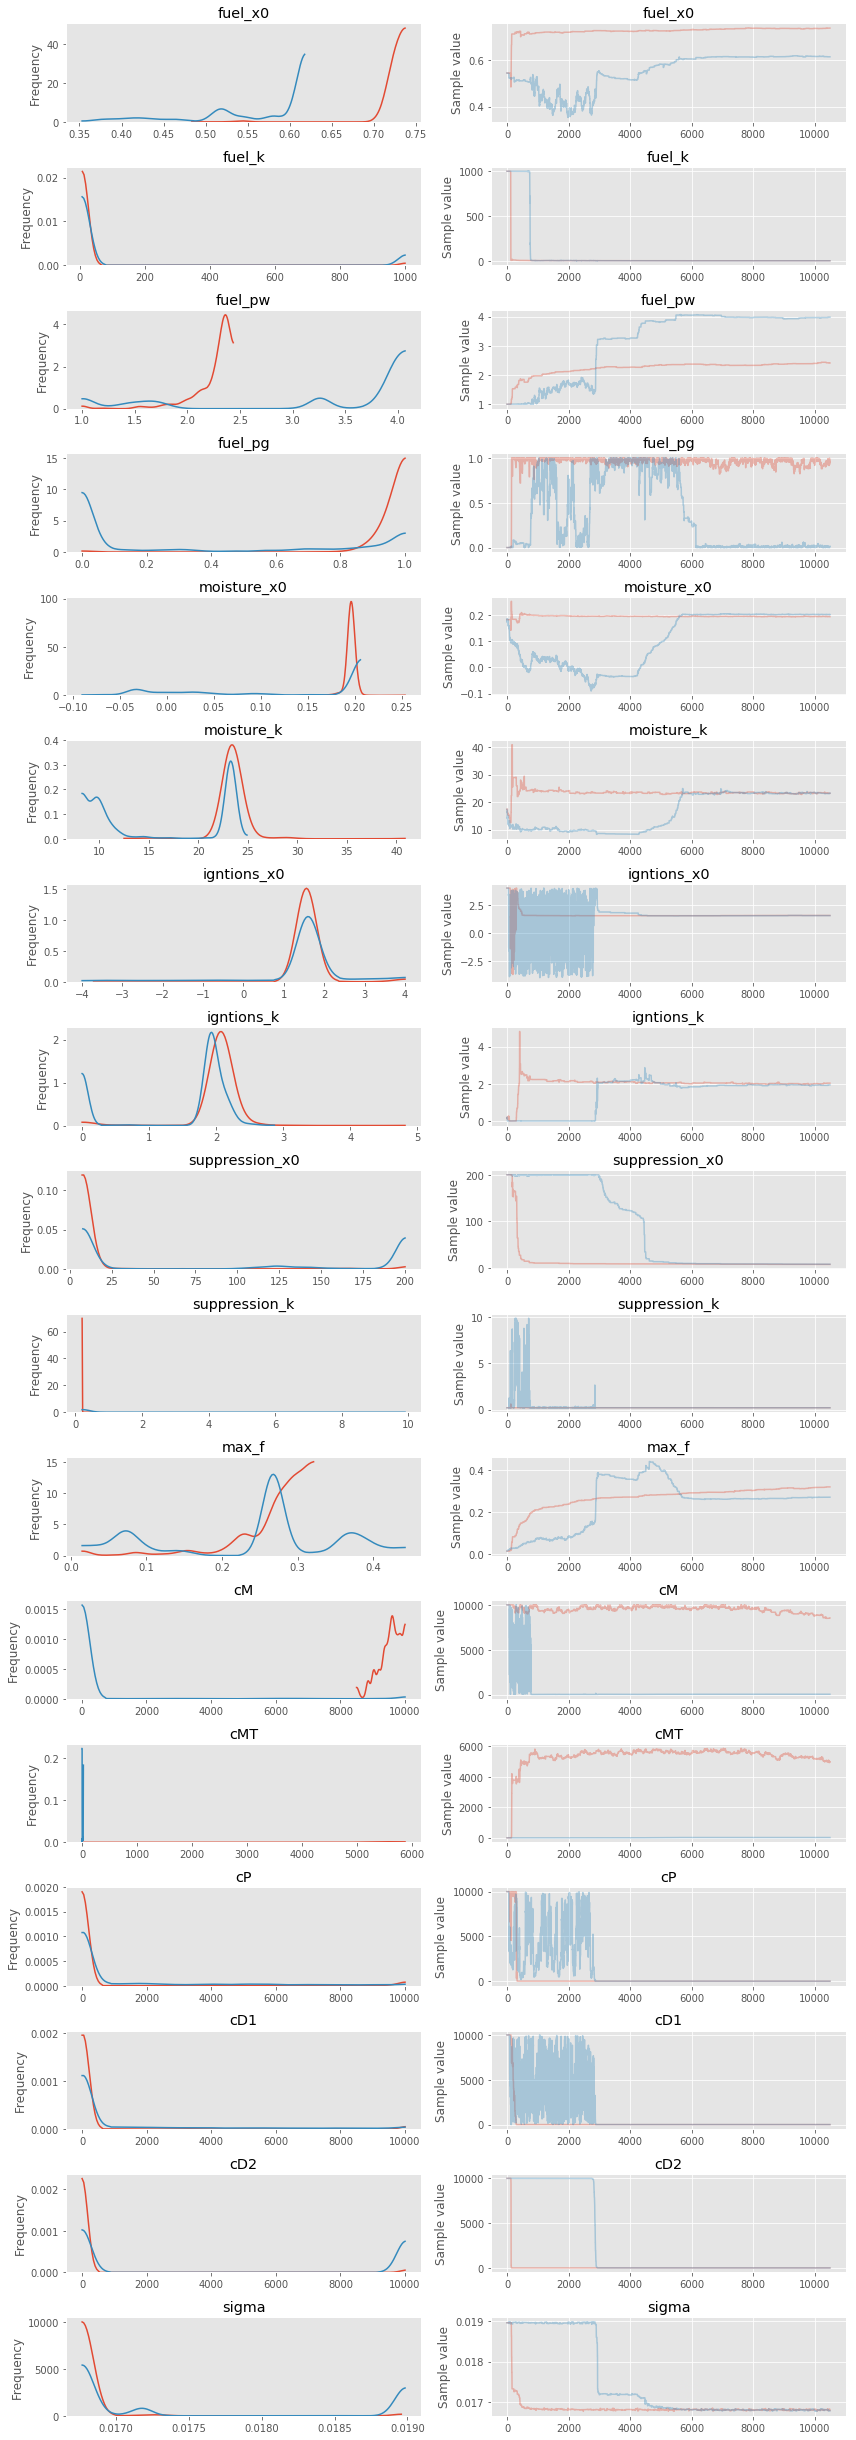

In [107]:
pm3.traceplot(mcmc_traces);

The iterations at the start are just letting the optimization settle. So we will only sample to last 5% of iterations for futher analysis. Here, exporting to netcdf for others to do their own analysis

In [112]:
varnames = mcmc_traces.varnames

def cutFirstX(varname, ncut = 90):           
    vals = mcmc_traces.get_values(varname)
    ncut = round(len(vals) * ncut / 100)
    vals = vals[ncut:]
    return(vals)

vals = [cutFirstX(i) for i in varnames]
vals = pd.DataFrame(np.array(vals).T, columns=varnames)
vals.to_csv(param_outpath, index=False)



## Plotting

Let look at the pdf of the last 5% of iterations for each parameter

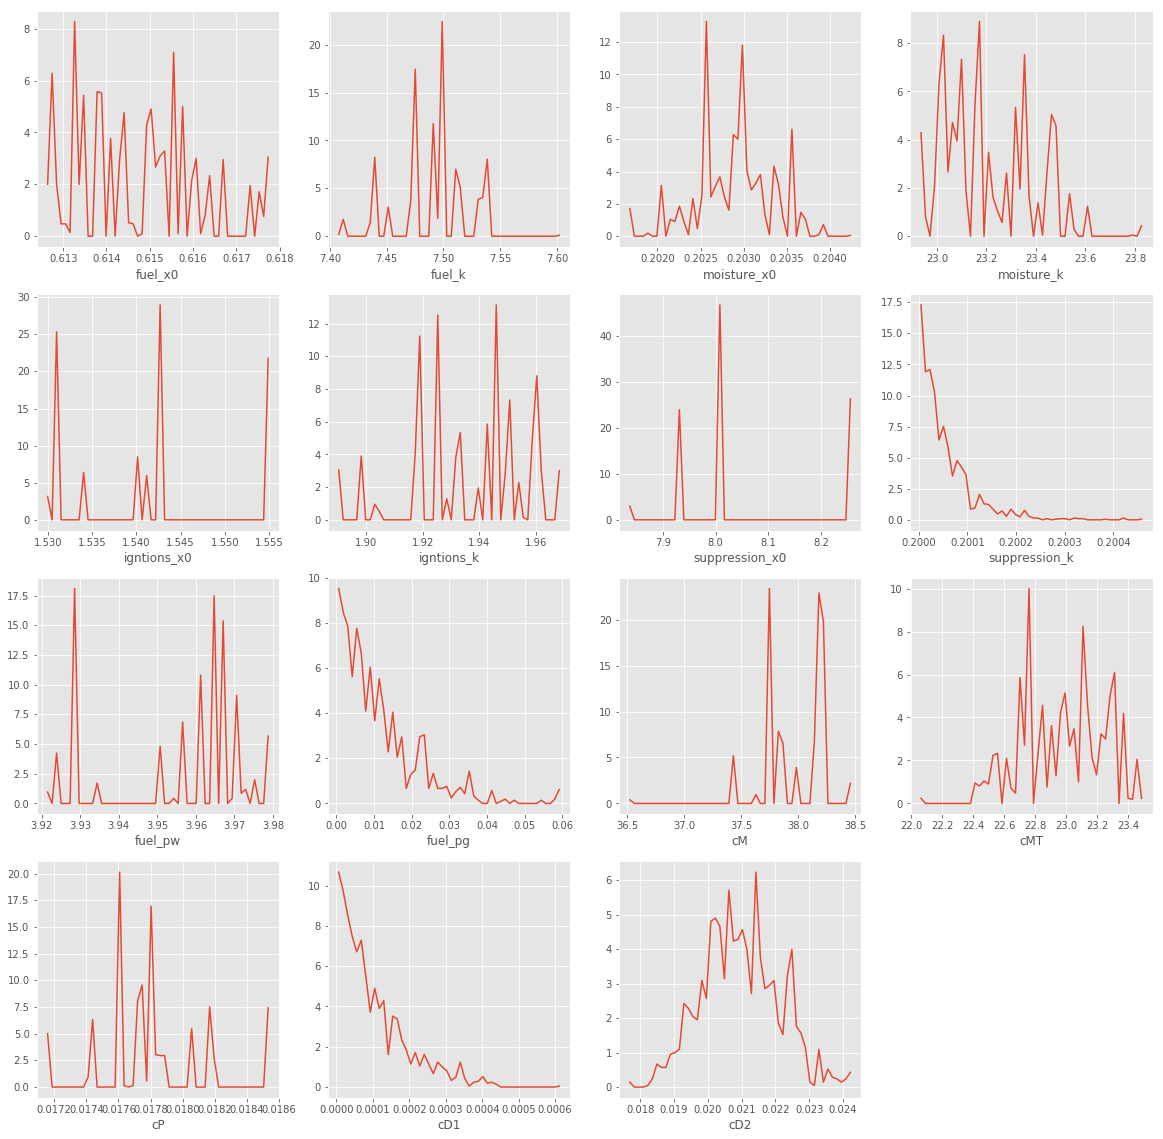

In [109]:
variables2Plot = ['fuel_x0'       , 'fuel_k',
                  'moisture_x0'   , 'moisture_k',
                  'igntions_x0'   , 'igntions_k',
                  'suppression_x0', 'suppression_k',
                  'fuel_pw'       , 'fuel_pg',
                  'cM'            , 'cMT',
                  'cP',
                  'cD1'           , 'cD2']

nvar = len(variables2Plot)
npcol = 4
nprow = np.ceil(nvar / npcol)

plt.figure(figsize=(20,5 * nprow))
def plotVar(var1, pn):
    plt.subplot(npcol, nprow, pn)
    param = vals[var1]
    
    hist, bins = np.histogram(param, bins=50)
    hist = 100.0 * hist / np.sum(hist)
    bins = bins[1:] - np.diff(bins)/2
    plt.plot(bins, hist)
    plt.xlabel(var1)
    
pn = 0
for i in variables2Plot:
    pn = pn + 1
    plotVar(i, pn)

And what to the sigmoids look like?

In [110]:
from pdb import set_trace as browser

def pltVsFire(x, xlab, pnt = 'o', *args, **kw):
    plt.plot(x, fd.fire, pnt, alpha = 0.03, *args, **kw)
    plt.xlabel(xlab)
    
def np_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + np.exp(-k*(x - x0)))

def returnSigmoid(x, k, x0):
    return np_sigmoid(x, k, x0)
    
def meanParam(x, x0, k, kmult = 1.0):
    x0 = np.mean(vals[x0])
    k  = np.mean(vals[k]) * kmult

    return returnSigmoid(x, k, x0)

def randomParam(x, x0, k, kmult = 1.0, size = 100):
    ps = np.random.choice(vals.shape[0], size = size, replace = False)
    return [returnSigmoid(x, vals[k][i] * kmult, vals[x0][i]) for i in ps]

0.9931199204254941


(0, 100)

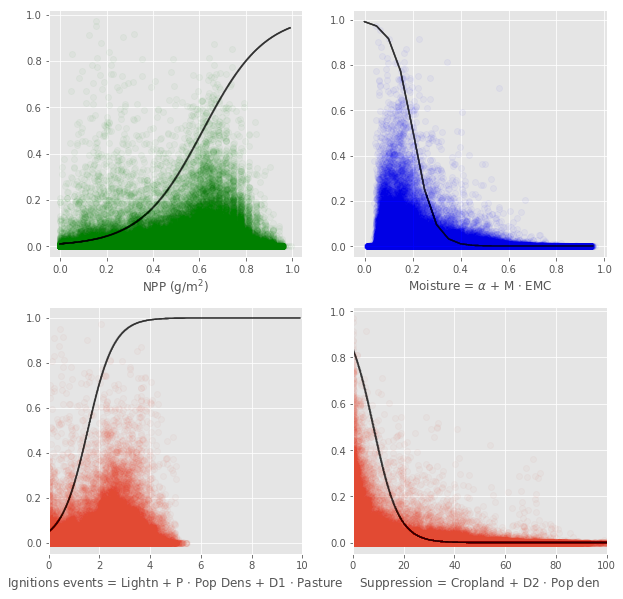

In [111]:
plt.figure(figsize=(10, 10))

####################
## Fuel           ##
####################
plt.subplot(2, 2, 1)
## scatter plot
fp = np.mean(vals['fuel_pw'])
fg = np.mean(vals['fuel_pg'])

f_fuel = fuel_load(fd["vegCover"].values, fd["alphaMax"].values, fp, fg)
print(f_fuel.max())
pltVsFire(f_fuel, "NPP (g/m$^2$)", 'go')

## Line of best fit
#Fuel = np.arange(-6, fd.fuel.max(), 0.01)
Fuel = np.arange(0, f_fuel.max(), 0.01)
r_fuel = randomParam(Fuel, 'fuel_x0', 'fuel_k')
#NPP = np.exp(Fuel)
for r in r_fuel: plt.plot(Fuel, r, 'k', alpha=.01)

## cfg plot
#plt.xscale('log')
#plt.xlim([0.5, fd.NPP.max()])

####################
## Moisture       ##
####################
plt.subplot(2, 2, 2)
## scatter plot
cM = np.mean(vals['cM'])
cMT = np.mean(vals['cMT'])
f_moisture = moisture(fd["alpha"].values, fd["emc"].values, fd["treecover"].values, cM, cMT)
pltVsFire(f_moisture , "Moisture = $\\alpha$ + M $\cdot$ EMC",'bo')

## Line of best fit
mst = np.arange(0.0, f_moisture.max(), 0.05)
r_moisture = randomParam(mst, 'moisture_x0', 'moisture_k', -1)
for r in r_moisture: plt.plot(mst, r, 'k', alpha=.01)


####################
## Igntions       ##
####################
plt.subplot(2, 2, 3)
## scatter plot 
cP  = np.mean(vals['cP' ])
cD1 = np.mean(vals['cD1'])
igniteMax = 10

f_ignite = ignition(fd["lightning_ignitions"].values, \
                    fd["pasture"].values, \
                    fd["population_density"].values, \
                    cP, cD1)
#f_ignite = np.exp(f_ignite)
pltVsFire(f_ignite, "Ignitions events = Lightn + P $\cdot$ Pop Dens + D1 $\cdot$ Pasture")

## Line of best fit
Ignite = np.arange(0.0, igniteMax, 0.1)
#Ignite = np.exp(Ignite)
#=Ignite = np.arange(0.0, 10000, 1)
r_Ignite = randomParam(Ignite, 'igntions_x0', 'igntions_k')
#yay = returnSigmoid(Ignite, 10, 1.0)
#Ignite = np.exp(Ignite)
for r in r_Ignite: plt.plot(Ignite, r, 'k', alpha=.01)

#plt.plot(Ignite, yay, 'red')

    
## cfg plot
#plt.xscale('log')
plt.xlim(0, igniteMax)

####################
## Suppression    ##
####################
plt.subplot(2, 2, 4)
#scatter plot
cD2 = np.mean(vals['cD2'])
f_suppression = supression(fd["cropland"].values, \
                           fd["population_density"].values, \
                           cD2)

pltVsFire(f_suppression, "Suppression = Cropland + D2 $\cdot$ Pop den")

# Line of best fit
Suppress = np.arange(0, 100, 0.01)
r_suppression = randomParam(Suppress, 'suppression_x0', 'suppression_k', -1.0)
for r in r_suppression: plt.plot(Suppress, r, 'k', alpha=.01)

plt.xlim(0, 100)